# Imports

In [3]:
import gzip
import pickle

import platform 
from random import choice
import scipy.stats
import sys
import gi
from gi.repository import Gtk, Gdk
import graph_tool.all as gt
import graph_tool as graph_tool
import pandas as pd
import numpy as np
import os
# move to repo root folder
os.chdir('../')
import sys
sys.path.insert(0, os.path.join(os.getcwd(),"utils"))
from hsbm import sbmmultilayer 
# from hsbm.utils.nmi import * 
from hsbm.utils.doc_clustering import construct_nmi_matrix # *
# from hsbm_creation import *
# from hsbm_fit import *
# from hsbm_partitions import *

import time
from tqdm.notebook import tqdm

from sklearn.feature_extraction import text
from nltk.stem import  WordNetLemmatizer
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime

import random
import seaborn as sn

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from IPython.display import display

In [4]:
# DEFAULT PARAMETERS IN THE FIGURES TO BE ADJUSTED!!!!

plt.style.use("default")

height_fig = 5
width_fig = 10

params_default = {
    # no upper and right axes
    'axes.spines.right' : False,
    'axes.spines.top' : False,
    # no frame around the legend
    "legend.frameon" : False,

    # dimensions of figures and labels
    # we will play with these once we see how they are rendered in the latex
    'figure.figsize' : (width_fig, height_fig),

    'axes.labelsize' : 22,
    'axes.titlesize' : 25,
    'xtick.labelsize' : 18,
    'ytick.labelsize' : 18,
    'legend.fontsize' : 16,
    
    
    # no grids (?)
    'axes.grid' : False,

    # the default color(s) for lines in the plots: in order if multiple lines. We can change them or add colors if needed
#     'axes.prop_cycle' : mpl.cycler(color=["#00008B", "#BF0000", "#006400"]), 

    # default quality of the plot. Not too high but neither too low
    "savefig.dpi" : 300,
    "savefig.bbox" : 'tight', 
    
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
}


plt.rcParams.update(params_default)

In [5]:
class print_color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [6]:
def split_words(string):
    words = []
    word_tmp = ""
    for letter in string:
        if letter in "QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm":
            word_tmp += letter
        else:
            words.append(word_tmp)
            words.append(letter)
            word_tmp = ""
    if letter in "QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm":
        words.append(word_tmp)
    return words

# Loading data

In [71]:
corpus_version = '2022-01-01' # '2021-09-01' '2022-01-01'
all_dataset_path = f"data/{corpus_version}/"
dataset_path = f"data/{corpus_version}/decentralization/"
paper_figures_folder = f"figures/"

In [72]:
filter_label = '' # if you want a specific label to do some testing
min_inCitations = 0
min_word_occurences = 5
use_titles = True

In [87]:
results_folder = os.path.join(dataset_path,f'{min_inCitations}_min_inCitations_{min_word_occurences}_min_word_occurrences/')

chosen_text_attribute = 'paperAbstract'
if use_titles:
    # USE TITLES TEXT INSTEAD OF ABSTRACTS
    print('Using titles text instead of abstracts!', flush=True)
    chosen_text_attribute = 'title'
    results_folder = results_folder[:-1] + '_titles/'

results_folder += 'ID_1_no_iterMC_5000/'

Using titles text instead of abstracts!


## all_docs

In [74]:
print('Loading data')
with gzip.open(f"{dataset_path}papers_dict.pkl.gz", "rb") as fp:
    all_docs_dict = pickle.load(fp)

Loading data


In [75]:
all_docs_dict['a00017fee08f765c31ad7d80d87ddf0d88e2f352'].keys()

dict_keys(['id', 'title', 'paperAbstract', 'authors', 'inCitations', 'outCitations', 'year', 's2Url', 'sources', 'pdfUrls', 'venue', 'journalName', 'journalVolume', 'journalPages', 'doi', 'doiUrl', 'pmid', 'fieldsOfStudy', 'magId', 's2PdfUrl', 'entities'])

## tokenized abstracts

In [76]:
with gzip.open(f"{results_folder}tokenized_texts_dict_all.pkl.gz", "rb") as fp:
    tokenized_texts_dict = pickle.load(fp)

# Fig 1 - papers in year

In [492]:
with gzip.open(all_dataset_path+"no_papers_in_fields_by_year.pkl.gz","rb") as fp:
    papers_per_year_per_field = pickle.load(fp)
    
with gzip.open(all_dataset_path+"no_authors_in_fields_by_year.pkl.gz","rb") as fp:
    authors_per_year_per_field = pickle.load(fp)
    
    
try:
    with gzip.open(all_dataset_path+"no_authors_by_year.pkl.gz","rb") as fp:
        no_authors_per_year = pickle.load(fp)
except Exception as e:
    print(e)
    with gzip.open(all_dataset_path+"sets_authors_in_fields_by_year.pkl.gz","rb") as fp:
        set_authors_per_year_per_field = pickle.load(fp)
     
    no_authors_per_year = {}
    for year in set_authors_per_year_per_field.keys():
        no_authors_per_year[year] = len(set().union(*list(set_authors_per_year_per_field[year].values())))
                                        
    with gzip.open(all_dataset_path+"no_authors_by_year.pkl.gz","wb") as fp:
        pickle.dump(no_authors_per_year,fp)  

In [493]:
years = sorted([x for x in papers_per_year_per_field.keys() if x is not None and x > 1500])

set_authors_per_year_decentralization = {y:set() for y in years}
for paper in all_docs_dict.values():
    if paper['year'] is not None:
        set_authors_per_year_decentralization[paper['year']].update([aut['ids'][0] for aut in paper['authors'] if paper['authors'] is not None and len(paper['authors'])>0 and len(aut['ids'])>0])
        
no_authors_per_year_decentralization = {y:len(set_authors_per_year_decentralization[y]) for y in years}

In [494]:
# FIGURE 2x2 OLD

# xlims = (1950,2021)
# fs = 20
# y_small = 1.02
# x_small = 0.05

# fig,axes = plt.subplots(2,2,figsize = (16,8),gridspec_kw={'wspace':0.3,'hspace':0.25})

# ax = axes[0][0]
# # ax.set_title("Fraction of decentralization papers in the full academic literature")
# dec_papers = pd.Series([x['year'] if 'year' in x else None for x in all_docs ]).explode().value_counts().sort_index()

# all_papers = pd.Series(index=years,data=[sum(list(papers_per_year_per_field[x].values())) for x in years])

# ax.plot(dec_papers.index,dec_papers.values,label='(De)centralization')
# ax.plot(all_papers.index,all_papers.values,label='ALL papers')

# ax.set_xlim(xlims)
# ax.set_yscale("log")
# ax.set_ylim((1,10**8))
# ax.set_ylabel("number of papers")
# ax.legend()
# ax.text(s="(a)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')




# ax = axes[1][0]
# # ax.set_title("Fraction of decentralization papers in the full academic literature")

# dec_papers = pd.Series([x['year'] if 'year' in x else None for x in all_docs ]).explode().value_counts().sort_index()

# all_papers = pd.Series(index=years,data=[sum(list(papers_per_year_per_field[x].values())) for x in years])

# frac_papers = dec_papers.align(all_papers,fill_value=0)[0]/dec_papers.align(all_papers,fill_value=0)[1]
# ax.plot(frac_papers.index,frac_papers.values, color = 'red')

# ax.set_xlim(xlims)
# ax.set_yscale("log")
# ax.set_ylim((10**(-4),2*10**(-2)))
# ax.set_ylabel("fraction of papers")

# ax.axvline(2016,linestyle='--',color='grey',lw=2, label='New Growth')
# ax.axvline(1963,linestyle='--',color='green',lw=2, label='Start Growth')
# ax.axvline(2008,linestyle='--',color='black',lw=2, label='Bitcoin whitepaper')# ax.legend()

# ax.text(s="(b)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')
# ax.legend()




# ax = axes[0][1]
# # ax.set_title("Fraction of decentralization papers in the full academic literature")
# dec_authors = pd.Series(no_authors_per_year_decentralization).sort_index()
# all_authors = pd.Series(no_authors_per_year).sort_index()


# ax.plot(dec_authors.index,dec_authors.values,label='(De)centralization')
# ax.plot(all_authors.index,all_authors.values,label='ALL papers')

# ax.set_xlim(xlims)
# ax.set_ylim((1,10**8))
# ax.set_yscale("log")
# ax.set_ylabel("number of authors")
# # ax.legend()
# ax.text(s="(c)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')




# ax = axes[1][1]
# # ax.set_title("Fraction of decentralization papers in the full academic literature")


# frac_authors = dec_authors.align(all_authors,fill_value=0)[0]/dec_authors.align(all_authors,fill_value=0)[1]
# ax.plot(frac_authors.index,frac_authors.values, color = 'red')

# ax.set_xlim(xlims)
# ax.set_yscale("log")
# ax.set_ylim((10**(-4),2*10**(-2)))
# ax.set_ylabel("fraction of authors")


# ax.text(s="(D)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')



# fig.savefig(f"{paper_figures_folder}figure_1.pdf")

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/pandas/core/indexes/base.py:3706: RuntimeWarning: '<' not supported between instances of 'NoneType' and 'int', sort order is undefined for incomparable objects
  join_index = self.union(other)


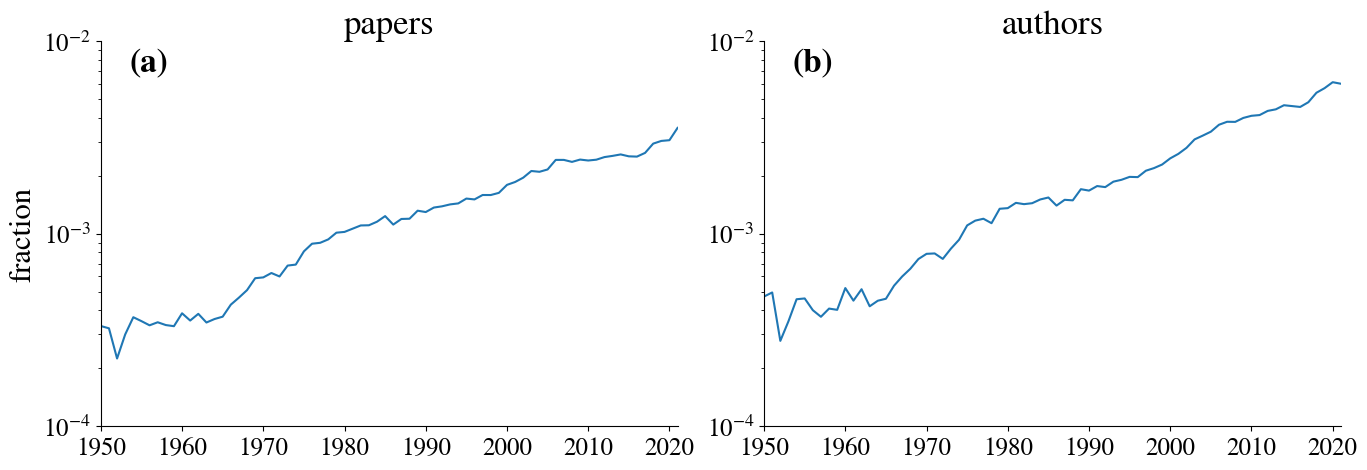

In [495]:
xlims = (1950,2021)
fs = 24
y_small = .92
x_small = 0.05

upper_limit = 10*10**(-3)
fig,axes = plt.subplots(1,2,figsize = (16,5),gridspec_kw={'wspace':0.15})

ax = axes[0]
# ax.set_title("Fraction of decentralization papers in the full academic literature")

dec_papers = pd.Series([x['year'] if 'year' in x else None for x in all_docs_dict.values()]).explode().value_counts().sort_index()

all_papers = pd.Series(index=years,data=[sum(list(papers_per_year_per_field[x].values())) for x in years])

frac_papers = dec_papers.align(all_papers,fill_value=0)[0]/dec_papers.align(all_papers,fill_value=0)[1]
ax.plot(frac_papers.index,frac_papers.values)#, color = 'red')

ax.set_xlim(xlims)
ax.set_xticks(range(1950,2022,10))
ax.set_yscale("log")
ax.set_ylim((10**(-4),upper_limit))
ax.set_ylabel("fraction")
ax.set_title("papers")

# ax.axvline(2016,linestyle='--',color='grey',lw=2, label='New Growth')
# ax.axvline(1963,linestyle='--',color='green',lw=2, label='Start Growth')
# ax.axvline(2008,linestyle='--',color='black',lw=2, label='Bitcoin whitepaper')# ax.legend()

ax.text(s="(a)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')
# ax.legend()





ax = axes[1]
# ax.set_title("Fraction of decentralization papers in the full academic literature")
dec_authors = pd.Series(no_authors_per_year_decentralization).sort_index()
all_authors = pd.Series(no_authors_per_year).sort_index()


frac_authors = dec_authors.align(all_authors,fill_value=0)[0]/dec_authors.align(all_authors,fill_value=0)[1]
ax.plot(frac_authors.index,frac_authors.values)#, color = 'red')

ax.set_xlim(xlims)
ax.set_yscale("log")
ax.set_ylim((10**(-4),upper_limit))
# ax.set_ylabel("fraction")
ax.set_xticks(range(1950,2022,10))
ax.set_title("authors")

ax.text(s="(b)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes, fontweight='bold')



fig.savefig(f"{paper_figures_folder}figure_1.pdf")

# graph-tool analysis

- texts: list of tokenized abstracts
- titles: list of unique paperIds


In [78]:
filter_label = ""# "_filtered_%dcits"%(min_citations)
print(filter_label)

In [79]:
hyperlink_g = gt.load_graph(f"{results_folder}gt_network{filter_label}.gt")
num_vertices = hyperlink_g.num_vertices()
num_edges = hyperlink_g.num_edges()
print(num_vertices, num_edges)

181605 590215


In [80]:
label = hyperlink_g.vp["label"]
name = hyperlink_g.vp["name"] # every vertex has a name already associated to it!

# Retrieve true partition of graph
true_partition = list(hyperlink_g.vp.label)    
# Retrieve ordering of articles
article_names = list(hyperlink_g.vp.name)

# unique_hyperlinks = hyperlinks.copy()

In [81]:
try:
    with gzip.open(f"{results_folder}IDs_texts_and_edited_text_papers_with_abstract{filter_label}.gz", "rb") as fp:
        titles,texts,edited_text = pickle.load(fp)
except:
    with gzip.open(f"{results_folder}titles_texts_and_edited_text_papers_with_abstract{filter_label}.gz", "rb") as fp:
        titles,texts,edited_text = pickle.load(fp)

## Load states

In [ ]:
# results_folder = results_folder
# start = datetime.now()
# print("Doing analysis, not fit",flush = True)
# results_folder = results_folder + f"ID_{_id_list[0]}_no_iterMC_{number_iterations_MC_equilibrate}_edge_divider_{edge_divider}/"
# with gzip.open(f"{results_folder}/results_fit_greedy{filter_label}.gz","rb") as fp:
#             hyperlink_text_hsbm_states,time_duration = pickle.load(fp)
# print("Loaded %d"%_id_list[0],flush = True)


# for _id in _id_list[1:]:
#     results_folder = results_folder + f"ID_{_id}_no_iterMC_{number_iterations_MC_equilibrate}_edge_divider_{edge_divider}/"
#     with gzip.open(f"{results_folder}/results_fit_greedy{filter_label}.gz","rb") as fp:
# #                 hyperlink_text_hsbm_states.append(pickle.load(fp)[0])
#             hyperlink_text_hsbm_states += pickle.load(fp)[0]
#     print("Loaded %d"%_id,flush = True)
# end = datetime.now()
# print("Time laoding states",end-start,flush=True)
# with gzip.open(f"{results_folder}/results_fit_greedy{filter_label}.gz","wb") as fp:
#     pickle.dump((hyperlink_text_hsbm_states,end-start),fp)
# results_folder = results_folder

In [88]:
with gzip.open(f"{results_folder}results_fit_greedy{filter_label}.gz","rb") as fp:
    hyperlink_text_hsbm_states,time_duration = pickle.load(fp)

In [89]:
print(time_duration,flush=True)

21:12:41.179621


## Retrieve partitions

Retrieve the partitions assigned to the document nodes by examining the highest non-trivial level of the hierarchical degree-corrected SBM.

In [90]:
with gzip.open(f"{results_folder}results_fit_greedy_partitions{filter_label}.gz","rb") as fp:
    hyperlink_text_hsbm_partitions, levels = pickle.load(fp)
    # Retrieve partitions assigned to documents in each run. Also save index of highest non-trivial level.

In [91]:
levels

[5]

In [92]:
print(len(hyperlink_text_hsbm_states[0].documents),flush=True)

181605


## Compute centralities

In [82]:
ordered_paper_ids = list(hyperlink_g.vp['name'])

In [83]:
[x for x in ordered_paper_ids if x is None]

[]

In [84]:
citations_df = pd.read_csv(f"{results_folder}citations_edgelist.csv")

In [85]:
id2NoCits = {x: len(all_docs_dict[x]['inCitations']) for x in all_docs_dict.keys()}

In [86]:
centralities = {}

centralities['citations_overall'] = np.vectorize(id2NoCits.get)(ordered_paper_ids)

paper_with_cits = citations_df['from'].value_counts().index.values
paper_without_cits = set(ordered_paper_ids).difference(set(paper_with_cits))
centralities['in_degree'] = citations_df['from'].value_counts().append(pd.Series(data = np.zeros(len(paper_without_cits)),index=paper_without_cits)).loc[ordered_paper_ids].values

centralities['eigenvector'] = graph_tool.centrality.eigenvector(hyperlink_g)[1]._get_data()
centralities['betweenness'] = graph_tool.centrality.betweenness(hyperlink_g)[0]._get_data()
centralities['closeness'] = graph_tool.centrality.closeness(hyperlink_g)._get_data()
centralities['pagerank'] = graph_tool.centrality.pagerank(hyperlink_g)._get_data()
centralities['katz'] = graph_tool.centrality.katz(hyperlink_g)._get_data()

## Consensus Partition

Compute the consensus partition assignment to document nodes over all the runs.

In [93]:
print("loading")
with gzip.open(f"{results_folder}results_fit_greedy_partitions_docs_all{filter_label}.gz","rb") as fp:
    hyperlink_text_hsbm_partitions_by_level,duration = pickle.load(fp)
with gzip.open(f"{results_folder}results_fit_greedy_partitions_docs_all_info{filter_label}.gz","rb") as fp:
    hyperlink_text_hsbm_partitions_by_level_info,duration = pickle.load(fp)

loading


In [94]:
with gzip.open(f"{results_folder}/results_fit_greedy_partitions_consensus_all{filter_label}.gz","rb") as fp:
    h_t_doc_consensus_by_level, h_t_word_consensus_by_level, h_t_consensus_summary_by_level = pickle.load(fp)


In [95]:
ordered_paper_ids = list(hyperlink_g.vp['name'])

In [96]:
# WORKS WITH MORE THAN 1 ITERATION (in teoria va bene sempre...)
name2partition_by_level = {max(list(h_t_doc_consensus_by_level.keys()))+1 : {x:0 for x in ordered_paper_ids}}

for level in h_t_doc_consensus_by_level.keys():
    name2partition_by_level[level] = {}
    for i,paper_id in enumerate(list(hyperlink_g.vp["name"])):
        name2partition_by_level[level][paper_id] = h_t_doc_consensus_by_level[level][i]

In [97]:
# # WORKS WITH ONLY 1 ITERATION
# name2partition_by_level = {}

# for level in hyperlink_text_consensus_partitions_by_level.keys():
#     name2partition_by_level[level] = hyperlink_text_hsbm_partitions_by_level_info[level][0][3]

# ## ALERT this works only if one iteration has been done, otherwise fix it

In [98]:
ordered_edited_texts = [tokenized_texts_dict[paper_id] for paper_id in ordered_paper_ids]

In [99]:
doc_partition_remapping_by_level = {}
doc_partition_remapping_by_level_inverse = {}
for level in name2partition_by_level:
    if level != max(list(h_t_doc_consensus_by_level.keys()))+1:
        # level = 3
        doc_partition_remapping_by_level[level] = {}
        doc_partition_remapping_by_level_inverse[level] = {}
        lista1 = []
        for paper in ordered_paper_ids:
            lista1.append(name2partition_by_level[level][paper])
    #     lista2 = hyperlink_text_consensus_partitions_by_level[level]
        lista2 = h_t_doc_consensus_by_level[level]
    #     print(set(list(zip(lista1,lista2))))
        for part1, part2 in set(list(zip(lista1,lista2))):
            if part1 in doc_partition_remapping_by_level[level]:
                print("THERE ARE MULTIPLE INSTANCES... ERROR")
                break
            else:
                doc_partition_remapping_by_level[level][part1] = part2  
                doc_partition_remapping_by_level_inverse[level][part2] = part1

### Project level

#### Loading it

In [ ]:
initial_level = 3
with open(results_folder+f"model_consensus_occ_{occ}_initial_level_{initial_level}.pkl","rb") as fp:
    model = pickle.load(fp)
state = model.state

In [ ]:
state = model.state
print(state,"\n")
levels = state.get_levels()
for i,s in enumerate(levels):
    print(i,s)
    if s.get_N() == 1:
        break

In [ ]:
state.print_summary()

#### Creation projected state

We now retrieve the topics associated to the consensus partition of Hyperlink + Text model.

In [ ]:
initial_level = 3

In [ ]:
with gzip.open(f"{results_folder}results_fit_greedy_partitions_words_all{filter_label}.gz","rb") as fp:
    H_T_word_hsbm_partitions_by_level, H_T_word_hsbm_num_groups_by_level = pickle.load(fp)

In [ ]:
# h_t_doc_consensus = gt.partition_overlap_center(hyperlink_text_hsbm_partitions)[0]
# h_t_doc_consensus_by_level = {l:gt.partition_overlap_center(hyperlink_text_hsbm_partitions_by_level[l])[0] for l in hyperlink_text_hsbm_partitions_by_level.keys()}

In [ ]:
model=hyperlink_text_hsbm_states[0]
print(model)

In [ ]:
state = model.state
print(state,"\n")
levels = state.get_levels()
for i,s in enumerate(levels):
    print(i,s)
    if s.get_N() == 1:
        break

In [ ]:
state.print_summary()

In [ ]:
def get_consensus_nested_partition_bs(h_t_word_consensus_by_level):
    """
    As parameter it takes a dictionary {level: [[partition[paper] for paper in papers] for i in iterations]}.
    It calculates the nested consensus partition (reordered correctly)
    """
    hierarchy_words_partitions = {}
    for l in range(max(h_t_word_consensus_by_level),0,-1):
        tmp1_words, tmp2_words = h_t_word_consensus_by_level[l], h_t_word_consensus_by_level[l-1]


        hierarchy_words_partitions[l] = {w: set() for w in np.unique(tmp1_words)}

        for i in range(len(tmp1_words)):
            hierarchy_words_partitions[l][tmp1_words[i]].add(tmp2_words[i])

    hyperlink_words_hsbm_partitions_by_level = {0:h_t_word_consensus_by_level[0]}

    for l in range(1,len(h_t_word_consensus_by_level)):
        
        tmp_list = -np.ones(int(max(hyperlink_words_hsbm_partitions_by_level[l-1])+1),dtype=int)
        for i,group in hierarchy_words_partitions[l].items():
            for j in group:
                tmp_list[j] = i
        hyperlink_words_hsbm_partitions_by_level[l] = tmp_list

    bs_w = [hyperlink_words_hsbm_partitions_by_level[l] for l in hyperlink_words_hsbm_partitions_by_level.keys()]
    return bs_w

In [ ]:
# bs_w = get_consensus_nested_partition_bs(h_t_word_consensus_by_level)
# If you want less levels, just use the following
bs_w = get_consensus_nested_partition_bs({level-initial_level:partition for level,partition in h_t_word_consensus_by_level.items() if level >= initial_level})

In [ ]:
bs_w[-1]

In [ ]:
for l in range(len(bs_w)):
    bs_w[l] = bs_w[l][bs_w[l] != -1]

In [ ]:
bs_w.append(np.ones(len(set(bs_w[-1])),dtype=int))

In [ ]:
bs_w.append(np.array([0]))

In [ ]:
# bs_d = get_consensus_nested_partition_bs(h_t_doc_consensus_by_level)
# If you want less levels, just use the following
# initial_level = 2
bs_d = get_consensus_nested_partition_bs({level-initial_level:partition for level,partition in h_t_doc_consensus_by_level.items() if level >= initial_level})

In [ ]:
bs_d[-1]

In [ ]:
bs_d.append(np.zeros(len(set(bs_d[-1])),dtype=int))

In [ ]:
bs_d.append(np.array([0]))

In [ ]:
ordered_paper_ids = list(hyperlink_g.vp['name'])
new_ordered_partitions_dict = {}
for i,v in tqdm(enumerate(model.g.vertices())):
    if model.g.vp["kind"][v] == 0:
        paper_id = model.g.vp['name'][v]
        new_ordered_partitions_dict[paper_id] = ordered_paper_ids.index(paper_id)

In [ ]:
l = initial_level
new_ordered_partitions = []
for i,v in tqdm(enumerate(model.g.vertices())):
    if model.g.vp["kind"][v] == 0:
        paper_id = model.g.vp['name'][v]
        new_ordered_partitions.append(h_t_doc_consensus_by_level[l][new_ordered_partitions_dict[paper_id]])
bs_d[0] = np.array(new_ordered_partitions)

In [ ]:
bs = []
for l in range(len(bs_d)):
    bs.append(np.concatenate((bs_d[l],bs_w[l])))

In [ ]:
state = model.state.copy(bs=bs)

In [ ]:
# lowest = model.state.project_level(2)

In [ ]:
# model.state.levels[0] = lowest

In [ ]:
# del model.state.levels[1:3]
# model.state.levels

In [ ]:
# model.state.levels[0].layer_states

In [ ]:
state.print_summary()

In [ ]:
model.state = state

In [ ]:
model.n_levels = len(model.state.levels)

In [ ]:
groups = {}
groups = { level: model.get_groupStats(l=level) for level in tqdm(range(model.n_levels - 2)) }

In [ ]:
model.groups = groups

In [ ]:
with open(results_folder+f"model_consensus_occ_{occ}_initial_level_{initial_level}.pkl","wb") as fp:
    pickle.dump(model,fp)

In [ ]:
with open(results_folder+f"state_consensus_occ_{occ}_initial_level_{initial_level}.pkl","wb") as fp:
    pickle.dump(state,fp)

#### Get top elements in each cluster

In [ ]:
# check group membership
level = 0
count = 0
for i in range(len(model.groups[level]["p_td_d"][0])):
    if np.sum(model.groups[level]["p_td_d"][:,i]) not in {0,1}:
        if np.isnan(np.sum(model.groups[level]["p_td_d"][:,i])):
            count += 1
        else:
            print(i, sum(model.groups[level]["p_td_d"][:,i]))
            break
print("There are %d nan"%count)
# at level 1 (new) there are 380 nan in docs, 0 in words

In [ ]:
group_membership = {}
partitions = {-i-1:set() for i in range(model.groups[level]['Bw'])} # words have negative topic index here
for i in range(model.groups[level]['Bd']):
    partitions[i] = set() # documents  have positive topic index here
N_docs = model.get_D()
for v in model.g.vertices():
    if model.g.vp["kind"][v] == 0: # is document
        tmp = np.where(model.groups[level]["p_td_d"][:,int(v)] == 1)
        is_word = False
    else:
        tmp = np.where(model.groups[level]["p_tw_w"][:,int(v)-N_docs] == 1)
        is_word = True
    if len(tmp) == 0 or len(tmp[0]) == 0:
        group_membership[v] = -1
    else:
        if is_word:
            group_membership[v] = - tmp[0][0]
            partitions[- tmp[0][0] - 1].add(v)
        else:
            group_membership[v] = tmp[0][0]
            partitions[tmp[0][0]].add(v)
        

In [ ]:
# just a check here
min_d = 100000000
max_d = -1
min_w = 100000000
max_w = -1
for i,v in enumerate(model.g.vertices()):
    if model.g.vp["kind"][v] == 0:
        min_d = min(min_d,int(v))
        max_d = max(max_d,int(v))
    else:
        min_w = min(min_w,int(v))
        max_w = max(max_w,int(v))

min_d, max_d, min_w, max_w

In [ ]:
for i,j in partitions.items():
    if len(partitions[i]) > 0:
        if i>= 0 and max(partitions[i]) >= N_docs:
            print(i,min(partitions[i]), max(partitions[i]))
        elif i< 0 and min(partitions[i]) < N_docs:
            print(i,min(partitions[i]), max(partitions[i]))

In [ ]:
g = model.g

In [ ]:
degrees = g.degree_property_map("total")

In [ ]:
highest_degree_in_partitions = {}
for i,j in partitions.items():
    max_degree = -1
    max_v = -1
    for v in j:
        if degrees[v] > max_degree:
            max_v = v
            max_degree = degrees[v]
    if max_v != -1:
        highest_degree_in_partitions[i] = max_v

In [ ]:
text_position = model.g.new_vp("double")
for v in model.g.vertices():
    if model.g.vp["kind"][v] == 0:
        text_position[v] = 0
    else:
        text_position[v] = np.pi

In [ ]:
def split_in_rows(string, max_lines = 3, max_chars_in_line = 18):
    new_string = ""
    count = 0
    count_lines = 1
    for char in string:
#         print(char)
        if count > max_chars_in_line:
            if count_lines == max_lines:
                return new_string
            else:
                new_string += "\n"
                count_lines += 1
            if char != " ":
                new_string += char
                count = 1
            else:
                count = 0
        elif max_chars_in_line - count < 3 and char == " ":
            if count_lines == max_lines:
                return new_string
            else:
                new_string += "\n"
                count_lines += 1
                count = 0
        else:
            new_string += char
            count += 1
    return new_string

In [ ]:
text_nodes = model.g.new_vp("string")
for v in model.g.vertices():
    text_nodes[v] = ""
for i,v in highest_degree_in_partitions.items():
#     print(int(v))
    if i >= 0:
#         text_nodes[v] = model.documents[int(v)]
        text_nodes[v] = all_docs_dict[model.documents[int(v)]]["title"]
#         text_nodes[v] = split_in_rows(all_docs_dict[model.documents[int(v)]]["title"], max_lines=5,max_chars_in_line=8)
#         text_nodes[v] = model.documents[int(v)] # use ... np.array(model.get_topicProportion(0,l=0))
    else:
        text_nodes[v] = model.words[int(v)-N_docs]

In [ ]:
text_font_size = model.g.new_vp("int")
for v in model.g.vertices():
    text_font_size[v] = 10
for i,v in highest_degree_in_partitions.items():
    if i >= 0:
        text_font_size[v] = 6

#### Other useful functions
These are not actually used in the rest of the notebook

In [ ]:
np.array(model.get_topicProportion(0,l=0))

In [ ]:
query = model.clusters_query(1878, l=4)

In [ ]:
query[:10]

In [ ]:
model.get_topics(l=4,n=5)

In [ ]:
model.get_topicProportion([1800,1801],l=4)

In [ ]:
# For some reason, this does not work. Needs to be checked in sbmmultilayer.py
model.get_docclusters(l=4,n=10)

#### Plotting

In [ ]:
middle = state.project_level(1)

In [ ]:
blocks_middle = middle.get_blocks()

In [ ]:
blocks_list = list(set(blocks_middle))
N = len(blocks_list)
tmp_palette = sn.color_palette("bright", N) # husl , inferno, bright, colorblind

In [ ]:
tmp_palette

In [ ]:
palette = tmp_palette

In [ ]:
# REORDER PALETTE FOR BETTER VISIONING
# ACHTUNG: works only with initial_layer = 3
indexes_to_add = {2,4,6,8,10,11,12} # These are the indexes in  palette that are picked for documents
to_add = [3,4,5,8,9,10,12] # choose instead these colours
not_to_add = list(set(range(N)).difference(set(to_add)))

palette = []
for i in range(N):
    if i in indexes_to_add:
        palette.append(tmp_palette[to_add[0]])
        del to_add[0]
    else:
        palette.append(tmp_palette[not_to_add[0]])
        del not_to_add[0]

In [ ]:
N

In [ ]:
set(blocks_list)

In [ ]:
colors = {}
for i,block in enumerate(blocks_list):
    colors[block] = [1, *palette[i], 0.1]

colors2 = {}
for i,block in enumerate(blocks_list):
#     colors2[block] = [1, *palette[i], 0.1]
    colors2[block] = [*palette[i]]

In [ ]:
g = model.g

v_size = g.new_vp("double")

degrees = g.degree_property_map("total")

In [ ]:
for v in g.vertices():
    v_size[v] = 2*np.log(degrees[v])

In [ ]:
color_vertices = g.new_vp("vector<double>")

for v in g.vertices():
    color_vertices[v] = colors2[blocks_middle[v]] # [0, 0.68041891, 0.61514975, 0.19405452, 1]# 

In [ ]:
color_edges = g.new_ep("vector<double>")

for e in g.edges():
    source,target = e
#     source_kind = g.vp["kind"][source]
#     target_kind = g.vp["kind"][target]
    color_edges[e] = colors[blocks_middle[source]] # [0, 0.68041891, 0.61514975, 0.19405452, 1]# 

In [ ]:
pos, h, hpos = state.draw(
#     output=paper_figures_folder+"bipartite_cut_levels_6-2.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices, "text":text_nodes, "text_position":text_position}, 
    subsample_edges = 100, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":5,"gradient":color_edges},
    hvprops = {"size":15, "pen_width":2,"color":"blue", "text":"123", "text_color":"black","font_size":20},
    heprops = {"pen_width":6},
    layout = "bipartite",
    bip_aspect = 1)

In [ ]:
pos, h, hpos = state.draw(
#     output=paper_figures_folder+"bipartite_cut_levels_6-2.png", 
    bg_color='w',
    output_size=(1920, 1200),
#     vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices, "text":text_nodes, "test_position":test_position}, 
    subsample_edges = 100, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
#     vsize_scale = 100,
    eprops = {"pen_width":5},#,"gradient":color_edges},
    hvprops = {"size":15, "pen_width":2,"color":"blue", "text":"123", "text_color":"black","font_size":20},
    heprops = {"pen_width":6},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
n = model.get_V() + model.get_D()

In [ ]:
hv_names = h.new_vp("string")
for v in h.vertices():
    hv_names[v] = str(int(v)-n)

In [ ]:
hv_pos = h.new_vp("double")
hv_offset = h.new_vp("double") # IT GIVES RUNTIME ERROR! :(
for v in h.vertices():
    if hpos[v][0] > 0:
        hv_pos[v] = 0
        hv_offset[v] = .125#625-hpos[v][0]/2 # [0.9-hpos[v][0]/2,0]
    elif hpos[v][0] == 0:
        hv_pos[v] = np.pi/2
    else:
        hv_pos[v] = np.pi
        hv_offset[v] = -.125#625+hpos[v][0]/2 # [-0.9-hpos[v][0]/2,0]

In [ ]:
state.draw(
#     output=paper_figures_folder+"bipartite_cut_levels_6-2.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, # , "text":text_nodes, "text_position":text_position
    subsample_edges = 100, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":5,"gradient":color_edges},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
               "text":hv_names, "text_color":"black","font_size":16,
               "text_position":hv_pos, # -1 is internal, positive is angle in radians. Use h for h properties
               "text_offset":hv_offset
              }, 
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
#     max_render_time = 10000,
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
pos_tmp, h_tmp, hpos_tmp = state.draw(
#     output=paper_figures_folder+"bipartite_cut_levels_6-2.png", 
    bg_color='w',
    output_size=(1920, 1200),
#     pos = pos2,
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices, #}, 
              "text":text_nodes, "text_color":"black","font_size":text_font_size,  
              "text_position":text_position},
    subsample_edges = 100, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":5,"gradient":color_edges},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
               "text":hv_names, "text_color":"black","font_size":16,
               "text_position":hv_pos, # -1 is internal, positive is angle in radians. Use h for h properties
#                "text_offset":hv_offset
              }, 
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
#     max_render_time = 10000,
    layout = "bipartite", # pos2 to force pos2
    bip_aspect = 1.2
    )

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, # , "text":text_nodes, "text_position":text_position
    subsample_edges = 100000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":.1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
#                "text":hv_names, "text_color":"black","font_size":16,
              "text_position":np.pi}, # -1 is internal, positive is angle in radians. Use h for h properties
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8-2.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, # , "text":text_nodes, "text_position":text_position
    subsample_edges = 1000000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
#                "text":hv_names, "text_color":"black","font_size":16,
              "text_position":np.pi}, # -1 is internal, positive is angle in radians. Use h for h properties
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8-3.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, # , "text":text_nodes, "text_position":text_position
    subsample_edges = 1000000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":.1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
#                "text":hv_names, "text_color":"black","font_size":16,
              "text_position":np.pi}, # -1 is internal, positive is angle in radians. Use h for h properties
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8_name_docs.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices, 
              "text":text_nodes, "text_color":"black","font_size":text_font_size,  
              "text_position":text_position},

    subsample_edges = 100000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":.1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
#                "text":hv_names, "text_color":"black","font_size":16,
              "text_position":np.pi}, # -1 is internal, positive is angle in radians. Use h for h properties
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8_names.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, 
    subsample_edges = 100000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":.1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
               "text":hv_names, "text_color":"black","font_size":16,
               "text_position":hv_pos, # -1 is internal, positive is angle in radians. Use h for h properties
               "text_offset":hv_offset
              }, 
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

In [ ]:
state.draw(
    output=paper_figures_folder+"bipartite_cut_levels_8_names-2_real8.png", 
    bg_color='w',
    output_size=(1920, 1200),
    vprops = {"size":v_size, "fill_color":color_vertices, "color":color_vertices}, 
    subsample_edges = 1000000, 
    beta = 0.8, # 0.8, # default
#     vprops = {"size":},
    vsize_scale = 100,
    eprops = {"pen_width":.1,"gradient":color_edges},
#     hvprops = {"size":15, "pen_width":2,"color":"blue"},
    hvprops = {"size":15, "pen_width":2,"color":[0.,0.,0.,0.7], "fill_color":[0.5,0.5,0.5,0.6], 
               "text":hv_names, "text_color":"black","font_size":16,
              "text_position":-1}, # -1 is internal, positive is angle in radians. Use h for h properties
#     heprops = {"pen_width":6},
    heprops = {"pen_width":6, "color":[0.5,0.5,0.5,0.6]},
    layout = "bipartite",
    bip_aspect = 1.2)

## Partition overlap and normalised mutual information

Compute heatmap showing the partition overlap and normalised mutual information of hyperlink + text model and fields of study labels.

If there is only one iteration of the model, do not print std (useless). Otherwise, print it!

In [55]:
def compute_partition_overlap(partition_i, partition_j):
    """
    Compute the maximum partition overlap between the two partitions.
    """
    return gt.partition_overlap(partition_i, partition_j)


def _max_overlap_partition(partitions):
    """
    Helper function for calculating the partition overlap. Take in list of partitions from 2 different models and
    computes the partition overlap between the two models' partitions.

    partitions: list of list
    The partitions will be two lists of lists of size N_ITER where each list corresponds to partitions of a model 
    where we retrieve N_ITER partitions each time.

    Return: list of partition overlap between partitions.
    """
    n = len(partitions) # 10 * 10, depends on number of iterations to retrieve partitions
    overlap_partition_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            overlap_partition_matrix[i,j] = compute_partition_overlap(partitions[i], partitions[j])
    return list(overlap_partition_matrix[np.triu_indices(n,1)]) # return upper triangle for array.

def construct_maximum_overlap_partition_matrix(partitions, true_partition):
    """
    Compute maximum overlap partition matrix for all partitions generated by models against true partition.

    partitions: list of list of partitions for each model (iteration). 
    true_partition: single list of true partitions.

    Remark: For example, we may generate 20 different partitions for the hSBM and compare it to the true partitions.
    First column is for the true partition.
    """
    num_models = len(partitions) # number of different models we are testing.
    # Store the average and standard deviation of partition overlap between partitions in a n x n matrix
    max_partition_overlap_avg = np.zeros((num_models+1, num_models+1))
    max_partition_overlap_std = np.zeros((num_models+1, num_models+1))

    # Iterate through NMI matrix and compute partition overlap between models excluding the ground truth.
    # We do not iterate through the first column.
    for i in range(1, num_models+1):
        for j in range(i, num_models+1):
            partition_overlaps = _max_overlap_partition(partitions[i-1] + partitions[j-1]) # retrieve list of partitions for model i-1 and model j-1
            # Store mean and std of partition overlap.
            max_partition_overlap_avg[i,j] = np.average(partition_overlaps)
            max_partition_overlap_std[i,j] = np.std(partition_overlaps)

    max_partition_overlap_avg[0,0], max_partition_overlap_std[0,0] = 1, 0 # true partition should have NMI of 1 with itself.
    # Compute the NMI for each model against ground truth. Corresponds to 1st column of NMI matrix.
    for i in range(num_models):
        # Compute NMI of model's partition with ground truth labels.
        partition_overlap_with_true = [compute_partition_overlap(p, true_partition) for p in partitions[i]]
        max_partition_overlap_avg[0, i+1] = np.average(partition_overlap_with_true)
        max_partition_overlap_std[0, i+1] = np.std(partition_overlap_with_true)
    return (max_partition_overlap_avg.T, max_partition_overlap_std.T)            

In [56]:
def map_partition_to_int(partition):
    # Helper function for Wikipedia labelling for heatmap.
    cat_map = {}
    for id, cat in enumerate(set(partition)):
        cat_map[cat] = id

    int_mapping = []
    for entry in partition:
        int_mapping.append( cat_map[entry] )

    return int_mapping

In [57]:
sn.set_style("whitegrid")
sn.set(font_scale=2)

def visualise_heatmap_results(averages, std , cols, title, print_std = True, file_path_png="",file_path_pdf=""):
    """
    Construct heat-map to show NMI of partitions.
    """
    plt.figure(figsize=(20, 10))
    sn.axes_style("white")
    sn.set_style("whitegrid")

    mask = np.zeros_like(averages)
    mask[np.triu_indices_from(mask, k=1)] = True
    final_df = pd.DataFrame(averages, columns=cols, index=cols)
    if print_std == True:
        labels = (np.asarray(["{0:.2f}\n({1:.2f})".format(averages_entry, std_entry) for averages_entry, std_entry in zip(averages.flatten(), std.flatten())])).reshape(len(averages), len(averages))    
    else:
        labels = (np.asarray(["{0:.2f}".format(averages_entry) for averages_entry, std_entry in zip(averages.flatten(), std.flatten())])).reshape(len(averages), len(averages))    
    ax = sn.heatmap(data=final_df, annot = labels, mask=mask, linewidth=0.5, square=True, cmap="Blues", fmt='')
    ax.set_title(title)
    locs, labels = plt.yticks()
    plt.setp(labels, rotation=0)
    
    if len(file_path_png) > 0:
        plt.savefig(file_path_png, bbox_inches="tight")
    if len(file_path_pdf) > 0:
        plt.savefig(file_path_pdf, bbox_inches="tight")
    plt.show()

In [58]:
def get_column_names(print_n_clusters = True):
    if print_n_clusters == False:
        column_names = ["Fields of Study"]
        for lev in range(len(hyperlink_text_hsbm_partitions_by_level)):
            column_names.append("Level %d"%lev)
    else:
        column_names = [f"Fields of Study\nN.clusters={len(set(true_partition_int))}"]
        # For the number of clusters given by the model, use the consensus partition.
        # MEMENTO: the consensus partition is equal to the first iteration if there is only one...
        for lev,partition in h_t_doc_consensus_by_level.items():
            column_names.append(f"HSBM level {lev}\nN.clusters={len(set(partition))}")
    return column_names

In [59]:
# Decide which true partition to use
use_first_only_field = True
if use_first_only_field == False:
    # This uses also the tuples containing multiple fields of study
    true_partition_int = map_partition_to_int(true_partition)
else:
    # This only takesthe first field
    true_partition_tmp = [x.split(",")[0] for x in true_partition]
    true_partition_int = map_partition_to_int(true_partition_tmp)

In [60]:
# # Compute the average partition overlap and standard deviation
# max_partition_overlap_avg, max_partition_overlap_std = construct_maximum_overlap_partition_matrix([hyperlink_text_hsbm_partitions_by_level[x] for x in range(len(hyperlink_text_hsbm_partitions_by_level))], true_partition_int)

In [61]:
# Compute the average partition overlap and standard deviation
max_partition_overlap_avg, max_partition_overlap_std = construct_maximum_overlap_partition_matrix([[h_t_doc_consensus_by_level[l]] for l in h_t_doc_consensus_by_level.keys()], true_partition_int)

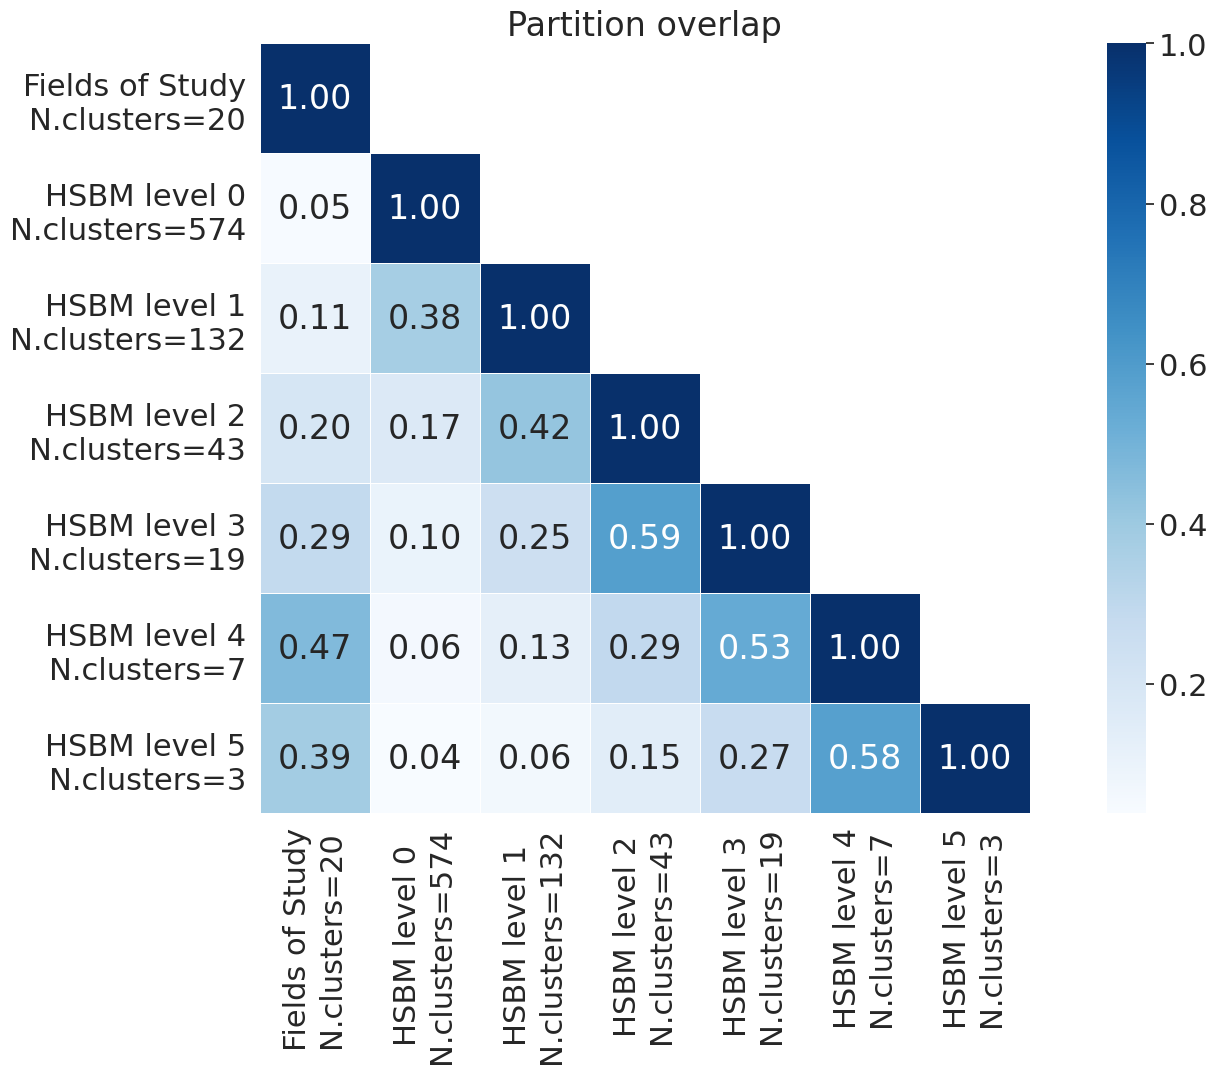

In [65]:
column_names = get_column_names(print_n_clusters = True)
if use_first_only_field == True:
    file_name = f"Partition_overlap_{min_word_occurences}_min_word_occurences_only_first_field"
else:
    file_name = f"Partition_overlap_{min_word_occurences}_min_word_occurences"
if use_titles == 1:
    file_name += "_titles"
file_path_png = paper_figures_folder + file_name + ".png"
file_path_pdf = paper_figures_folder + file_name + ".pdf"
visualise_heatmap_results(max_partition_overlap_avg, max_partition_overlap_std, column_names, 
                          r"Partition overlap", print_std = False,
                         file_path_png=file_path_png, file_path_pdf=file_path_pdf)

In [69]:
# Compute the average partition overlap and standard deviation
nmi_avg, nmi_std = construct_nmi_matrix([[h_t_doc_consensus_by_level[l]] for l in h_t_doc_consensus_by_level.keys()], true_partition_int)

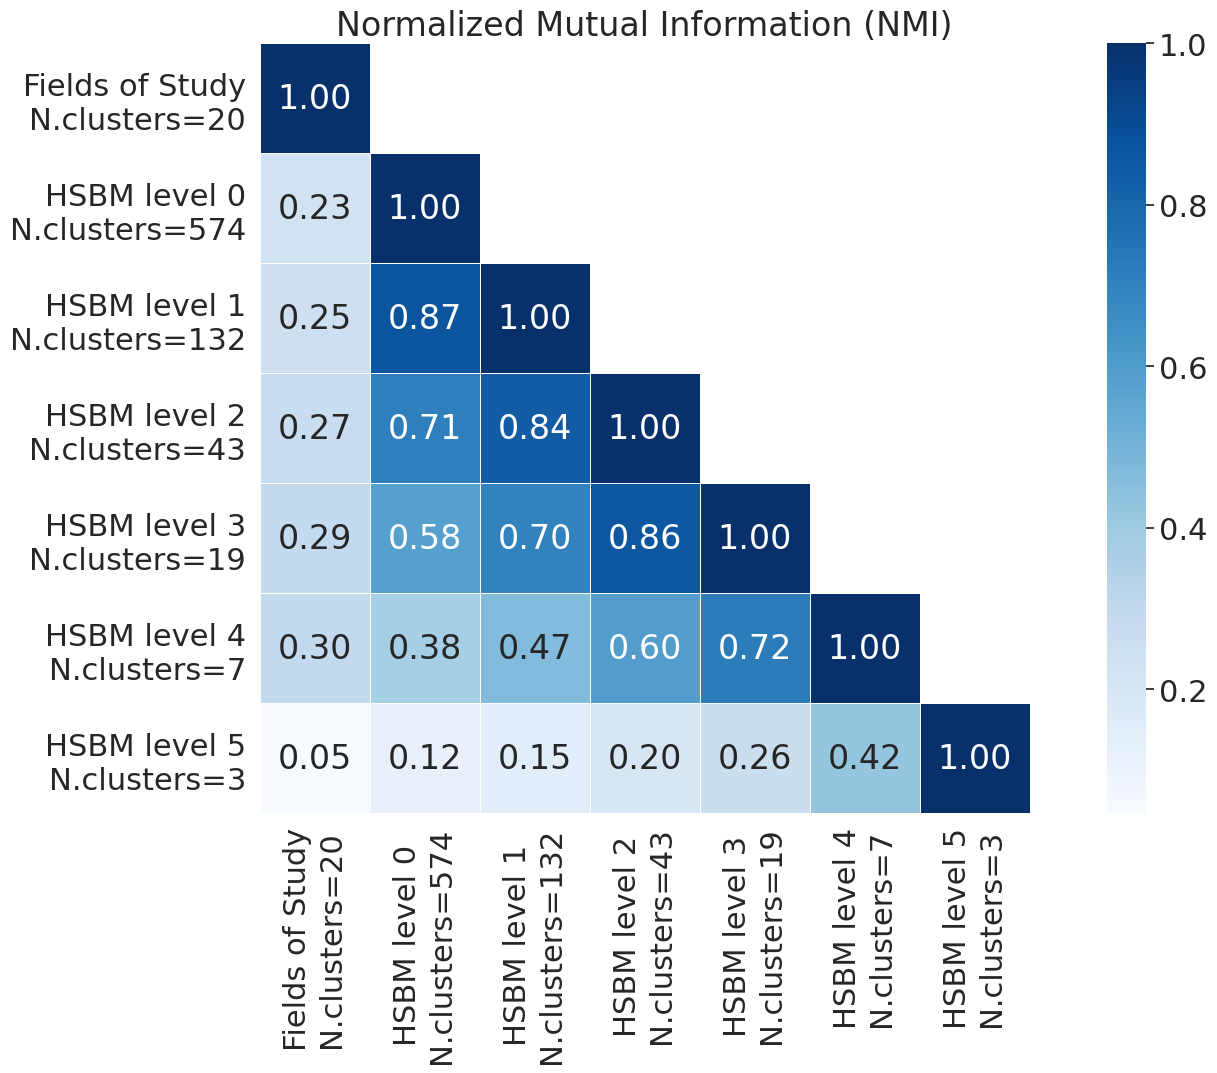

In [70]:
column_names = get_column_names(print_n_clusters = True)
if use_first_only_field == True:
    file_name = f"NMI_{min_word_occurences}_min_word_occurences_only_first_field"
else:
    file_name = f"NMI_{min_word_occurences}_min_word_occurences"
if use_titles == 1:
    file_name += "_titles"
file_path_png = paper_figures_folder + file_name + ".png"
file_path_pdf = paper_figures_folder + file_name + ".pdf"
visualise_heatmap_results(nmi_avg, nmi_std, column_names, r"Normalized Mutual Information (NMI)", print_std = False,
                         file_path_png=file_path_png, file_path_pdf=file_path_pdf)

## Topic Modelling

We now show how this framework tackles the problem of topic modelling simultaneously.

We can now retrieve the top 10 words associated to topics associated to consensus partition.topics_df_by_level

In [100]:
with gzip.open(f"{results_folder}results_fit_greedy_topic_frequency_all{filter_label}.gz","rb") as fp:
    topics_df_by_level,mixture_proportion_by_level, normalized_mixture_proportion_by_level, avg_topic_frequency_by_level = pickle.load(fp)

In [101]:
highest_non_trivial_level = sorted(topics_df_by_level.keys())[-1]
highest_non_trivial_level

5

In [102]:
print(topics_df_by_level[highest_non_trivial_level - 2].iloc[:20],flush=True)#[range(0,15)]

               0             1              2                 3   \
0        adaptive      analysis     management  decentralization   
1       detection         model    centralized        governance   
2             via         study    performance            public   
3      estimation          case    information             china   
4         vehicle   development      framework  decentralisation   
5           delay           new   distribution         education   
6           fault        impact  decentralised         political   
7       frequency           two   coordination              role   
8    transmission       problem       strategy          evidence   
9      predictive        effect    environment            reform   
10  reinforcement        theory        towards       perspective   
11        machine        change       research          national   
12    coordinated  organization         demand          politics   
13           path       central     generation  

In [221]:
print(topics_df_by_level[highest_non_trivial_level - 1].iloc[:20],flush=True)#[range(0,15)]

                0                 1                  2              3  \
0   decentralized        management  descentralización         supply   
1          system  decentralization                 em          chain   
2           based          analysis   décentralisation      consensus   
3         control             model             france     efficiency   
4         network       centralized           training           task   
5     distributed             local   descentralização  manufacturing   
6        networks             study                 na       capacity   
7           using           service              saúde        product   
8           multi              case           política     assignment   
9         systems       performance             brasil        private   
10          power           dynamic            sistema      connected   
11           data       development               caso          trade   
12       approach            policy          políti

### Normalized mixture proportion between topics and clusters

In [103]:
l = highest_non_trivial_level - 1

topic_doc_df = pd.DataFrame(normalized_mixture_proportion_by_level[l])

def _color_red_or_green(val, t = 0.1):
    if val < -t:
        color = 'red'
    elif val > t:
        color = 'green'
    else:
        color = 'grey'
    
    return 'color: %s' % color

topic_doc_df.style.applymap(_color_red_or_green,t=0.1)

,doc_group 0,doc_group 1,doc_group 2,doc_group 3,doc_group 4,doc_group 5
topic 0,0.002292,0.254244,-0.419759,-0.196493,-0.222236,0.136245
topic 1,0.669517,-0.216448,-0.798597,0.021345,-0.229550,-0.285882
topic 2,-0.129289,0.124345,-0.506640,-0.225016,0.435824,0.215658
topic 3,0.174900,-0.028216,-0.683171,0.210940,-0.220538,0.146841
topic 4,-0.621916,-0.177994,3.698085,0.436802,-0.746457,-0.618380
topic 5,1.143878,-0.431634,-0.849481,0.012059,-0.488295,-0.581773
topic 6,-0.024248,0.013174,0.073265,0.503421,-0.270264,-0.502976
topic 7,0.360140,-0.092091,-1.000000,0.257407,0.525811,-1.000000


In [157]:
l = highest_non_trivial_level - 1

topic_doc_df = pd.DataFrame(normalized_mixture_proportion_by_level[l])

def _color_red_or_green(val, t = 0.1):
    if val < -t:
        color = 'red'
    elif val > t:
        color = 'green'
    else:
        color = 'grey'
    
    return 'color: %s' % color

topic_doc_df.style.applymap(_color_red_or_green,t=0.1)

,doc_group 0,doc_group 1,doc_group 2,doc_group 3,doc_group 4,doc_group 5,doc_group 6
topic 0,0.363110,0.416046,-0.337581,-0.071123,-0.385353,0.287535,-0.142805
topic 1,-0.108542,-0.127313,0.321824,0.177208,-0.113920,0.006295,-0.406893
topic 2,-0.736456,-0.580405,-0.505194,-0.750809,1.280972,-0.773641,3.950961
topic 3,0.347560,0.361559,-0.192732,0.082939,-0.448649,0.212544,-0.381261
topic 4,-0.335525,-0.345044,0.123600,0.023220,0.683631,-0.246061,-0.481762
topic 5,0.716486,0.190328,-0.263927,-0.079649,-0.128708,-0.137436,-0.374986
topic 6,-1.000000,-0.320846,0.982205,0.301444,0.370473,-0.322651,-1.000000
topic 7,0.303410,0.037596,0.514185,0.084537,-0.162489,-0.379097,-1.000000


## Recover Hierarchy

In [104]:
with gzip.open(f"{results_folder}results_fit_greedy_topic_hierarchy_all{filter_label}.gz","rb") as fp:
    hierarchy_docs,hierarchy_words = pickle.load(fp)

In [106]:
# # Add higher layer of hierarchy words so that we have a unique root
# hierarchy_words[max(list(hierarchy_words.keys()))+1] = {0:set(list(hierarchy_words[max(list(hierarchy_words.keys()))].keys()))}

# # Add higher layer of hierarchy docs so that we have a unique root
# hierarchy_docs[max(list(hierarchy_docs.keys()))+1] = {0:set(list(hierarchy_docs[max(list(hierarchy_docs.keys()))].keys()))}

### Check hierarchy topics

In [107]:
l = highest_non_trivial_level - 2

for i in range(len(hierarchy_words[l])):
    m = min(hierarchy_words[l])
    m2 = min(hierarchy_words[l-1])

    print(f"LEVEL {l} -- TOPIC {i}")
    print(topics_df_by_level[l][i].iloc[:20],flush=True)#[range(0,15)]
    print(f"\n\nLEVEL {l-1}")
    print(topics_df_by_level[l-1][np.array(list(hierarchy_words[l][i+m])) - m2].iloc[:20],flush=True)#[range(0,15)]
    print("\n\n\n---------------------------------------------------------------------------------------\n\n\n")

LEVEL 3 -- TOPIC 0
0          adaptive
1         detection
2               via
3        estimation
4           vehicle
5             delay
6             fault
7         frequency
8      transmission
9        predictive
10    reinforcement
11          machine
12      coordinated
13             path
14          sensing
15         vehicles
16        networked
17             deep
18        connected
19         tolerant
Name: 0, dtype: object


LEVEL 2
             92            97                120           7            136  \
0      frequency  transmission         connected        motion       filter   
1     predictive        device          reactive       surface    filtering   
2    coordinated            ml          inspired      guidance       kalman   
3   compensation     assisting            immune    locomotion   sequential   
4            mpc           NaN             loads  observations        range   
5        damping           NaN      biologically       walking    partiall

In [161]:
l = highest_non_trivial_level - 1

for i in range(len(hierarchy_words[l])):
    m = min(hierarchy_words[l])
    m2 = min(hierarchy_words[l-1])

    print(f"LEVEL {l} -- TOPIC {i}")
    print(topics_df_by_level[l][i].iloc[:20],flush=True)#[range(0,15)]
    print(f"\n\nLEVEL {l-1}")
    print(topics_df_by_level[l-1][np.array(list(hierarchy_words[l][i+m])) - m2].iloc[:20],flush=True)#[range(0,15)]
    print("\n\n\n---------------------------------------------------------------------------------------\n\n\n")

LEVEL 4 -- TOPIC 0
0     decentralized
1            system
2             based
3           control
4           network
5       distributed
6          networks
7             using
8             multi
9           systems
10            power
11             data
12         approach
13           energy
14         wireless
15       blockchain
16           design
17           sensor
18            agent
19        algorithm
Name: 0, dtype: object


LEVEL 3
                13            15             0               3   \
0          control         power         scheme            data   
1            multi        energy     scheduling      blockchain   
2            agent  distribution     autonomous          access   
3           robust        demand           load           cloud   
4       controller    generation         hybrid       computing   
5            robot     treatment        channel            peer   
6              via       voltage        vehicle        security   
7       esti

# Sampling articles

In [108]:
paper2fields = {}
paper2year = {}
for paper_id, paper in all_docs_dict.items():
    paper2year[paper_id] = paper["year"] if "year" in paper else None
    paper2fields[paper_id] = paper["fieldsOfStudy"] if "fieldsOfStudy" in paper and paper["fieldsOfStudy"] is not None else []

In [109]:
def get_most_represented_topic(level_partition, partition, level_topic):
    if level_topic >= max(list(hierarchy_words.keys())):
        return 0
    else:
        p = partition
        p_remapped = doc_partition_remapping_by_level[level_partition][p]
    #     print(print_color.UNDERLINE + print_color.BOLD + print_color.RED + "PARTITION %d\n"%(p_remapped) + print_color.END)
        tmp = pd.Series({key:value for key,value in normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition][level_topic]["doc_group %d"%p_remapped].items() if topics_df_by_level[level_topic][int(key[6:])].notna().sum()>0}).sort_values(ascending=False)

        return int(tmp.index[0][6:])

In [110]:
def name_node(level, index, list_labels = [], num_spaces = 200):
    if len(list_labels) == 0:
        return f"{level}_{index}"
    else:
        string = f"" # f"{level}_{index}"
        for _ in list_labels:
            string += "\n" + " "*num_spaces + "%s"%_ + " "*num_spaces
        return string

In [111]:
def topic_mixture_proportion(dict_groups,edited_text, document_partitions):

    topics = dict_groups.keys()
    partitions = np.unique(document_partitions)

    avg_topic_frequency = {}
    mixture_proportion = {}
    normalized_mixture_proportion = {}

    doc_texts = np.array(edited_text, dtype=object)

    n_i_t = {}

    topic_doc_group_words = {}

    for doc_group in partitions:
        topic_doc_group_words[doc_group] = set()
        for i,doc_group_membership in enumerate(document_partitions):
            if doc_group_membership != doc_group:
                continue
            topic_doc_group_words[doc_group] = topic_doc_group_words[doc_group].union(set(edited_text[i]))

    for topic in topics:
        topic_words = set([x[0] for x in dict_groups[topic]])
        n_i_t[topic] = {}

        for doc_group in partitions:
            n_i_t[topic][doc_group] = len(topic_words.intersection(topic_doc_group_words[doc_group]))

    for doc_group in partitions:
        mixture_proportion[f"doc_group {doc_group}"] = {}
        for topic in topics:
            mixture_proportion[f"doc_group {doc_group}"][f"topic {topic}"] = n_i_t[topic][doc_group] / np.sum([n_i_t[topic_j][doc_group] for topic_j in topics])

    S = np.sum([n_i_t[topic_j][doc_group] for doc_group in partitions for topic_j in topics])
    for topic in topics:
        avg_topic_frequency[f"topic {topic}"] = np.sum([n_i_t[topic][doc_group] for doc_group in partitions]) / S

    for doc_group in partitions:
        normalized_mixture_proportion[f"doc_group {doc_group}"] = {}
        for topic in topics:
            normalized_mixture_proportion[f"doc_group {doc_group}"][f"topic {topic}"] = ( mixture_proportion[f"doc_group {doc_group}"][f"topic {topic}"] - avg_topic_frequency[f"topic {topic}"] ) / avg_topic_frequency[f"topic {topic}"]

    return mixture_proportion, normalized_mixture_proportion, avg_topic_frequency

In [112]:
try:
    with gzip.open(f"{results_folder}/results_fit_greedy_topic_frequency_all_by_level_partition_by_level_topics{filter_label}_all.gz","rb") as fp:
        topics_df_by_level,mixture_proportion_by_level_partition_by_level_topics, normalized_mixture_proportion_by_level_partition_by_level_topics, avg_topic_frequency_by_level_partition_by_level_topics = pickle.load(fp)
except FileNotFoundError:
    
    
    
    with gzip.open(f"{results_folder}/results_fit_greedy_partitions_consensus_all{filter_label}.gz","rb") as fp:
        h_t_doc_consensus_by_level, h_t_word_consensus_by_level, h_t_consensus_summary_by_level = pickle.load(fp)



    def get_topics_h_t_consensus_model(groups, words, n=10):
        """
        Retrieve topics in consensus partition for H+T model.
        """
        dict_groups = groups
        Bw = dict_groups['Bw'] # number of word-groups
        p_w_tw = dict_groups['p_w_tw'] # topic proportions over documents
        words = words
        # Loop over all word-groups
        dict_group_words = {}
        for tw in range(Bw):
            p_w_ = p_w_tw[:, tw]
            ind_w_ = np.argsort(p_w_)[::-1]
            list_words_tw = []
            for i in ind_w_[:n]:
                if p_w_[i] > 0:
                    list_words_tw+=[(words[i],p_w_[i])]
                else:
                    break
            dict_group_words[tw] = list_words_tw
        return dict_group_words    

    g_words = [ hyperlink_text_hsbm_states[0].g.vp['name'][v] for v in  hyperlink_text_hsbm_states[0].g.vertices() if hyperlink_text_hsbm_states[0].g.vp['kind'][v]==1   ]

    # THIS IS ONLY FOR MAXIMUM LEVEL, USELESS
    # dict_groups = get_topics_h_t_consensus_model(h_t_consensus_summary, g_words, n=1000000)
    dict_groups_by_level = {l:get_topics_h_t_consensus_model(h_t_consensus_summary_by_level[l], g_words, n=1000000) for l in h_t_doc_consensus_by_level.keys()}
    
    
    
    
    
    
    mixture_proportion_by_level_partition_by_level_topics, normalized_mixture_proportion_by_level_partition_by_level_topics, avg_topic_frequency_by_level_partition_by_level_topics = {}, {}, {}
    # level_partition = 3
    for level_partition in tqdm(range(6)):
        mixture_proportion_by_level_partition_by_level_topics[level_partition], normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition], avg_topic_frequency_by_level_partition_by_level_topics[level_partition] = {}, {}, {}
        for l in range(6):
            mixture_proportion_by_level_partition_by_level_topics[level_partition][l], normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition][l], avg_topic_frequency_by_level_partition_by_level_topics[level_partition][l] = \
                topic_mixture_proportion(dict_groups_by_level[l],ordered_edited_texts,h_t_doc_consensus_by_level[level_partition])

    with gzip.open(f"{results_folder}/results_fit_greedy_topic_frequency_all_by_level_partition_by_level_topics{filter_label}_all.gz","wb") as fp:
        pickle.dump((topics_df_by_level,mixture_proportion_by_level_partition_by_level_topics, normalized_mixture_proportion_by_level_partition_by_level_topics, avg_topic_frequency_by_level_partition_by_level_topics),fp)

  0%|          | 0/1 [00:00<?, ?it/s]

In [113]:
def get_mixture_proportion(level_partition, partition, level_topic, topic):
    if level_topic >= max(list(hierarchy_words.keys())):
        m2 = min(hierarchy_words[max(list(hierarchy_words.keys()))][0])
        return np.max([get_mixture_proportion(level_partition, partition, max(list(hierarchy_words.keys()))-1, t-m2) for t in hierarchy_words[max(list(hierarchy_words.keys()))][0]])
    p_remapped = doc_partition_remapping_by_level[level_partition][partition]
#     m = min(hierarchy_words[level_topic])
    if topics_df_by_level[level_topic][topic].notna().sum() < 10:
        mixture_proportion = -1
    else:
        mixture_proportion = normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition][level_topic][f"doc_group {p_remapped}"][f"topic {topic}"]
#     if mixture_proportion <= 0:
#         return 0.001
#     else:
#         return mixture_proportion
    return mixture_proportion

In [114]:
def create_hierarchy_network(level_partition, partition, top_level_topics, bottom_level_topics, 
                             max_num_topics_to_represent, num_words_to_represent, ax,
                             multiplicator_size_nodes=1, multiplicator_size_edges=1,
                             multiplicator_ypos=0.1,
                             fontsize = 10):
    if level_partition > max(list(hierarchy_words.keys())):
        level_partition = max(list(hierarchy_words.keys())) + 1
    cmap = matplotlib.cm.get_cmap('coolwarm')#('winter') coolwarm
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom blue', ['red','gray'], N=256)
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = get_most_represented_topic(level_partition, partition, top_level_topics)
#     print(root)
    root_name = name_node(top_level_topics,root)
    node_size[root_name] = get_mixture_proportion(level_partition, partition, top_level_topics, root) * multiplicator_size_nodes
    G.add_node(root_name)
    
            

    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level_topics:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level_topics, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = get_mixture_proportion(level_partition, partition, l-1, child) * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    node_size = {x:y - min_node_size_old + multiplicator_size_nodes*0.05 for x,y in node_size.items()}
    min_node_size = min(list(node_size.values()))
    max_node_size = max(list(node_size.values()))
    
    
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level_topics+1,top_level_topics+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level_topics:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_words[l])
                m2 = min(hierarchy_words[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_words[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
                    if node_size_old[child_name] > 0:
                        leaves[child_name] = node_size_old[child_name]
#             highlighted_leaves = set(pd.Series(leaves).sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            sum_weights_children = 0
#             sum_weights_children_highlighted = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
#             node_colors[father_name] = cmap(0)
            for child in children:    
                child_name = name_node(l-1,child)
                if l-1 == bottom_level_topics:
                    if child_name in highlighted_leaves:
                        # let's substitute the name of the nodes
                        significant_string = ""
#                         flag = False
                        for _ in range(min(4,int(node_size_old[child_name]/multiplicator_size_nodes))):
                            significant_string += "*"
#                             flag = True
#                         if flag == True:
                        list_labels = [significant_string] + list(topics_df_by_level[l-1][child].iloc[:num_words_to_represent].values)
#                         else:
#                             list_labels = list(topics_df_by_level[l-1][child].iloc[:num_words_to_represent].values)
                        new_child_name = name_node(l-1,child, list_labels = list_labels)
                        node_size[new_child_name] = node_size[child_name]
                        del node_size[child_name]
                        highlighted_leaves.remove(child_name)
                        highlighted_leaves.add(new_child_name)
                        child_name = new_child_name
#                         node_colors[child_name] = 1.
#                         sum_weights_children_highlighted += node_size[child_name]
#                         node_colors[father_name] = "blue"
#                     else:
#                         node_colors[child_name] = 0.
                    node_colors[child_name] = (node_size[child_name]-min_node_size)/(max_node_size-min_node_size)
#                 elif node_colors[child_name] == "blue":
#                     node_colors[father_name] = "blue"
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            node_colors[father_name] = np.sum([node_colors[child_name]*node_size[child_name] for child_name in child_names])/sum_weights_children
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level_topics+1:
                    edge_size[(father_name,child_name)] = node_size[child_name] * multiplicator_size_edges
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] / edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
            
    
    # DRAWING
    pos = graphviz_layout(G, prog='dot')#{"fontsize":fontsize, "labelfontsize":fontsize})
#     return pos
    y_pos = sorted(list(set([_[1] for _ in list(pos.values())])))

    y_pos_max = y_pos[-1]
    y_pos_min = y_pos[0]
    y_pos_min_new = y_pos_min + (y_pos_max-y_pos_min)*multiplicator_ypos
    y_pos_dict = {y_pos_min:y_pos_min_new, y_pos_max:y_pos_max}
    no_mid_y = len(y_pos[1:-1])
    for index,y in enumerate(y_pos[1:-1]):
        y_pos_dict[y] = y_pos_min_new + (y_pos_max - y_pos_min_new)/(no_mid_y+1)*(index+1)
    for k,v in pos.items():
        pos[k] = (v[0],y_pos_dict[v[1]])
#     print(pos,"\n\n")
#     print(node_colors)
    nx.draw_networkx_nodes(G,pos,node_size=[node_size[node] for node in pos.keys()],ax=ax,node_color=[cmap(node_colors[node]) for node in pos.keys()])
    l = nx.draw_networkx_labels(G,pos,font_size=fontsize, font_color = 'black', font_family="STIXGeneral", labels={x:x.replace(" nan ","").replace(" ","") if len(x)>10 else "" for x in pos.keys()}, verticalalignment="top",  ax=ax)

    for i,edge in enumerate(G.edges()):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge_size[edge], arrowsize=edge_size[edge]*5,edge_color = cmap(node_colors[edge[1]]),ax=ax)#arrowstyle='fancy')
#             else:
#                 nx.draw_networkx_edges(G, pos, edgelist=[edge], width=weights[i], arrowsize=arrowsize_list[i],edge_color = 'grey',ax=ax)#arrowstyle='fancy')

#     for node in G.nodes:
#         if (node, node) in G.edges:
#             draw_self_loop(point=pos[node], color="grey", alpha=1, linewidth=G[node][node]['weight']*rescaling_factor_edge_width,ax=ax,padding=1.25,arrowsize=arrowsize_dict[node][node])

    
#     import seaborn as sn
#     sn.despine(left=False,bottom=False,ax=ax)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    ax.axis('off')
    pos_y_values = [_[1] for _ in pos.values()]
    ax.set_ylim([min(pos_y_values)*0,max(pos_y_values)*1.05])
#     ax.set_title("Level %d: Partition %d"%(level_partition, partition))
#     plt.autoscale()
#     fig.tight_layout()
    return cmap, min_node_size_old/multiplicator_size_nodes, max_node_size_old/multiplicator_size_nodes
    

## Other functions

In [115]:
year_cluster_field_no_papers_df_by_level = {}
for level in tqdm(name2partition_by_level.keys()):
# level = 2
    dict_nested = {}
    for paper_id,cluster in name2partition_by_level[level].items():
        paper = all_docs_dict[paper_id]
        year = paper["year"]
        if year is not None:
            for field in paper["fieldsOfStudy"]:
    #             dict_nested.setdefault(year,{}).setdefault(cluster,{}).setdefault(field,0) 
                dict_nested.setdefault(field,{}).setdefault(cluster,{y:0 for y in range(1950,2022)})
                dict_nested[field][cluster].setdefault(year,0) 
                dict_nested[field][cluster][year] += 1./len(paper["fieldsOfStudy"])

    dict_for_df = {"year":[], "cluster":[], "field":[], "no_papers":[]}
    for field,_ in dict_nested.items():
        for cluster,_2 in _.items():
            for year,no_papers in _2.items():
                dict_for_df["year"].append(int(year))
                dict_for_df["cluster"].append(cluster)
                dict_for_df["field"].append(field)
                dict_for_df["no_papers"].append(no_papers)
    year_cluster_field_no_papers_df_by_level[level] = pd.DataFrame(dict_for_df)    

  0%|          | 0/7 [00:00<?, ?it/s]

In [116]:
def heatmap(df,fixed_labels, x_label, y_label, values_label,costrains_equal={}, 
            fig=None,ax=None,ax_cmap=None,subplot_spec=None,subplot_spec_heatmap=None,figsize=(12,6),
            filename="",
            ordered_cluster_labels = [],
            ordered_cluster_groups = [],
            linewidth=1,
            cut_small_clusters = False,
            threshold_num_papers = 1,
            do_barplot = True,
            vmax = None,
            colorbar_log = False,
           ):
    '''
        - fixed_labels_and_values_dict is a dict with the key of df to fix and his values to select!
        - If subplot_spec is not None, it must be a valid subplot_spec from gridspec, to position correctly the heatmap in the bigger picture. If this is provided, a fig must be provided to put it there.
        - if cut_small_clusters == True, remember to change threshold_num_papers
        - ACHTUNG! use cut_small_clusters and threshold_num_papers only when clusters are on y_axis
    '''
    class SeabornFig2Grid():

        def __init__(self, seaborngrid, fig,  subplot_spec):
            self.fig = fig
            self.sg = seaborngrid
            self.subplot = subplot_spec
            if isinstance(self.sg, sn.axisgrid.FacetGrid) or \
                isinstance(self.sg, sn.axisgrid.PairGrid):
                self._movegrid()
            elif isinstance(self.sg, sn.axisgrid.JointGrid):
                self._movejointgrid()
            self._finalize()

        def _movegrid(self):
            """ Move PairGrid or Facetgrid """
            self._resize()
            n = self.sg.axes.shape[0]
            m = self.sg.axes.shape[1]
            self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
            for i in range(n):
                for j in range(m):
                    self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

        def _movejointgrid(self):
            """ Move Jointgrid """
            h= self.sg.ax_joint.get_position().height
            h2= self.sg.ax_marg_x.get_position().height
            r = int(np.round(h/h2))
            self._resize()
            self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

            self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
            self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
            self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

        def _moveaxes(self, ax, gs):
            #https://stackoverflow.com/a/46906599/4124317
            ax.remove()
            ax.figure=self.fig
            self.fig.axes.append(ax)
            self.fig.add_axes(ax)
            ax._subplotspec = gs
            ax.set_position(gs.get_position(self.fig))
            ax.set_subplotspec(gs)

        def _finalize(self):
            plt.close(self.sg.fig)
            self.fig.canvas.mpl_connect("resize_event", self._resize)
            self.fig.canvas.draw()

        def _resize(self, evt=None):
            self.sg.fig.set_size_inches(self.fig.get_size_inches())

    keywords_clusters = annotated_keyword_clusters(threshold_num_papers=1)
    keywords_clusters = get_keywords_hierachy(keywords_clusters, 6, 0, hierarchy_docs, no_words=20,threshold_num_papers = 1)
    if cut_small_clusters:
        keywords_clusters = annotated_keyword_clusters(threshold_num_papers=threshold_num_papers)
        keywords_clusters = get_keywords_hierachy(keywords_clusters, 6, 0, hierarchy_docs, no_words=20,threshold_num_papers = threshold_num_papers)

    ordered_hierarchy_lev = {x:[] for x in [3,4,5]}
    ordered_hierarchy_lev[2] = [(x,()) for x in ordered_lev2_clusters]
    for l in [3,4,5]:
        for c in [x[0] for x in ordered_hierarchy_lev[l-1]]:
            for c3 in hierarchy_docs[l].keys():
                if c in hierarchy_docs[l][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev[l]]:
                    ordered_hierarchy_lev[l].append((c3,hierarchy_docs[l][c3]))

    for l in [4,5]:
        lev2_children = {x:[] for x in hierarchy_docs[l].keys()}
        for c,children in ordered_hierarchy_lev[l]:
            for child in children:
                for tmp in ordered_hierarchy_lev[l-1]:
                    if tmp[0] == child:
                        lev2_children[c] += list(tmp[1])
        ordered_hierarchy_lev[l] = [(x,lev2_children[x]) for x in [t[0] for t in ordered_hierarchy_lev[l]]]  
    
#     ordered_hierarchy_lev_3 = []
#     for c in ordered_lev2_clusters:
#         for c3 in hierarchy_docs[3].keys():
#             if c in hierarchy_docs[3][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_3]:
#                 ordered_hierarchy_lev_3.append((c3,hierarchy_docs[3][c3]))
    
    df_costrained_equal = df.copy()
    for key,value in costrains_equal.items():
        df_costrained_equal = df_costrained_equal.loc[df_costrained_equal[key].isin(value)]
    df_costrained_equal = df_costrained_equal.groupby([x_label,y_label],as_index=False)[values_label].sum()
    df_tmp = df_costrained_equal[[x_label, y_label, values_label]]
    matrix = df_tmp.pivot(index=y_label, columns=x_label, values=values_label).fillna(0)
    
    if len(ordered_cluster_labels)>0 and y_label in ["cluster","cluster_from", "cluster_to"]:
        matrix = matrix.loc[ordered_cluster_labels]
        if x_label in ["cluster","cluster_from", "cluster_to"]:
            matrix = matrix[ordered_cluster_labels]
    if cut_small_clusters and y_label in ["cluster","cluster_from", "cluster_to"]:
        matrix = matrix.loc[np.array([True if len(keywords_clusters[2][x]) > 0 else False for x in matrix.index.values])].copy()
        if x_label in ["cluster","cluster_from", "cluster_to"]:
            matrix = matrix[np.array([x for x in matrix.columns if len(keywords_clusters[2][x]) > 0])].copy()
        
        
    if cut_small_clusters:
        width_figsize = figsize[0]
        height_figsize = figsize[1]
        n = len(matrix)
        figsize = (width_figsize, 2 + n/40 * (height_figsize - 2))
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
            figsize = (3 + n/40 * (width_figsize-3), 2 + n/40 * (height_figsize - 2))
        
    if fig is None:
        fig = plt.figure(figsize = figsize)
        ax = plt.gca()
        sn.despine(left=True,bottom=True,ax=ax)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if subplot_spec is None:
            subplot_spec = gridspec.GridSpec(nrows=1, ncols=2,wspace=.03,width_ratios=[20,1])
            subplot_spec_heatmap = subplot_spec[0]
        if do_barplot:
            ax = plt.Subplot(fig, subplot_spec[0])
            ax_cmap = plt.Subplot(fig, subplot_spec[1])

        
    else:
        if subplot_spec_heatmap is None:
            subplot_spec = gridspec.GridSpec(nrows=1, ncols=2,wspace=.03,width_ratios=[20,1])
            subplot_spec_heatmap = subplot_spec[0]
        if ax is None:
            ax = plt.Subplot(fig, subplot_spec[0])
        if ax_cmap is None:
            ax_cmap= plt.Subplot(fig, subplot_spec[1])
            

    D = len(matrix.columns.values)
    H = len(matrix.index.values)
    vmin = matrix.min().min()
    if vmax is None:
        vmax = matrix.max().max()
    if do_barplot:
        g = sn.jointplot(data=df_tmp, ax=ax,
                     x=x_label, y=y_label, kind="hist")
        g.ax_marg_y.cla()
        g.ax_marg_x.cla()
        sn.despine(left=True,bottom=True,ax=ax_cmap)
        ax_cmap.get_xaxis().set_visible(False)
        ax_cmap.get_yaxis().set_visible(False)
        ax_joint = g.ax_joint
        #     sn.heatmap(data=matrix, ax=g.ax_joint, cbar=True,cbar_ax=ax_cmap,cbar_kws={"shrink":0.5,"pad":0.,"drawedges":True})#, cmap='Blues')
    #     cb.outline.set_edgecolor('white')
    #     if not cut_small_clusters:
    #         g.ax_marg_y.barh(np.arange(0.5, H), df_tmp.groupby([y_label])[values_label].sum().to_numpy(), color='navy')
    #         g.ax_marg_x.bar(np.arange(0.5, D), df_tmp.groupby([x_label])[values_label].sum().to_numpy(), color='navy')
        g.ax_marg_y.barh(np.arange(0.5, H), matrix.sum(axis=1).to_numpy(), color='navy')
        g.ax_marg_x.bar(np.arange(0.5, D), matrix.sum(axis=0).to_numpy(), color='navy')
    else:
        ax_joint = ax
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
            vmin = 0
            vmax = 5

    if colorbar_log == False:
        sn.heatmap(data=matrix, ax=ax_joint, cmap="magma",cbar=False,vmin=vmin,vmax=vmax,rasterized=True)#, cmap='Blues')
    else:
        matrix = matrix.applymap(lambda x: np.log(max(1,x)))
        vmin_log = matrix.min().min()
        vmax_log = matrix.max().max()
        sn.heatmap(data=matrix, ax=ax_joint, cmap="magma",cbar=False,vmin=vmin_log,vmax=vmax_log,rasterized=True)#, cmap='Blues')
    if do_barplot:
        if colorbar_log == False:
            cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=0.5,pad=0., fraction=1)
        else:
            vmin = max(vmin,1)
            cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=0.5,pad=0., fraction=1)

    
    if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
        ax_joint.set_xticks(np.arange(0.5, D))
        ax_joint.set_xticklabels(matrix.columns, rotation=0)
    ax_joint.set_yticks(np.arange(0.5, H))
    ax_joint.set_yticklabels(matrix.index.values, rotation=0)
    ax_joint.set_xlabel("")
    ax_joint.set_ylabel("")

    if do_barplot:
        # remove ticks between heatmap and histograms
        g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
        g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
        # remove ticks showing the heights of the histograms
        g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
        g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

        # remove ticks in the histograms
        # sn.despine(left=True,bottom=True,ax=g.ax_marg_x)
        g.ax_marg_x.get_xaxis().set_visible(False)
        g.ax_marg_x.get_yaxis().set_visible(False)
        # sn.despine(left=True,bottom=True,ax=g.ax_marg_y)
        g.ax_marg_y.get_xaxis().set_visible(False)
        g.ax_marg_y.get_yaxis().set_visible(False)
    
    
    # g.fig.set_size_inches(20, 8)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    # g.fig.subplots_adjust(hspace=0.0, wspace=0.0)  # less spaced needed when there are no tick labels

#     gs = gridspec.GridSpec(1, 2,width_ratios=[20,1],wspace=0)#,height_ratios=[1.5,3])

    if do_barplot:
        mg0 = SeabornFig2Grid(g, fig, subplot_spec_heatmap)
        ax_joint = mg0.sg.ax_joint
#     mg1 = SeabornFig2Grid(cbar, fig, subplot_spec[1])
    # mg2 = sfg.SeabornFig2Grid(g2, fig, gs[3])
    # mg3 = sfg.SeabornFig2Grid(g3, fig, gs[2])
    
#     fig.tight_layout(rect=(0.05, 0.1, 0.6, 0.6))#,h_pad=2,w_pad=0.55,pad=3)

#     fig.add_subplot(ax)
    
#     plt.show()
    
        
    line_color = {3:"white",4:"white",5:"red"}
    line_width = {3:linewidth,4:linewidth+2,5:linewidth+3}
    line_style = {3:"--",4:"-",5:"-"}
              
    if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
        for lev in [3,4,5]:
            y_h = 0
            filtered_ordered_cluster_groups = ordered_hierarchy_lev[lev].copy()
            if len(filtered_ordered_cluster_groups)>0:
                for j,g in enumerate(filtered_ordered_cluster_groups[:]): 
                    tmp = g[1]
                    if cut_small_clusters:
                        tmp = [x for x in g[1] if len(keywords_clusters[2][x]) > 0]
                    if len(tmp) == 0:
                        continue
                    if y_h != 0:
                        ax_joint.plot([y_h,y_h+len(tmp)],[y_h,y_h],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                        ax_joint.plot([y_h,y_h],[y_h,y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    ax_joint.plot([y_h,y_h+len(tmp)],[y_h+len(tmp),y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    ax_joint.plot([y_h+len(tmp),y_h+len(tmp)],[y_h,y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
#                     if lev == 3:
#                         delta_y = 0.7
#                         delta_y = len(g[1])/2
#                         txt = keywords_clusters[3][g[0]]
#                         words = txt.split("\n")
#                         txt = ""
#                         flag = False
#                         for i,word in enumerate(words):
#                             if len(txt+word)>100:
#                                 txt+="\n"
#                                 break
#                             txt += word + u' \u2212 '
#                         if i<len(words)-1:
#                             for word in words[i:]:
#                                 txt += word + u' \u2212 '
#                         txt = txt[:-3]
#                         mg0.sg.ax_joint.text(1,y_h+delta_y,txt,color='white',verticalalignment = 'center', fontsize = 15,alpha=.8)
                    y_h += len(tmp)#/len(ordered_cluster_labels)

        
#         # Uncomment if you want ticks on the right as well.
#         # ACHTUNG: They don't move with the rect of tight_layout, so it must be manually set with a precise rect
#         ax2 = mg0.sg.ax_joint.twinx()
#         ax2.grid(visible=False)
#         sn.despine(left=True,bottom=True,ax=ax2)
#         ax2.get_xaxis().set_visible(False)
#         ax2.yaxis.set_label_position("right")
#         ax2.yaxis.tick_right()
#         ax2.set_yticks(np.arange(H-0.5, 0,-1))
#         ax2.set_ylim(0,H)
#         ax2.set_yticklabels(matrix.index.values, rotation=0)




    elif y_label=="cluster" or y_label=="cluster_from" or y_label=="cluster_to":
        for lev in [3,4,5]:
            y_h = 0
            filtered_ordered_cluster_groups = ordered_hierarchy_lev[lev].copy()
            if len(filtered_ordered_cluster_groups)>0:
        #         ax.hlines([y_h], *ax.get_xlim(),color='white',zorder=10000,lw=100)
                for j,g in enumerate(filtered_ordered_cluster_groups[:]): 
        #             print(g)
                    tmp = g[1]
                    if cut_small_clusters:
                        tmp = [x for x in g[1] if len(keywords_clusters[2][x]) > 0]
                    if len(tmp) == 0:
                        continue
                    if y_h != 0:
                        ax_joint.axhline(y_h,zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    if lev == 3:
                        delta_y = 0.7
                        delta_y = len(tmp)/2
                        txt = keywords_clusters[3][g[0]]
                        words = txt.split("\n")
                        txt = ""
                        flag = False
                        for i,word in enumerate(words):
                            if len(txt+word)>100:
                                txt+="\n"
                                break
                            txt += word + u' \u2212 '
                        if i<len(words)-1:
                            for word in words[i:]:
                                txt += word + u' \u2212 '
                        txt = txt[:-3]
                                    
                        ax_joint.text(1,y_h+delta_y,txt,color='white',verticalalignment = 'center', fontsize = 15,alpha=.8)
        #             ax.text()
                    y_h += len(tmp)#/len(ordered_cluster_labels)
        #             print(y_h)
        
        
# #     if y_label=="cluster" or y_label=="cluster_from" or y_label=="cluster_to":
# #         g.ax_joint.yaxis.tick_right()
#         ax2 = mg0.sg.ax_joint.twinx()
#         ax2.grid(visible=False)
#         sn.despine(left=True,bottom=True,ax=ax2)
#         ax2.get_xaxis().set_visible(False)
# #         ax2.get_yaxis().set_visible(False)
# #         ax2.set_ylabel('foo')
# #         ax2.yaxis.set_visible(False)
#         ax2.yaxis.set_label_position("right")
#         ax2.yaxis.tick_right()
#         ax2.set_yticks(np.arange(H-0.5, 0,-1))
# #         ax2.set_yticks(np.arange(H-0.5, 0.5,-(len(matrix.index.values)-1/2)/len(matrix.index.values)))
#         ax2.set_ylim(0,H)
#         ax2.set_yticklabels(matrix.index.values, rotation=0)
# #         ax2.yaxis.set_tick_params(length=10)
# #         ax2.yaxis.set_tick_params(pad=20,length=0)
# #         ax2.yaxis.set_tick_params(pad=15)
# #         ax2.axis("off")
        
# #         ax2.plot([0,1],[0,1])
# #         mg02 = SeabornFig2Grid(ax2, fig, subplot_spec_heatmap)
# #     fig.add_subplot(ax_cmap)
    rect = (0,0,1,1)
    
                                                        
    
    if do_barplot:
        if (x_label=="year" and y_label=="cluster") or (x_label=="year_from" and y_label=="cluster_from") or (x_label=="year_from" and y_label=="cluster_to"):
    #         fig.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            n = len(matrix)
            y_min =  -0.025/21 * n + 0.09 # 0.04 : 40 , 0.065 : 19
            rect = (0.015,y_min,1,1)
        elif (x_label=="year" and y_label=="field") :
    #         fig.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            rect=(0.115,0.065,1,1)
        elif (x_label=="year_from" and y_label=="from_to"):
    #         fig.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            rect=(0.05,0.04,1,1)
        if x_label=="cluster" and y_label=="field":
    #         plt.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            ax_joint.set_xticks(np.array(df_tmp[x_label].unique())+0.5)
            ax_joint.set_xticklabels(df_tmp[x_label].unique())
            rect=(0.115,0.025,1,1)
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
    #         n = len(matrix)
    #         y_min =  -0.025/21 * n + 0.09 # 0.04 : 40 , 0.065 : 19
            rect=(0.0135,0.013,1,1)
    #     sn.heatmap(year_cluster_field_no_papers_df,)
    #     if ax is not None and ax_cmap is not None:
    #         return None
    #     else:
    #     fig.add_subplot(ax)
    #     fig.add_subplot(ax_cmap)

        fig.tight_layout(rect=rect)
    else:
        fig.tight_layout()

#     ax_cmap.set_position([1.1,1.1,0.1,0.8])
    
    if len(filename)>0:
        os.makedirs(os.path.dirname(filename),exist_ok=True)
        fig.savefig(filename,bbox_inches=None,)#,bbox_inches = matplotlib.transforms.Bbox.from_extents(*rect))#
        
    if do_barplot:
        return fig
    else:
        fig.add_subplot(ax)
        return fig,ax

In [117]:
def topics_to_print(level_partition,partition,top_level_topics, bottom_level_topics, max_num_topics_to_represent):
    
    node_size = {}
    root = get_most_represented_topic(level_partition, partition, top_level_topics)
#     print(root)
    root_name = name_node(top_level_topics,root)
#     print(root_name)
    node_size[root_name] = get_mixture_proportion(level_partition, partition, top_level_topics, root)
#     G.add_node(root_name)
    
            

    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level_topics:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level_topics, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = get_mixture_proportion(level_partition, partition, l-1, child)
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    node_size = {x:y - min_node_size_old  for x,y in node_size.items()}
    min_node_size = min(list(node_size.values()))
    max_node_size = max(list(node_size.values()))
    
    
    edge_size_sum = {}
    node_colors = {}
    
    # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
    
    l = bottom_level_topics + 1
    leaves = {}
    for i in selected_nodes_by_level[l]:
        m = min(hierarchy_words[l])
        m2 = min(hierarchy_words[l-1])
        # topics at lower level in the hierarchy from the superior node
        children = np.array(list(hierarchy_words[l][i+m])) - m2
        for child in children:
            child_name = name_node(l-1,child)
            if node_size_old[child_name] > 0:
                leaves[child_name] = node_size_old[child_name]
    leaves = pd.Series(leaves)
    highlighted_leaves = list(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
        
    return [int(x[2:]) for x in highlighted_leaves]

In [119]:
year_cluster_field_no_papers_df_by_level[3][year_cluster_field_no_papers_df_by_level[3].cluster == 12].no_papers.max()

55.33333333333333

In [120]:
def analyse_cluster_supernew(lev = 3, top_level_topics=6, bottom_level_topics=2, partition=0, centralities_to_print=[],
                             num_most_frequent_words = 100, num_papers_to_show = 3, max_num_topics_to_represent = 5,
                             threshold = 1, time_window = 10, remove_duplicates = False, do_sample_knowledge_flow = True,
                             multiplicator_size_nodes=50, multiplicator_size_edges=0.05, multiplicator_ypos=0.1, fontsize_graph=10,
                             colorbar_log_heatmap=True):
    """ADDED HEATMAP INSTEAD OF BARPLOT OF FIELDS REPRESENTATION
    TWO DIFFERENT FIGURES"""

    p = partition
    p_remapped = doc_partition_remapping_by_level[lev][p]
    print(print_color.UNDERLINE + print_color.BOLD + print_color.RED + "LEVEL %d - CLUSTER %d\n"%(lev,p_remapped) + print_color.END)

    tmp_topics = topics_to_print(level_partition=lev,partition=partition,top_level_topics=top_level_topics,bottom_level_topics=bottom_level_topics,max_num_topics_to_represent=max_num_topics_to_represent)
    papers = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[lev][x]==p]
    
    # YEAR AND FIELDS DISTRIBUTION OF PAPERS IN THE CLUSTER
    # heatmap(df=year_cluster_field_no_papers_df, fixed_labels_and_values_dict={"cluster":cluster}, x_label="year", y_label="field", values_label="no_papers")
#     fig_heatmap = heatmap(df=year_cluster_field_no_papers_df, fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
#             costrains_equal={"cluster":set([24]), "year":set(range(1950,2022))},figsize=(21,7))
    fig_heatmap = heatmap(df=year_cluster_field_no_papers_df_by_level[lev], fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
            costrains_equal={"cluster":set([partition]), "year":set(range(1950,2022))},figsize=(21,8), colorbar_log = colorbar_log_heatmap)
    fig_heatmap.text(0.02, 0.52, "(a)", fontsize=42, transform=fig.transFigure,color="black")
#             fig=fig,subplot_spec=inner) # ax=ax,ax_cmap=ax_cmap,
#     inner = gridspec.GridSpecFromSubplotSpec(1, 2,
#                         subplot_spec=outer[0],wspace=0,width_ratios=[20,1])# ,wspace=.35)
#     ax = plt.Subplot(fig_heatmap, inner[0])
#     ax = fig_heatmap.axes[0]
#     ax.text(-0.3, 0.99, "(a)", fontsize=32, transform=ax.transAxes)
    
    fig_network = plt.figure(figsize = (21,9))
#     plt.suptitle("Level %d - Cluster %d"%(lev,partition), fontsize=32,y=0.93)

#     inner = gridspec.GridSpecFromSubplotSpec(1, 2,
#                         subplot_spec=outer[0],wspace=0,width_ratios=[20,1])# ,wspace=.35)
#     ax = plt.Subplot(fig_network, inner[0])
#     ax = fig.add_subplot(2,1,2)
    ax = plt.gca()
    cmap, vmin, vmax = create_hierarchy_network(level_partition=lev, partition=partition, top_level_topics=top_level_topics, bottom_level_topics=2, 
                             max_num_topics_to_represent=max_num_topics_to_represent, num_words_to_represent=20, 
                             multiplicator_size_nodes=multiplicator_size_nodes, multiplicator_size_edges=multiplicator_size_edges, 
                             multiplicator_ypos=multiplicator_ypos, fontsize = fontsize_graph, ax=ax)
    fig_network.text(0.02, 0.94, "(a)", fontsize=32, transform=ax.transAxes)
#     fig_network.add_subplot(ax)
    
#     ax = plt.Subplot(fig_network, inner[1])
    fig_network.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=cmap), ax=ax,shrink=0.5,pad=0.)
    
    # TOPICS REPRESENTATION
    word_freq_cluster = pd.Series([tokenized_texts_dict[paper_id] for paper_id in papers]).explode().value_counts().sort_values(ascending=False)
    most_frequent_words_tmp = list(word_freq_cluster.iloc[:10*num_most_frequent_words].index)
    most_frequent_words_list = []
    for word in most_frequent_words_tmp:
        for topic in tmp_topics:
            if word in topics_df_by_level[bottom_level_topics][topic].values:
                most_frequent_words_list.append(word)
    try:
        most_frequent_words_list.remove("com")
    except:
        pass
    most_frequent_words_set = set()
    last_index = num_most_frequent_words-1
    while len(most_frequent_words_set) < num_most_frequent_words:
        most_frequent_words_set = set(most_frequent_words_list[:last_index+1])
        if len(most_frequent_words_set) < num_most_frequent_words:
            last_index += 1
        if last_index >= len(most_frequent_words_list)-1:
            break
    most_frequent_words = []
    for index,word in enumerate(most_frequent_words_list[:last_index+1]):
        if word not in most_frequent_words:
            most_frequent_words.append(word)
    print("%d MOST FREQUENT WORDS IN THE TOPICS ---->"%(num_most_frequent_words),most_frequent_words, "\n")

    for topic in tmp_topics:
        print("---> TOPIC %d"%topic, 
             "normalized mixture proportion = %.4f"%normalized_mixture_proportion_by_level_partition_by_level_topics[lev][bottom_level_topics]["doc_group %d"%p_remapped]["topic %d"%topic],
             "mixture proportion = %.4f"%mixture_proportion_by_level_partition_by_level_topics[lev][bottom_level_topics]["doc_group %d"%p_remapped]["topic %d"%topic],sep='\t\t')
        print("\t%d WORDS"%topics_df_by_level[bottom_level_topics][topic].notna().sum(),end=" ")
        for word in topics_df_by_level[bottom_level_topics][topic].iloc[:20]:
            if pd.notna(word):
                if word in most_frequent_words:
                    print(print_color.BOLD + print_color.RED + "- "+word + print_color.END, end=" ")
                else:
                    print("- "+word,end=" ")
        print("\n")

    # SAMPLING OF PAPERS
    chosen_level = bottom_level_topics
    print("--- %d PAPERS at level %d  ---\n"%(len(papers),chosen_level))

    selected_nodes_by_level = {lev:[partition]}
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(lev, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
        
    
    papers_tmp = papers.copy()
    for cluster in selected_nodes_by_level[chosen_level]:
        print("Chosen level %d: Cluster %d"%(chosen_level,cluster),end = "\n")
        papers_cluster = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[chosen_level][x]==cluster]
        for centrality in centralities_to_print:
            # ACHTUNG! we sample articoles at level bottom_level_topics, but we can do it at whatever level lower or equal than lev
            
            if not remove_duplicates:
                papers_cluster = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[chosen_level][x]==cluster]
                
            for __ in range(num_papers_to_show):
                
                centrality_values = centralities[centrality][np.isin(ordered_paper_ids,papers_cluster)]
                centrality_values_tmp = list(centrality_values.copy())
                
                paper = np.array(ordered_paper_ids)[np.isin(ordered_paper_ids,papers_cluster)][np.nanargmax(centrality_values)]

                papers_cluster.remove(paper)
                centrality_max=np.nanmax(centrality_values_tmp)
                centrality_values_tmp.remove(centrality_max)

                
                print("(%s %s)"%(centrality,"%s"%(str(np.round(centrality_max,6)))),end = " ")
                if all_docs_dict[paper]["year"] != None:
                    print("y=%d"%all_docs_dict[paper]["year"],end = " ")
                print("FoS=[",end = "")
                for field in all_docs_dict[paper]["fieldsOfStudy"]:
                    print("%s"%field,end = ", ")
                if len(all_docs_dict[paper]["fieldsOfStudy"]) == 0:
                    print("None",end = ", ")
                print("] - ", end = "")
                for word in split_words(all_docs_dict[paper]['title']):
                    if pd.notna(word):
                        if word.lower() in most_frequent_words:
                            print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
                        else:
                            print(word,end="")
                print(f" --> {all_docs_dict[paper]['doiUrl']}")
        if do_sample_knowledge_flow:
            sample_knowledge_flow(bottom_level_topics,str(cluster-min(hierarchy_docs[bottom_level_topics].keys())),threshold=threshold,
                              time_window=time_window, num_papers_to_show=num_papers_to_show, most_frequent_words=most_frequent_words)
        print("")

    display(fig_heatmap)
    display(fig_network)
    os.makedirs(paper_figures_folder+"cluster_analysis/",exist_ok=True)
    fig_network.savefig(paper_figures_folder + "cluster_analysis/topics_level_%d_num_%d.pdf"%(lev,partition))
    fig_heatmap.savefig(paper_figures_folder + "cluster_analysis/fields_level_%d_num_%d.pdf"%(lev,partition))
    plt.close(fig_network)
    plt.close(fig_heatmap)

### Cose copiate che non dovrebbero servire ma servono

In [121]:
def get_first_keyword(string):
    # String is like this: "blockchain\ntechnology\ncomputing\nIOT\nsecurity"
    # Return blockchain and the rest of the words
    return string.split("\n")[0], "\n".join(string.split("\n")[1:])

def get_keywords_hierachy(keywords_clusters,lev,cluster,hierarchy_clusters,no_words=-1, bottom_level = 2,call_number = 1,threshold_num_papers = 100):
    if call_number == 1:
        for level in list(keywords_clusters.keys()):
            if level > bottom_level:
                del keywords_clusters[level]
    children = hierarchy_clusters[lev][cluster].copy()
    for child in children.copy():
        if len([x for x in name2partition_by_level[lev-1].keys() if name2partition_by_level[lev-1][x]==child]) < threshold_num_papers:
            children.remove(child)
    for child in children:
        if lev-1 > bottom_level and ((lev-1 not in keywords_clusters) or (child not in keywords_clusters[lev-1])):
            keywords_clusters = get_keywords_hierachy(keywords_clusters,lev-1,child,hierarchy_clusters,no_words=no_words, call_number=call_number+1,threshold_num_papers=threshold_num_papers)
    tmp = {child:keywords_clusters[lev-1][child] if lev-1 in keywords_clusters and child in keywords_clusters[lev-1] else "" for child in children}
    chosen_keywords = []
    if no_words == -1:
        no_words = 10000000
    while len(chosen_keywords) < no_words and len([len(string) for string in tmp.values()]) > 0 and np.max([len(string) for string in tmp.values()]) > 0:
        for child,string in tmp.items():
            first_keyword,tmp[child] = get_first_keyword(string)
            if len(first_keyword) != 0 and first_keyword not in chosen_keywords:
                chosen_keywords.append(first_keyword)
            if len(chosen_keywords) >= no_words:
                break
    if lev not in keywords_clusters:
        keywords_clusters[lev] = {}
    keywords_clusters[lev][cluster] = "\n".join(chosen_keywords)
    return keywords_clusters

In [122]:
# For each level (2 and 3) we identify the most important words that identify the cluster
keywords_clusters = {2:{x:"" for x in hierarchy_docs[2].keys()}}

In [123]:
def annotated_keyword_clusters(threshold_num_papers):
    # For each level (2 and 3) we identify the most important words that identify the cluster
    keywords_clusters = {2:{x:"" for x in hierarchy_docs[2].keys()}}
    # Lev 3 Cluster 0
    keywords_clusters[2][17] = "portuguese spanish\nstorage\nmedicine" # ACHTUNG: ONLY AROUND 700 PAPERS!!
    keywords_clusters[2][27] = "portuguese spanish\nstorage\ndata\npolitics\nscalable" # ACHTUNG: ONLY AROUND 700 PAPERS!!
    # Lev 3 Cluster 1
    keywords_clusters[2][0] = "web\ndistributed environments\np2p\nprotocols"
    keywords_clusters[2][21] = "p2p\ntorrent\nfault tolerant\nsocial networks\ncyber attacks"
    keywords_clusters[2][7] = "security\nidentity\ncyber attacks\nweb"
    # Lev 3 Cluster 2
    keywords_clusters[2][1] = "labour\nfiscal federalism\ngovernment\ndevelopment\nsocialism"
    keywords_clusters[2][2] = "education\nsocialism\nurban\ngovernance\ngeographical decentralization\ndevelopment"
    keywords_clusters[2][9] = "governance\nagriculture\ndeveloping countries\nfiscal federalism"
    # Lev 3 Cluster 3
    keywords_clusters[2][32] = "autonomous agents\ngraphs" # ACHTUNG: ONLY 322 PAPERS!!
    keywords_clusters[2][34] = "game theory\ncontrol theory\nteamwork" # ACHTUNG: ONLY AROUND 700 PAPERS!!
    keywords_clusters[2][37] = "robot swarms\nmarkov decision process\nnavigation"
    keywords_clusters[2][14] = "autonomous agents\ntraffic\ndiscrete event systems"
    keywords_clusters[2][28] = "navigation\nautonomous agents\ncontrol theory"
    keywords_clusters[2][31] = "statistical learning\nsensors\nmathematics"
    # Lev 3 Cluster 4
    keywords_clusters[2][10] = "wireless networks"
    keywords_clusters[2][4] = "comms networks\nsoftware defined networking\nmobile networks"
    keywords_clusters[2][20] = "wireless networks\nad-hoc routing\nprotocols"
    # Lev 3 Cluster 5
    keywords_clusters[2][19] = "resource allocation\nscheduling\nmanufacturing\nsupply chain\nindustry"
    keywords_clusters[2][5] = "resource allocation\neconomics\ngame theory\nauctions"
    keywords_clusters[2][6] = "self organization\nautonomous agents"
    # Lev 3 Cluster 6
    keywords_clusters[2][16] = "energy grids\nwinding systems\nmarkets\nnonlinear\ncontrol theory"
    keywords_clusters[2][26] = "healthcare\ninfectious diseases\ncontact tracing\nsurveillance\nprevention\nCovid-19" 
    # Lev 3 Cluster 7
    keywords_clusters[2][18] = "hiv\ninfectious diseases\nhealthcare\ncancer\ntreatments"  
    keywords_clusters[2][3] = "algebra\nmathematical medicine"
    # Lev 3 Cluster 8
    keywords_clusters[2][11] = "control theory\nnonlinear\nstabilization"
    keywords_clusters[2][12] = "microgrids\nrenewable energy\nelectricity\nelectric vehicles"
    # Lev 3 Cluster 9
    keywords_clusters[2][8] = "blockchain\nidentity\niot\nedge computing\nsecurity\nhealthcare"
    keywords_clusters[2][24] = "blockchain\ncrypto currencies\nbitcoin\nethereum\npayments\nhealthcare"
    # Lev 3 Cluster 10
    keywords_clusters[2][15] = "renewable energy\nurban energy\nwastewater\nsustainable development"
    # Lev 3 Cluster 11
    keywords_clusters[2][33] = "cyber-security\nfault tolerant\nconsensus" # ACHTUNG: only 356 papers
    keywords_clusters[2][36] = "pharmacovigilance\nregulatory" # ACHTUNG: only 10 papers
    # Lev 3 Cluster 12 ###### CONTINUARE DA QUI!!!!!!
    keywords_clusters[2][13] = "coding\nsecurity\nwireless networks\nrouting protocols"
    # Lev 3 Cluster 13
    keywords_clusters[2][22] = "blockchain\nenergy trading\nsmart grids\nenergy market"
    # Lev 3 Cluster 14
    keywords_clusters[2][35] = "warfare\nmilitary organization\nopen-source\nsocial organization"
    keywords_clusters[2][30] = "industry\nfirm\norganization\nsupply chains"
    keywords_clusters[2][23] = "supply chains\npricing"
    # Lev 3 Cluster 15
    keywords_clusters[2][25] = "" # ACHTUNG: just 5 papers...
    keywords_clusters[2][29] = "latin america\nportoguese\nspanish"
    # Lev 3 Cluster 16
    keywords_clusters[2][38] = "french\npolitical science"
    keywords_clusters[2][39] = "french\ncomputer science"
    
    keywords_clusters[2] = {x:y if len([t for t in name2partition_by_level[2].keys() if name2partition_by_level[2][t]==x]) >= threshold_num_papers else "" for x,y in keywords_clusters[2].items()}
    return keywords_clusters

In [124]:
threshold_num_papers = 500
keywords_clusters = annotated_keyword_clusters(threshold_num_papers)
keywords_clusters = get_keywords_hierachy(keywords_clusters, 6, 0, hierarchy_docs, no_words=20,threshold_num_papers = threshold_num_papers)
keywords_clusters

{2: {0: 'web\ndistributed environments\np2p\nprotocols',
  1: 'labour\nfiscal federalism\ngovernment\ndevelopment\nsocialism',
  2: 'education\nsocialism\nurban\ngovernance\ngeographical decentralization\ndevelopment',
  3: 'algebra\nmathematical medicine',
  4: 'comms networks\nsoftware defined networking\nmobile networks',
  5: 'resource allocation\neconomics\ngame theory\nauctions',
  6: 'self organization\nautonomous agents',
  7: 'security\nidentity\ncyber attacks\nweb',
  8: 'blockchain\nidentity\niot\nedge computing\nsecurity\nhealthcare',
  9: 'governance\nagriculture\ndeveloping countries\nfiscal federalism',
  10: 'wireless networks',
  11: 'control theory\nnonlinear\nstabilization',
  12: 'microgrids\nrenewable energy\nelectricity\nelectric vehicles',
  13: 'coding\nsecurity\nwireless networks\nrouting protocols',
  14: 'autonomous agents\ntraffic\ndiscrete event systems',
  15: 'renewable energy\nurban energy\nwastewater\nsustainable development',
  16: 'energy grids\nwindi

### ordered_lev2_clusters

In [125]:
def create_hierarchy_network_docs(partition, top_level, bottom_level, 
                             num_words_to_represent, ax, fig,
                             threshold_num_papers = 100, max_num_clusters_to_represent=1000,
                             multiplicator_size_nodes=1, multiplicator_size_edges=1,
                             multiplicator_ypos=0.1,
                             fontsize = 10, num_spaces = 200):
    if top_level > max(list(hierarchy_words.keys())):
        top_level = max(list(hierarchy_words.keys())) + 1
    cmap = matplotlib.cm.get_cmap('coolwarm')#('winter') coolwarm
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom blue', ['red','gray'], N=256)
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = partition
#     print(root)
    root_name = name_node(top_level,root)
    node_size[root_name] = len([x for x in name2partition_by_level[top_level].keys() if name2partition_by_level[top_level][x]==root]) * multiplicator_size_nodes #get_mixture_proportion(level_partition, partition, top_level_topics, root) * multiplicator_size_nodes
    G.add_node(root_name)
    
            

    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level, bottom_level,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = len([x for x in name2partition_by_level[l-1].keys() if name2partition_by_level[l-1][x]==child]) * multiplicator_size_nodes # get_mixture_proportion(level_partition, partition, l-1, child) * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    node_size = {x:y - min_node_size_old + multiplicator_size_nodes*0.05 for x,y in node_size.items()}
    min_node_size = min(list(node_size.values()))
    max_node_size = max(list(node_size.values()))
    
#     print(min_node_size, min_node_size_old)
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level+1,top_level+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_docs[l])
                m2 = min(hierarchy_docs[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_docs[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
                    if node_size_old[child_name] > 0:
                        leaves[child_name] = node_size_old[child_name]
#             highlighted_leaves = set(pd.Series(leaves).sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>threshold_num_papers*multiplicator_size_nodes].sort_values(ascending=False).iloc[:max_num_clusters_to_represent].index.values)
            
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            sum_weights_children = 0
#             sum_weights_children_highlighted = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
#             node_colors[father_name] = cmap(0)
            for child in children:    
                child_name = name_node(l-1,child)
                if l-1 == bottom_level:
                    if child_name in highlighted_leaves and len(keywords_clusters[l-1][child]) > 0:
                        # Let's change previous label with the list of keywords
                        list_labels = keywords_clusters[l-1][child].split("\n")[:num_words_to_represent]
#                         new_child_name = name_node(l-1,child, list_labels = list_labels, num_spaces=num_spaces)
                        # Add also number of cluster
                        new_child_name = "\n" + child_name[2:] + name_node(l-1,child, list_labels = list_labels, num_spaces=num_spaces)
                        node_size[new_child_name] = node_size[child_name]
                        del node_size[child_name]
                        highlighted_leaves.remove(child_name)
                        highlighted_leaves.add(new_child_name)
                        child_name = new_child_name
#                         node_colors[child_name] = 1.
#                         sum_weights_children_highlighted += node_size[child_name]
#                         node_colors[father_name] = "blue"
#                     else:
#                         node_colors[child_name] = 0.
                    node_colors[child_name] = (np.log(node_size[child_name]))/(np.log(max_node_size))
#                 elif node_colors[child_name] == "blue":
#                     node_colors[father_name] = "blue"
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            node_colors[father_name] = (np.log(node_size[father_name]))/(np.log(max_node_size)) # np.sum([node_colors[child_name]*node_size[child_name] for child_name in child_names])/sum_weights_children
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level+1:
                    edge_size[(father_name,child_name)] = node_size[child_name] - min_node_size + 1
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] #/ edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
            
    
    # DRAWING
    pos = graphviz_layout(G, prog='dot')#{"fontsize":fontsize, "labelfontsize":fontsize})
#     return pos
    y_pos = sorted(list(set([_[1] for _ in list(pos.values())])))

    y_pos_max = y_pos[-1]
    y_pos_min = y_pos[0]
    y_pos_min_new = y_pos_min + (y_pos_max-y_pos_min)*multiplicator_ypos
    y_pos_dict = {y_pos_min:y_pos_min_new, y_pos_max:y_pos_max}
    no_mid_y = len(y_pos[1:-1])
    for index,y in enumerate(y_pos[1:-1]):
        y_pos_dict[y] = y_pos_min_new + (y_pos_max - y_pos_min_new)/(no_mid_y+1)*(index+1)
    for k,v in pos.items():
        pos[k] = (v[0],y_pos_dict[v[1]])
#     print(pos,"\n\n")
#     print(node_colors)
    nx.draw_networkx_nodes(G,pos,node_size=[node_size[node] for node in pos.keys()],ax=ax,node_color=[cmap(node_colors[node]) for node in pos.keys()])
    
    counter = 0
    pos_old = pos.copy()
    for node,(x,y) in pos.copy().items():
        if len(node)>10:
            counter += 1
            if counter % 2 == 0:
                pos["\n"+"|\n"*9 + node[1:]] = pos[node]
                del pos[node]
        
    l = nx.draw_networkx_labels(G,pos,font_size=fontsize, font_color = 'black',font_family="STIXGeneral",labels={x:x.replace(" nan ","").replace("  ","").replace(" ","-\n-") if len(x)>10 else "" for x in pos.keys()}, verticalalignment="top",  ax=ax)

    for i,edge in enumerate(G.edges()):
        nx.draw_networkx_edges(G, pos_old, edgelist=[edge], width=np.log(edge_size[edge])* multiplicator_size_edges, arrowsize=np.log(edge_size[edge])* multiplicator_size_edges * 5,
                               edge_color = cmap(node_colors[edge[1]]),ax=ax)#arrowstyle='fancy')
#             else:
#                 nx.draw_networkx_edges(G, pos, edgelist=[edge], width=weights[i], arrowsize=arrowsize_list[i],edge_color = 'grey',ax=ax)#arrowstyle='fancy')

#     for node in G.nodes:
#         if (node, node) in G.edges:
#             draw_self_loop(point=pos[node], color="grey", alpha=1, linewidth=G[node][node]['weight']*rescaling_factor_edge_width,ax=ax,padding=1.25,arrowsize=arrowsize_dict[node][node])

    
#     import seaborn as sn
#     sn.despine(left=False,bottom=False,ax=ax)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    ax.axis('off')
    pos_y_values = [_[1] for _ in pos.values()]
    ax.set_ylim([min(pos_y_values)*0,max(pos_y_values)*1.05])
    vmin = min(node_size_old.values())/multiplicator_size_nodes
    vmax = max(node_size_old.values())/multiplicator_size_nodes
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin,vmax=vmax), cmap=cmap), ax=ax,shrink=0.5,pad=0.) # Normalize
#     ax.set_title("Level %d: Partition %d"%(level_partition, partition))
#     plt.autoscale()
#     fig.tight_layout()
    os.makedirs(paper_figures_folder+"cluster_analysis/",exist_ok=True)
    fig.text(0.02, 0.94, "(b)", fontsize=32, transform=ax.transAxes)
#     plt.savefig(paper_figures_folder + "cluster_analysis/hierarchy_clusters.png")

    fig.savefig(paper_figures_folder + f"cluster_analysis/hierarchy_clusters_top_level_{top_level}_cluster_{cluster}_threshold_{threshold_num_papers}.pdf")
    return pos

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/matplotlib/patches.py:3024: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist
/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/matplotlib/patches.py:3024: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


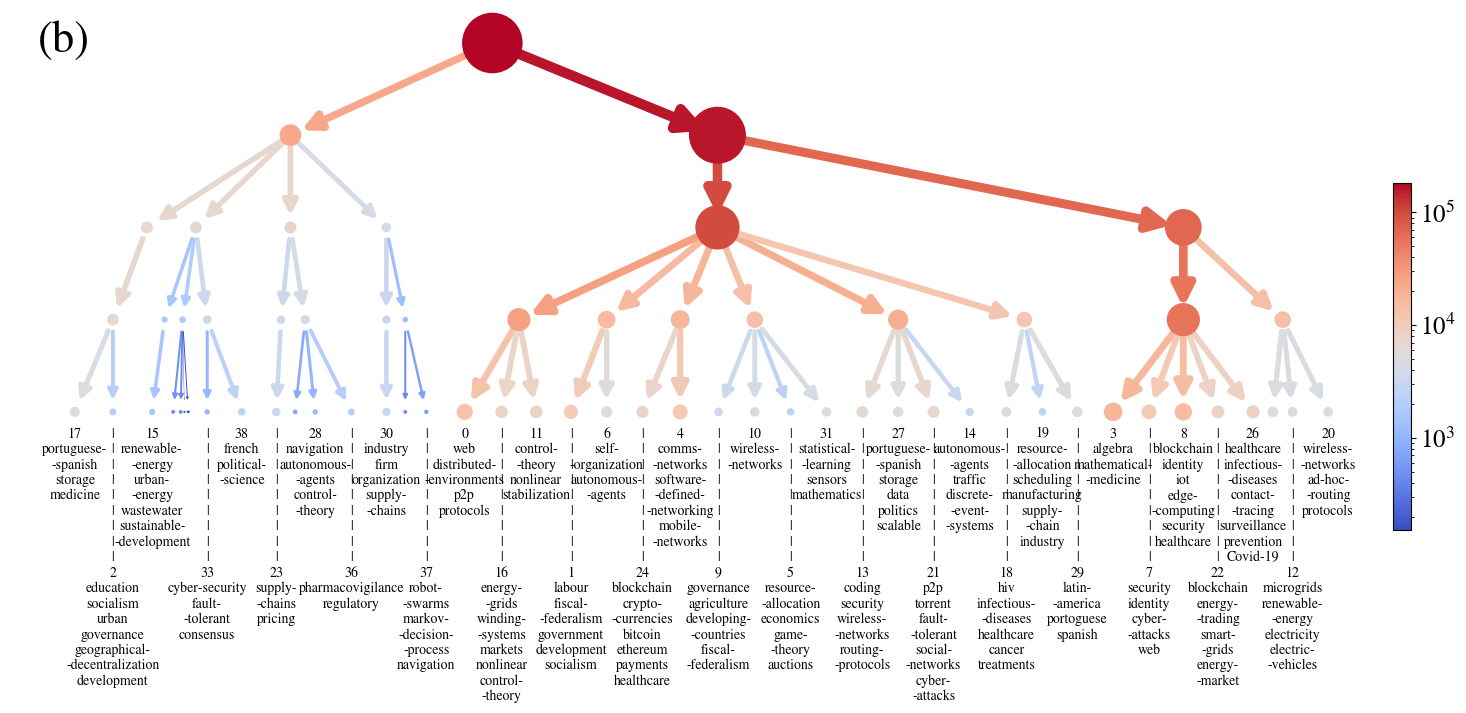

In [126]:
figsize=(21,9)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
# plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1)), ax=ax,shrink=0.5,pad=0.,fraction=0.2)
pos = create_hierarchy_network_docs(partition=0, top_level=6, bottom_level=2, 
                             max_num_clusters_to_represent=10000, num_words_to_represent=20, 
                             multiplicator_size_nodes=.01, multiplicator_size_edges=1, multiplicator_ypos=0.30,
                             fontsize = 10, ax=ax, fig=fig, threshold_num_papers = 500, num_spaces=50)

In [127]:
level2_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="2"]
ordered_lev2_clusters_pos = sorted(level2_pos,key = lambda x:x[1][0])
ordered_lev2_clusters = [int(x[0].split("_")[1]) for x in ordered_lev2_clusters_pos]

In [128]:
print(ordered_lev2_clusters)

[32, 35, 39, 40, 42, 41, 34, 25]


In [129]:
ordered_hierarchy_lev_3 = []
for c in ordered_lev2_clusters:
    for c3 in hierarchy_docs[3].keys():
        if c in hierarchy_docs[3][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_3]:
            ordered_hierarchy_lev_3.append((c3,hierarchy_docs[3][c3]))

In [130]:
ordered_hierarchy_lev_3

[(13, {32, 35, 39, 40, 42}),
 (11, {28, 36, 41}),
 (15, {34, 37}),
 (6, {12, 20, 25})]

## print all at level 3 and 2

In [131]:
print(f"number of document-document links: {len(citations_df)}",flush=True)
print(f"number of word-document links: {np.sum([len(set(x)) for x in edited_text])}",flush=True)

number of document-document links: 590215
number of word-document links: 1396830


In [132]:
lev=3
centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']
partitions = np.unique(list(name2partition_by_level[lev].values()))
# partition = 2
for partition in partitions:
    print("\n\n\n\n\n\n---------------------------------------------------------------------------\n\n\n\n\n\n")
#     x = analyse_cluster_supernew(lev = lev, top_level_topics=6, bottom_level_topics = 2, partition=partition, centralities_to_print=centralities_to_print, 
#                  max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, do_sample_knowledge_flow = False,
#                  multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10,
#                     colorbar_log_heatmap=True)
    for child in hierarchy_docs[lev][partition]:
        x = analyse_cluster_supernew(lev = lev-1, top_level_topics=6, bottom_level_topics = 2, partition=child, centralities_to_print=centralities_to_print, 
                 max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 4, do_sample_knowledge_flow = False,
                 multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10,
                                    colorbar_log_heatmap=True, )








---------------------------------------------------------------------------






LEVEL 2 - CLUSTER 3



KeyError: 5

In [ ]:
lev=3
centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']
partitions = np.unique(list(name2partition_by_level[lev].values()))
# partition = 2
for partition in partitions:
    print("\n\n\n\n\n\n---------------------------------------------------------------------------\n\n\n\n\n\n")
#     x = analyse_cluster_supernew(lev = lev, top_level_topics=6, bottom_level_topics = 2, partition=partition, centralities_to_print=centralities_to_print, 
#                  max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, do_sample_knowledge_flow = False,
#                  multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10,
#                     colorbar_log_heatmap=True)
    for child in hierarchy_docs[lev][partition]:
        x = analyse_cluster_supernew(lev = lev-1, top_level_topics=6, bottom_level_topics = 2, partition=child, centralities_to_print=centralities_to_print, 
                 max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 4, do_sample_knowledge_flow = False,
                 multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10,
                                    colorbar_log_heatmap=True, )


# Label and study single cluster with articles, knowledge flow and year/fields distr.

### Topics

In [ ]:
l = 3 # choose higher level for the prints

for i in range(len(hierarchy_words[l])):
    m = min(hierarchy_words[l])
    m2 = min(hierarchy_words[l-1])

    pd.options.display.max_columns = 50
    print(f"LEVEL {l} -- TOPIC {i}")
    print(topics_df_by_level[l][i].iloc[:50],flush=True)#[range(0,15)]
    print(f"\n\nLEVEL {l-1}")
    print(topics_df_by_level[l-1][np.array(list(hierarchy_words[l][i+m])) - m2].iloc[:20],flush=True)#[range(0,15)]
    print("\n\n\n---------------------------------------------------------------------------------------\n\n\n")
    pd.options.display.max_columns = 20

### Articles clusters

In [96]:
paper2fields = {}
paper2year = {}
for paper_id, paper in all_docs_dict.items():
    paper2year[paper_id] = paper["year"] if "year" in paper else None
    paper2fields[paper_id] = paper["fieldsOfStudy"] if "fieldsOfStudy" in paper and paper["fieldsOfStudy"] is not None else []

In [ ]:
def analyse_cluster(lev = 3, partition=0, centralities_to_print=[], num_most_frequent_words = 100, num_papers_to_show = 3):

    # partition = hyperlink_text_consensus_partitions_by_level[lev]
    print(print_color.UNDERLINE + "There are %d clusters and %d topics\n"%(len(normalized_mixture_proportion_by_level[lev]),len(normalized_mixture_proportion_by_level[lev]["doc_group 0"])) + print_color.END)

    p = partition
    p_remapped = doc_partition_remapping_by_level[lev][p]
#     if p_remapped == 17:# or p_remapped == 26 or p_remapped == 42:
    print(print_color.UNDERLINE + print_color.BOLD + print_color.RED + "PARTITION %d\n"%(p_remapped) + print_color.END)
#         tmp = pd.Series(normalized_mixture_proportion_by_level[lev]["doc_group %d"%p_remapped]).sort_values(ascending=False)
    tmp = pd.Series({key:value for key,value in normalized_mixture_proportion_by_level[lev]["doc_group %d"%p_remapped].items() if topics_df_by_level[lev][int(key[6:])].notna().sum()>0}).sort_values(ascending=False)
    tmp_topics = [int(string[6:]) for string in tmp[tmp>0].iloc[:10].index]


    papers = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[lev][x]==p]
    
    # YEAR DISTRIBUTION OF PAPERS
    fig, axes = plt.subplots(1,2,figsize=(20,6), gridspec_kw={'hspace':.3,'wspace':0.45})
    plt.suptitle("Partition %d"%partition, fontsize=32)
    ax = axes[0]
    years_in_partition = pd.Series([paper2year[paper_id] for paper_id in papers]).value_counts().sort_index()
    ax.bar(x=years_in_partition.index, height=years_in_partition.values)
    ax.set_yscale("log")

    # FIELDS DISTRIBUTION OF PAPERS
    ax = axes[1]
    fields_weights = {}
    for paper_id in papers:
        fields = paper2fields[paper_id]
        len_fields = len(fields)
        for field in fields:
            fields_weights.setdefault(field, 0)
            fields_weights[field] += 1/len_fields
    
    sorted_fields_weights = pd.Series(fields_weights).sort_values()
    ax.barh(y=sorted_fields_weights.index, width=sorted_fields_weights.values)
#     ax.tick_params(rotation=90, which="major")
    ax.set_xscale("log")

    
    # TOPICS REPRESENTATION
    
    word_freq_cluster = pd.Series([tokenized_texts_dict[paper_id] for paper_id in papers]).explode().value_counts().sort_values(ascending=False)
    most_frequent_words_tmp = set(list(word_freq_cluster.iloc[:num_most_frequent_words].index))
    most_frequent_words = set()
    for topic in tmp_topics:
        for word in topics_df_by_level[lev][topic]:
            if word in most_frequent_words_tmp:
                most_frequent_words.add(word)
    try:
        most_frequent_words.remove("com")
    except:
        pass

    print("--- %d TOPICS ---\n"%(len(tmp[tmp>0])))
    for topic in tmp_topics:
        print("---> TOPIC %d"%topic, "normalized mixture proportion = %.4f"%tmp.loc["topic %d"%topic],
             "mixture proportion = %.4f"%mixture_proportion_by_level[lev]["doc_group %d"%p_remapped]["topic %d"%topic],sep='\t\t')
        print("\t%d WORDS"%topics_df_by_level[lev][topic].notna().sum(),end=" ")
        for word in topics_df_by_level[lev][topic].iloc[:20]:
            if pd.notna(word):
                if word in most_frequent_words:
                    print(print_color.BOLD + print_color.RED + "- "+word + print_color.END, end=" ")
                else:
                    print("- "+word,end=" ")
        print("\n")
#     print(pd.Series(normalized_mixture_proportion_by_level[lev]["doc_group %d"%p_remapped]))

    # SAMPLING OF PAPERS
    print("--- %d PAPERS ---\n"%len(papers))
#         papers = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[lev][x]==p]
    for centrality in centralities_to_print:
        papers_tmp = papers.copy()
        centrality_values = centralities[centrality][np.isin(ordered_paper_ids,papers)]
        centrality_values_tmp = list(centrality_values.copy())
        print(centrality.upper())
        for __ in range(num_papers_to_show):
            paper = papers_tmp[np.nanargmax(centrality_values)]
            papers_tmp.remove(paper)
            centrality_max=np.nanmax(centrality_values_tmp)
            centrality_values_tmp.remove(centrality_max)

            print("(%f)"%centrality_max,end = " ")
            if all_docs_dict[paper]["year"] != None:
                print("y=%d"%all_docs_dict[paper]["year"],end = " ")
            print("FoS=",end = "")
            for field in all_docs_dict[paper]["fieldsOfStudy"]:
                print("%s"%field,end = " - ")
            if len(all_docs_dict[paper]["fieldsOfStudy"]) == 0:
                print("None",end = " - ")
            for word in split_words(all_docs_dict[paper]['title']):
                if pd.notna(word):
                    if word.lower() in most_frequent_words:
                        print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
                    else:
                        print(word,end="")
            print("")
        print("")



#         for centrality in centralities_to_print:

#             centrality_values = centralities[centrality][np.isin(ordered_paper_ids,papers)]
#             paper = papers[np.nanargmax(centrality_values)]

#             print(centrality.upper())
#     #         print(paper)

#             for word in split_words(all_docs_dict[paper]['title']):
#                 if pd.notna(word):
#                     if word.lower() in most_frequent_words:
#                         print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
#                     else:
#                         print(word,end="")
# #             print("\n"+all_docs_dict[paper]['title'])#," ----- ",f"centrality: {np.nanmax(centrality_values)}")
#             print(f"\nCentrality: {np.nanmax(centrality_values)}")
#             print()
#     #         print(all_docs_dict[paper]['paperAbstract'])
#     #         print()

#     print("\n\n---------------------------------------------------------------\n\n")

In [ ]:

centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']
partitions = np.unique(list(name2partition_by_level[lev].values()))

partition = partitions[0]
analyse_cluster(lev = 3, partition=partition, centralities_to_print=centralities_to_print, num_most_frequent_words = 100, num_papers_to_show = 5)

### NEW AWESOME WAY

In [97]:
def get_most_represented_topic(level_partition, partition, level_topic):
    if level_topic >= max(list(hierarchy_words.keys())):
        return 0
    else:
        p = partition
        p_remapped = doc_partition_remapping_by_level[level_partition][p]
    #     print(print_color.UNDERLINE + print_color.BOLD + print_color.RED + "PARTITION %d\n"%(p_remapped) + print_color.END)
        tmp = pd.Series({key:value for key,value in normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition][level_topic]["doc_group %d"%p_remapped].items() if topics_df_by_level[level_topic][int(key[6:])].notna().sum()>0}).sort_values(ascending=False)

        return int(tmp.index[0][6:])

In [98]:
def name_node(level, index, list_labels = [], num_spaces = 200):
    if len(list_labels) == 0:
        return f"{level}_{index}"
    else:
        string = f"" # f"{level}_{index}"
        for _ in list_labels:
            string += "\n" + " "*num_spaces + "%s"%_ + " "*num_spaces
        return string

In [100]:
def topic_mixture_proportion(dict_groups,edited_text, document_partitions):

    topics = dict_groups.keys()
    partitions = np.unique(document_partitions)

    avg_topic_frequency = {}
    mixture_proportion = {}
    normalized_mixture_proportion = {}

    doc_texts = np.array(edited_text, dtype=object)

    n_i_t = {}

    topic_doc_group_words = {}

    for doc_group in partitions:
        topic_doc_group_words[doc_group] = set()
        for i,doc_group_membership in enumerate(document_partitions):
            if doc_group_membership != doc_group:
                continue
            topic_doc_group_words[doc_group] = topic_doc_group_words[doc_group].union(set(edited_text[i]))

    for topic in topics:
        topic_words = set([x[0] for x in dict_groups[topic]])
        n_i_t[topic] = {}

        for doc_group in partitions:
            n_i_t[topic][doc_group] = len(topic_words.intersection(topic_doc_group_words[doc_group]))

    for doc_group in partitions:
        mixture_proportion[f"doc_group {doc_group}"] = {}
        for topic in topics:
            mixture_proportion[f"doc_group {doc_group}"][f"topic {topic}"] = n_i_t[topic][doc_group] / np.sum([n_i_t[topic_j][doc_group] for topic_j in topics])

    S = np.sum([n_i_t[topic_j][doc_group] for doc_group in partitions for topic_j in topics])
    for topic in topics:
        avg_topic_frequency[f"topic {topic}"] = np.sum([n_i_t[topic][doc_group] for doc_group in partitions]) / S

    for doc_group in partitions:
        normalized_mixture_proportion[f"doc_group {doc_group}"] = {}
        for topic in topics:
            normalized_mixture_proportion[f"doc_group {doc_group}"][f"topic {topic}"] = ( mixture_proportion[f"doc_group {doc_group}"][f"topic {topic}"] - avg_topic_frequency[f"topic {topic}"] ) / avg_topic_frequency[f"topic {topic}"]

    return mixture_proportion, normalized_mixture_proportion, avg_topic_frequency

In [101]:
try:
    with gzip.open(f"{results_folder}/results_fit_greedy_topic_frequency_all_by_level_partition_by_level_topics{filter_label}_all.gz","rb") as fp:
        topics_df_by_level,mixture_proportion_by_level_partition_by_level_topics, normalized_mixture_proportion_by_level_partition_by_level_topics, avg_topic_frequency_by_level_partition_by_level_topics = pickle.load(fp)
except FileNotFoundError:
    
    
    
    with gzip.open(f"{results_folder}/results_fit_greedy_partitions_consensus_all{filter_label}.gz","rb") as fp:
        h_t_doc_consensus_by_level, h_t_word_consensus_by_level, h_t_consensus_summary_by_level = pickle.load(fp)



    def get_topics_h_t_consensus_model(groups, words, n=10):
        """
        Retrieve topics in consensus partition for H+T model.
        """
        dict_groups = groups
        Bw = dict_groups['Bw'] # number of word-groups
        p_w_tw = dict_groups['p_w_tw'] # topic proportions over documents
        words = words
        # Loop over all word-groups
        dict_group_words = {}
        for tw in range(Bw):
            p_w_ = p_w_tw[:, tw]
            ind_w_ = np.argsort(p_w_)[::-1]
            list_words_tw = []
            for i in ind_w_[:n]:
                if p_w_[i] > 0:
                    list_words_tw+=[(words[i],p_w_[i])]
                else:
                    break
            dict_group_words[tw] = list_words_tw
        return dict_group_words    

    g_words = [ hyperlink_text_hsbm_states[0].g.vp['name'][v] for v in  hyperlink_text_hsbm_states[0].g.vertices() if hyperlink_text_hsbm_states[0].g.vp['kind'][v]==1   ]

    # THIS IS ONLY FOR MAXIMUM LEVEL, USELESS
    # dict_groups = get_topics_h_t_consensus_model(h_t_consensus_summary, g_words, n=1000000)
    dict_groups_by_level = {l:get_topics_h_t_consensus_model(h_t_consensus_summary_by_level[l], g_words, n=1000000) for l in h_t_doc_consensus_by_level.keys()}
    
    
    
    
    
    
    mixture_proportion_by_level_partition_by_level_topics, normalized_mixture_proportion_by_level_partition_by_level_topics, avg_topic_frequency_by_level_partition_by_level_topics = {}, {}, {}
    # level_partition = 3
    for level_partition in tqdm(range(6)):
        mixture_proportion_by_level_partition_by_level_topics[level_partition], normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition], avg_topic_frequency_by_level_partition_by_level_topics[level_partition] = {}, {}, {}
        for l in range(6):
            mixture_proportion_by_level_partition_by_level_topics[level_partition][l], normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition][l], avg_topic_frequency_by_level_partition_by_level_topics[level_partition][l] = \
                topic_mixture_proportion(dict_groups_by_level[l],ordered_edited_texts,h_t_doc_consensus_by_level[level_partition])

    with gzip.open(f"{results_folder}/results_fit_greedy_topic_frequency_all_by_level_partition_by_level_topics{filter_label}_all.gz","wb") as fp:
        pickle.dump((topics_df_by_level,mixture_proportion_by_level_partition_by_level_topics, normalized_mixture_proportion_by_level_partition_by_level_topics, avg_topic_frequency_by_level_partition_by_level_topics),fp)

  0%|          | 0/6 [00:00<?, ?it/s]

In [102]:
def get_mixture_proportion(level_partition, partition, level_topic, topic):
    if level_topic >= max(list(hierarchy_words.keys())):
        m2 = min(hierarchy_words[max(list(hierarchy_words.keys()))][0])
        return np.max([get_mixture_proportion(level_partition, partition, max(list(hierarchy_words.keys()))-1, t-m2) for t in hierarchy_words[max(list(hierarchy_words.keys()))][0]])
    p_remapped = doc_partition_remapping_by_level[level_partition][partition]
#     m = min(hierarchy_words[level_topic])
    if topics_df_by_level[level_topic][topic].notna().sum() < 10:
        mixture_proportion = -1
    else:
        mixture_proportion = normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition][level_topic][f"doc_group {p_remapped}"][f"topic {topic}"]
#     if mixture_proportion <= 0:
#         return 0.001
#     else:
#         return mixture_proportion
    return mixture_proportion

In [103]:
def create_hierarchy_network(level_partition, partition, top_level_topics, bottom_level_topics, 
                             max_num_topics_to_represent, num_words_to_represent, ax,
                             multiplicator_size_nodes=1, multiplicator_size_edges=1,
                             multiplicator_ypos=0.1,
                             fontsize = 10):
    if level_partition > max(list(hierarchy_words.keys())):
        level_partition = max(list(hierarchy_words.keys())) + 1
    cmap = matplotlib.cm.get_cmap('coolwarm')#('winter') coolwarm
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom blue', ['red','gray'], N=256)
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = get_most_represented_topic(level_partition, partition, top_level_topics)
#     print(root)
    root_name = name_node(top_level_topics,root)
    node_size[root_name] = get_mixture_proportion(level_partition, partition, top_level_topics, root) * multiplicator_size_nodes
    G.add_node(root_name)
    
            

    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level_topics:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level_topics, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = get_mixture_proportion(level_partition, partition, l-1, child) * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    node_size = {x:y - min_node_size_old + multiplicator_size_nodes*0.05 for x,y in node_size.items()}
    min_node_size = min(list(node_size.values()))
    max_node_size = max(list(node_size.values()))
    
    
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level_topics+1,top_level_topics+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level_topics:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_words[l])
                m2 = min(hierarchy_words[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_words[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
                    if node_size_old[child_name] > 0:
                        leaves[child_name] = node_size_old[child_name]
#             highlighted_leaves = set(pd.Series(leaves).sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            sum_weights_children = 0
#             sum_weights_children_highlighted = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
#             node_colors[father_name] = cmap(0)
            for child in children:    
                child_name = name_node(l-1,child)
                if l-1 == bottom_level_topics:
                    if child_name in highlighted_leaves:
                        # let's substitute the name of the nodes
                        significant_string = ""
#                         flag = False
                        for _ in range(min(4,int(node_size_old[child_name]/multiplicator_size_nodes))):
                            significant_string += "*"
#                             flag = True
#                         if flag == True:
                        list_labels = [significant_string] + list(topics_df_by_level[l-1][child].iloc[:num_words_to_represent].values)
#                         else:
#                             list_labels = list(topics_df_by_level[l-1][child].iloc[:num_words_to_represent].values)
                        new_child_name = name_node(l-1,child, list_labels = list_labels)
                        node_size[new_child_name] = node_size[child_name]
                        del node_size[child_name]
                        highlighted_leaves.remove(child_name)
                        highlighted_leaves.add(new_child_name)
                        child_name = new_child_name
#                         node_colors[child_name] = 1.
#                         sum_weights_children_highlighted += node_size[child_name]
#                         node_colors[father_name] = "blue"
#                     else:
#                         node_colors[child_name] = 0.
                    node_colors[child_name] = (node_size[child_name]-min_node_size)/(max_node_size-min_node_size)
#                 elif node_colors[child_name] == "blue":
#                     node_colors[father_name] = "blue"
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            node_colors[father_name] = np.sum([node_colors[child_name]*node_size[child_name] for child_name in child_names])/sum_weights_children
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level_topics+1:
                    edge_size[(father_name,child_name)] = node_size[child_name] * multiplicator_size_edges
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] / edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
            
    
    # DRAWING
    pos = graphviz_layout(G, prog='dot')#{"fontsize":fontsize, "labelfontsize":fontsize})
#     return pos
    y_pos = sorted(list(set([_[1] for _ in list(pos.values())])))

    y_pos_max = y_pos[-1]
    y_pos_min = y_pos[0]
    y_pos_min_new = y_pos_min + (y_pos_max-y_pos_min)*multiplicator_ypos
    y_pos_dict = {y_pos_min:y_pos_min_new, y_pos_max:y_pos_max}
    no_mid_y = len(y_pos[1:-1])
    for index,y in enumerate(y_pos[1:-1]):
        y_pos_dict[y] = y_pos_min_new + (y_pos_max - y_pos_min_new)/(no_mid_y+1)*(index+1)
    for k,v in pos.items():
        pos[k] = (v[0],y_pos_dict[v[1]])
#     print(pos,"\n\n")
#     print(node_colors)
    nx.draw_networkx_nodes(G,pos,node_size=[node_size[node] for node in pos.keys()],ax=ax,node_color=[cmap(node_colors[node]) for node in pos.keys()])
    l = nx.draw_networkx_labels(G,pos,font_size=fontsize, font_color = 'black', font_family="STIXGeneral", labels={x:x.replace(" nan ","").replace(" ","") if len(x)>10 else "" for x in pos.keys()}, verticalalignment="top",  ax=ax)

    for i,edge in enumerate(G.edges()):
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge_size[edge], arrowsize=edge_size[edge]*5,edge_color = cmap(node_colors[edge[1]]),ax=ax)#arrowstyle='fancy')
#             else:
#                 nx.draw_networkx_edges(G, pos, edgelist=[edge], width=weights[i], arrowsize=arrowsize_list[i],edge_color = 'grey',ax=ax)#arrowstyle='fancy')

#     for node in G.nodes:
#         if (node, node) in G.edges:
#             draw_self_loop(point=pos[node], color="grey", alpha=1, linewidth=G[node][node]['weight']*rescaling_factor_edge_width,ax=ax,padding=1.25,arrowsize=arrowsize_dict[node][node])

    
#     import seaborn as sn
#     sn.despine(left=False,bottom=False,ax=ax)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    ax.axis('off')
    pos_y_values = [_[1] for _ in pos.values()]
    ax.set_ylim([min(pos_y_values)*0,max(pos_y_values)*1.05])
#     ax.set_title("Level %d: Partition %d"%(level_partition, partition))
#     plt.autoscale()
#     fig.tight_layout()
    return cmap, min_node_size_old/multiplicator_size_nodes, max_node_size_old/multiplicator_size_nodes
    

In [ ]:
figsize=(30,15)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
pos = create_hierarchy_network(level_partition=3, partition=9, top_level_topics=6, bottom_level_topics=2, 
                             max_num_topics_to_represent=10, num_words_to_represent=20, 
                             multiplicator_size_nodes=50, multiplicator_size_edges=0.005, multiplicator_ypos=-0.15,
                             fontsize = 12, ax=ax)

#### Analysis

##### print at lev partition

In [ ]:
def analyse_cluster_print_at_lev_partition(lev = 3, partition=0, centralities_to_print=[], num_most_frequent_words = 100, num_papers_to_show = 3):

    # partition = hyperlink_text_consensus_partitions_by_level[lev]
    print(print_color.UNDERLINE + "There are %d clusters and %d topics\n"%(len(normalized_mixture_proportion_by_level[lev]),len(normalized_mixture_proportion_by_level[lev]["doc_group 0"])) + print_color.END)

    p = partition
    p_remapped = doc_partition_remapping_by_level[lev][p]
#     if p_remapped == 17:# or p_remapped == 26 or p_remapped == 42:
    print(print_color.UNDERLINE + print_color.BOLD + print_color.RED + "PARTITION %d\n"%(p_remapped) + print_color.END)
#         tmp = pd.Series(normalized_mixture_proportion_by_level[lev]["doc_group %d"%p_remapped]).sort_values(ascending=False)
    tmp = pd.Series({key:value for key,value in normalized_mixture_proportion_by_level[lev]["doc_group %d"%p_remapped].items() if topics_df_by_level[lev][int(key[6:])].notna().sum()>0}).sort_values(ascending=False)
    tmp_topics = [int(string[6:]) for string in tmp[tmp>0].iloc[:10].index]

    

    papers = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[lev][x]==p]
    
    # YEAR DISTRIBUTION OF PAPERS
#     fig, axes = plt.subplots(2,2,figsize=(20,6), gridspec_kw={'hspace':.3,'wspace':0.45})

    fig = plt.figure(figsize = (40,16))
    plt.suptitle("Partition %d"%partition, fontsize=32)

    outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[1,3],)#width_ratios=[1,1], wspace=0.3)#, hspace=0.2)

    # plt.suptitle("Aggregated Quantities - Users' Distributions", y=1.06, fontsize=40)

    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],)# hspace=0.35,wspace=0.3)

    ax = plt.Subplot(fig, inner[0])


#     fig = plt.figure(figsize=(20,15))
#     ax = fig.add_subplot(2,2,1)
#     ax = axes[0,0]
    years_in_partition = pd.Series([paper2year[paper_id] for paper_id in papers]).value_counts().sort_index()
    ax.bar(x=years_in_partition.index, height=years_in_partition.values)
    ax.set_yscale("log")

    # FIELDS DISTRIBUTION OF PAPERS
#     ax = axes[0,1]
#     ax = fig.add_subplot(2,2,2)
    fig.add_subplot(ax)

    ax = plt.Subplot(fig, inner[1])
    fields_weights = {}
    for paper_id in papers:
        fields = paper2fields[paper_id]
        len_fields = len(fields)
        for field in fields:
            fields_weights.setdefault(field, 0)
            fields_weights[field] += 1/len_fields
    
    sorted_fields_weights = pd.Series(fields_weights).sort_values()
    ax.barh(y=sorted_fields_weights.index, width=sorted_fields_weights.values)
#     ax.tick_params(rotation=90, which="major")
    ax.set_xscale("log")
    fig.add_subplot(ax)

    inner = gridspec.GridSpecFromSubplotSpec(1, 1,
                        subplot_spec=outer[1],)# hspace=0.35,wspace=0.3)
    ax = plt.Subplot(fig, inner[0])
#     ax = fig.add_subplot(2,1,2)
    create_hierarchy_network(level_partition=lev, partition=partition, top_level_topics=4, bottom_level_topics=2, 
                             max_num_topics_to_represent=10, num_words_to_represent=20, 
                             multiplicator_size_nodes=200, multiplicator_size_edges=0.01,
                             fontsize = 10, ax=ax)
    fig.add_subplot(ax)

    # TOPICS REPRESENTATION
    
    word_freq_cluster = pd.Series([tokenized_texts_dict[paper_id] for paper_id in papers]).explode().value_counts().sort_values(ascending=False)
    most_frequent_words_tmp = set(list(word_freq_cluster.iloc[:num_most_frequent_words].index))
    most_frequent_words = set()
    for topic in tmp_topics:
        for word in topics_df_by_level[lev][topic]:
            if word in most_frequent_words_tmp:
                most_frequent_words.add(word)
    try:
        most_frequent_words.remove("com")
    except:
        pass

    print("--- %d TOPICS ---\n"%(len(tmp[tmp>0])))
    for topic in tmp_topics:
        print("---> TOPIC %d"%topic, "normalized mixture proportion = %.4f"%tmp.loc["topic %d"%topic],
             "mixture proportion = %.4f"%mixture_proportion_by_level[lev]["doc_group %d"%p_remapped]["topic %d"%topic],sep='\t\t')
        print("\t%d WORDS"%topics_df_by_level[lev][topic].notna().sum(),end=" ")
        for word in topics_df_by_level[lev][topic].iloc[:20]:
            if pd.notna(word):
                if word in most_frequent_words:
                    print(print_color.BOLD + print_color.RED + "- "+word + print_color.END, end=" ")
                else:
                    print("- "+word,end=" ")
        print("\n")
#     print(pd.Series(normalized_mixture_proportion_by_level[lev]["doc_group %d"%p_remapped]))

    # SAMPLING OF PAPERS
    print("--- %d PAPERS ---\n"%len(papers))
#         papers = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[lev][x]==p]
    for centrality in centralities_to_print:
        papers_tmp = papers.copy()
        centrality_values = centralities[centrality][np.isin(ordered_paper_ids,papers)]
        centrality_values_tmp = list(centrality_values.copy())
        print(centrality.upper())
        for __ in range(num_papers_to_show):
            paper = papers_tmp[np.nanargmax(centrality_values)]
            papers_tmp.remove(paper)
            centrality_max=np.nanmax(centrality_values_tmp)
            centrality_values_tmp.remove(centrality_max)

            print("(%f)"%centrality_max,end = " ")
            if all_docs_dict[paper]["year"] != None:
                print("y=%d"%all_docs_dict[paper]["year"],end = " ")
            print("FoS=",end = "")
            for field in all_docs_dict[paper]["fieldsOfStudy"]:
                print("%s"%field,end = " - ")
            if len(all_docs_dict[paper]["fieldsOfStudy"]) == 0:
                print("None",end = " - ")
            for word in split_words(all_docs_dict[paper]['title']):
                if pd.notna(word):
                    if word.lower() in most_frequent_words:
                        print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
                    else:
                        print(word,end="")
            print("")
        print("")



#         for centrality in centralities_to_print:

#             centrality_values = centralities[centrality][np.isin(ordered_paper_ids,papers)]
#             paper = papers[np.nanargmax(centrality_values)]

#             print(centrality.upper())
#     #         print(paper)

#             for word in split_words(all_docs_dict[paper]['title']):
#                 if pd.notna(word):
#                     if word.lower() in most_frequent_words:
#                         print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
#                     else:
#                         print(word,end="")
# #             print("\n"+all_docs_dict[paper]['title'])#," ----- ",f"centrality: {np.nanmax(centrality_values)}")
#             print(f"\nCentrality: {np.nanmax(centrality_values)}")
#             print()
#     #         print(all_docs_dict[paper]['paperAbstract'])
#     #         print()

#     print("\n\n---------------------------------------------------------------\n\n")

In [ ]:
lev=3
centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']
partitions = np.unique(list(name2partition_by_level[lev].values()))

partition = partitions[0]
analyse_cluster_print_at_lev_partition(lev = 4, partition=partition, centralities_to_print=centralities_to_print, num_most_frequent_words = 100, num_papers_to_show = 5)

##### print at bottom level

###### Load knowledge flow

In [104]:
knowledge_flow_normalized_per_field_per_time_window_to_future_by_level = {}
for lev in [2,3]:
    with gzip.open(f"{results_folder}/knowledge_flow_normalized_per_field_per_time_window_to_future_gt_partition_lev_{lev}.gz","rb") as fp:
        knowledge_flow_normalized_per_field_per_time_window_to_future_by_level[lev] = pickle.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: 'data/2021-09-01/decentralization/0_min_inCitations_5_min_word_occurrences_titles//knowledge_flow_normalized_per_field_per_time_window_to_future_gt_partition_lev_2.gz'

In [ ]:
# all_docs_dict[paper]['ye_partition'] is a list of all the fields of the paper!!

# ACHTUNG PUT TO TRUE ONLY ONE!!
partition_first_field = False # Deprecated
partition_exploded = False
gt_partition = True
bottom_level_topics =  gt_partition_level = 2
print(f"working at bottom level {gt_partition_level}")

all_docs = list(all_docs_dict.values())

if partition_first_field:
    partition_used = "original_partition_first_field"
    ye_partition_paper_folder = paper_figures_folder
    # ACHTUNG here we assign the partition, can be changed
    # THIS IS NOW DEPRECATED
    for paper in all_docs_dict:
        if 'fieldsOfStudy' in all_docs_dict[paper] and all_docs_dict[paper]['fieldsOfStudy'] is not None and len(all_docs_dict[paper]['fieldsOfStudy']) > 0:
            all_docs_dict[paper]['ye_partition'] = all_docs_dict[paper]['fieldsOfStudy'][0]
        elif 'fieldsOfStudy' in all_docs_dict[paper]: 
            all_docs_dict[paper]['ye_partition'] = None

    all_partitions = set([x['ye_partition'] for x in all_docs_dict.values()])
    ye_partition = {field:set() for field in all_partitions}

    for paper in all_docs_dict:
        if 'ye_partition' in all_docs_dict[paper]:
            ye_partition[all_docs_dict[paper]['ye_partition']].add(paper)


if partition_exploded:
    partition_used = "original_partition_exploded"
    ye_partition_paper_folder = paper_figures_folder
    # ACHTUNG: papers may be assigned to multiple fields

    for paper in all_docs_dict:
        if 'fieldsOfStudy' in all_docs_dict[paper] and all_docs_dict[paper]['fieldsOfStudy'] is not None and len(all_docs_dict[paper]['fieldsOfStudy']) > 0:
            all_docs_dict[paper]['ye_partition'] = all_docs_dict[paper]['fieldsOfStudy']
        elif 'fieldsOfStudy' in all_docs_dict[paper]: 
            all_docs_dict[paper]['ye_partition'] = []
            
            
    all_partitions = set([x for y in paper2field.values() for x in y])
    ye_partition = {field:set() for field in all_partitions}

    for paper in all_docs_dict.values():
        for field in paper['fieldsOfStudy']:
            ye_partition[field].add(paper['id'])

            
if gt_partition:
    partition_used = "gt_partition_lev_%d"%(gt_partition_level)
    ye_partition_paper_folder = paper_figures_folder+"analysys_level_%d/"%gt_partition_level
    print("Loading results GT")
    with gzip.open(f"{results_folder}results_fit_greedy_partitions_docs_all_info{filter_label}.gz","rb") as fp:
        hyperlink_text_hsbm_partitions_by_level_info,duration = pickle.load(fp)
    with gzip.open(f"{results_folder}results_fit_greedy_partitions_docs_all{filter_label}.gz","rb") as fp:
        hyperlink_text_hsbm_partitions_by_level,duration = pickle.load(fp)
#     hyperlink_text_consensus_partitions_by_level, hyperlink_text_consensus_partitions_sd_by_level = {}, {}
#     for l in hyperlink_text_hsbm_partitions_by_level.keys():
#         print(l,flush=True)
#         hyperlink_text_consensus_partitions_by_level[l], hyperlink_text_consensus_partitions_sd_by_level[l] = gt.partition_overlap_center(hyperlink_text_hsbm_partitions_by_level[l])
    with gzip.open(f"{results_folder}/results_fit_greedy_partitions_consensus_all{filter_label}.gz","rb") as fp:
        h_t_doc_consensus_by_level, h_t_word_consensus_by_level, h_t_consensus_summary_by_level = pickle.load(fp)
    hyperlink_text_consensus_partitions_by_level = {}
    for l in h_t_doc_consensus_by_level.keys():
        print(l,flush=True)
        hyperlink_text_consensus_partitions_by_level[l] = h_t_doc_consensus_by_level[l]
    
    
    ## ALERT this works only if one iteration has been done, otherwise fix it
#     name2partition = hyperlink_text_hsbm_partitions_by_level_info[gt_partition_level][0][3]
    hyperlink_g = gt.load_graph(f"{results_folder}gt_network{filter_label}.gt")
    name2partition = {}
    for i,name in enumerate(hyperlink_g.vp["name"]):
        name2partition[name] = hyperlink_text_consensus_partitions_by_level[gt_partition_level][i]
    paper_ids_with_partition = set(name2partition.keys())
    
    # The number of the partitions here are weirdly chosen, so let's remap like consensus partitions and hierarchy stuff...

    hyperlink_g = gt.load_graph(f"{results_folder}gt_network{filter_label}.gt")
    ordered_paper_ids = list(hyperlink_g.vp['name'])

#     ordered_edited_texts = [tokenized_texts_dict[paper_id] for paper_id in ordered_paper_ids]

    doc_partition_remapping = {}
    doc_partition_remapping_inverse = {}
    lista1 = []
    for paper in ordered_paper_ids:
        lista1.append(name2partition[paper])
    lista2 = hyperlink_text_consensus_partitions_by_level[gt_partition_level]
#     print(set(list(zip(lista1,lista2))))
    for part1, part2 in set(list(zip(lista1,lista2))):
        if part1 in doc_partition_remapping:
            print("THERE ARE MULTIPLE INSTANCES... ERROR")
            break
        else:
            doc_partition_remapping[part1] = part2  
            doc_partition_remapping_inverse[part2] = part1
    
    try:
        with open(results_folder+"labelling_partition_remapping_by_level.pkl","rb") as fp:
            labelling_partition_remapping_by_level = joblib.load(fp)
    except:
        labelling_partition_remapping_by_level = {gt_partition_level:{x:str(x) for x in doc_partition_remapping.values()}}
    labelling_partition_remapping_by_level_inverse = {level:{y:x for x,y in labelling_partition_remapping_by_level[level].items()} for level in labelling_partition_remapping_by_level}
    
        
    print("Assigning partition field in docs")

    for paper_id in all_docs_dict:
        if paper_id in paper_ids_with_partition:
            all_docs_dict[paper_id]['ye_partition'] = [labelling_partition_remapping_by_level[gt_partition_level][doc_partition_remapping[name2partition[paper_id]]]]
        else: 
            all_docs_dict[paper_id]['ye_partition'] = []
            
            
    all_partitions = set([x for x in labelling_partition_remapping_by_level[gt_partition_level].values()])
    all_partitions = list(all_partitions)
    all_partitions.sort()
#     all_partitions = set(all_partitions)
    ye_partition = {field:set() for field in all_partitions}

    for paper in all_docs_dict.values():
        for field in paper['ye_partition']:
            ye_partition[field].add(paper['id'])
    
    all_papers_ids = set(ordered_paper_ids)

In [ ]:
def topics_to_print(level_partition,partition,top_level_topics, bottom_level_topics, max_num_topics_to_represent):
    
    node_size = {}
    root = get_most_represented_topic(level_partition, partition, top_level_topics)
#     print(root)
    root_name = name_node(top_level_topics,root)
#     print(root_name)
    node_size[root_name] = get_mixture_proportion(level_partition, partition, top_level_topics, root)
#     G.add_node(root_name)
    
            

    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level_topics:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level_topics, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = get_mixture_proportion(level_partition, partition, l-1, child)
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    node_size = {x:y - min_node_size_old  for x,y in node_size.items()}
    min_node_size = min(list(node_size.values()))
    max_node_size = max(list(node_size.values()))
    
    
    edge_size_sum = {}
    node_colors = {}
    
    # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
    
    l = bottom_level_topics + 1
    leaves = {}
    for i in selected_nodes_by_level[l]:
        m = min(hierarchy_words[l])
        m2 = min(hierarchy_words[l-1])
        # topics at lower level in the hierarchy from the superior node
        children = np.array(list(hierarchy_words[l][i+m])) - m2
        for child in children:
            child_name = name_node(l-1,child)
            if node_size_old[child_name] > 0:
                leaves[child_name] = node_size_old[child_name]
    leaves = pd.Series(leaves)
    highlighted_leaves = list(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
        
    return [int(x[2:]) for x in highlighted_leaves]

In [ ]:
def sample_knowledge_flow(level,cluster,threshold, time_window, num_papers_to_show, most_frequent_words):
    """ 
        selecting the best paper(s) contributing to the knowledge flow between cluster and cluster2 from the time_period to the future
        
    """
        
    knowl_flow_tmp = knowledge_flow_normalized_per_field_per_time_window_to_future_by_level[level][time_window]
    
    
    
    for time_period in knowl_flow_tmp.keys():
        range_time_period = range(time_period[0],time_period[1]+1)
        set_papers_study = set([x for x in ordered_paper_ids if cluster in all_docs_dict[x]['ye_partition'] and all_docs_dict[x]['year'] in range_time_period])
        papers_in_study_dict = {}

        for paper_id in set_papers_study:
            paper = all_docs_dict[paper_id]
            papers_in_study_dict[paper_id] = {"no_citations_all":len(paper["inCitations"]), "no_knowledge_units_all":len(paper["inCitations"])/len(paper["ye_partition"]), 
                                             "no_citations":len(set(paper["inCitations"]).intersection(all_papers_ids)), "no_knowledge_units":len(set(paper["inCitations"]).intersection(all_papers_ids))/len(paper["ye_partition"]) }
            tmp_count = {field:0 for field in all_partitions}
            for citing_paper_id in set(paper["inCitations"]).intersection(all_papers_ids):
                citing_paper = all_docs_dict[citing_paper_id]
                for chosen_edge_field in citing_paper["ye_partition"]:
                    tmp_count[chosen_edge_field] += 1/len(paper["ye_partition"])/len(citing_paper["ye_partition"])
            for field in all_partitions:
                papers_in_study_dict[paper_id][field] = tmp_count[field]

        papers_in_study_df = pd.DataFrame(papers_in_study_dict).transpose()

#         print(knowl_flow_tmp[time_period]['future'])
        knowledge_flows = knowl_flow_tmp[time_period]['future'][cluster].items()
        
        for cluster2,z_score in knowledge_flows:
            if z_score > threshold:
                
                selected_papers = papers_in_study_df[cluster2].sort_values(ascending=False).iloc[:num_papers_to_show].index.values
                
                for paper in selected_papers:
    
                    print(f"({time_period} : {z_score} to {cluster2} - {papers_in_study_df[cluster2].loc[paper]} cits)",end = " ")
                    if all_docs_dict[paper]["year"] != None:
                        print("y=%d"%all_docs_dict[paper]["year"],end = " ")
                    print("FoS=[",end = "")
                    for field in all_docs_dict[paper]["fieldsOfStudy"]:
                        print("%s"%field,end = ", ")
                    if len(all_docs_dict[paper]["fieldsOfStudy"]) == 0:
    #                     print("None",end = " - ")
                        print("None",end = ", ")
                    print("] - ", end = "")
                    for word in split_words(all_docs_dict[paper]['title']):
                        if pd.notna(word):
                            if word.lower() in most_frequent_words:
                                print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
                            else:
                                print(word,end="")
                    print(f" --> {all_docs_dict[paper]['doiUrl']}")
#                     print("")


In [ ]:
def analyse_cluster_supernew_old(lev = 3, top_level_topics=6, bottom_level_topics=2, partition=0, centralities_to_print=[],
                             num_most_frequent_words = 100, num_papers_to_show = 3, max_num_topics_to_represent = 5,
                             threshold = 1, time_window = 10, remove_duplicates = False, 
                             multiplicator_size_nodes=50, multiplicator_size_edges=0.05, multiplicator_ypos=0.1, fontsize_graph=10):

    # partition = hyperlink_text_consensus_partitions_by_level[lev]
#     print(print_color.UNDERLINE + "There are %d clusters and %d topics\n"%(len(normalized_mixture_proportion_by_level[lev]),len(normalized_mixture_proportion_by_level[lev]["doc_group 0"])) + print_color.END)

    p = partition
    p_remapped = doc_partition_remapping_by_level[lev][p]
#     if p_remapped == 17:# or p_remapped == 26 or p_remapped == 42:
    print(print_color.UNDERLINE + print_color.BOLD + print_color.RED + "LEVEL %d - CLUSTER %d\n"%(lev,p_remapped) + print_color.END)
#         tmp = pd.Series(normalized_mixture_proportion_by_level[lev]["doc_group %d"%p_remapped]).sort_values(ascending=False)
#     tmp = pd.Series({key:value for key,value in normalized_mixture_proportion_by_level[lev]["doc_group %d"%p_remapped].items() if topics_df_by_level[lev][int(key[6:])].notna().sum()>0}).sort_values(ascending=False)
#     tmp_topics = [int(string[6:]) for string in tmp[tmp>0].iloc[:10].index]

    tmp_topics = topics_to_print(level_partition=lev,partition=partition,top_level_topics=top_level_topics,bottom_level_topics=bottom_level_topics,max_num_topics_to_represent=max_num_topics_to_represent)

    papers = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[lev][x]==p]
    
    # YEAR DISTRIBUTION OF PAPERS
#     fig, axes = plt.subplots(2,2,figsize=(20,6), gridspec_kw={'hspace':.3,'wspace':0.45})

    fig = plt.figure(figsize = (21,16))
    plt.suptitle("Level %d - Cluster %d"%(lev,partition), fontsize=32,y=0.93)

    outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[1.5,3],hspace=0.1)#width_ratios=[1,1], wspace=0.3)#, hspace=0.2)

    # plt.suptitle("Aggregated Quantities - Users' Distributions", y=1.06, fontsize=40)

    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],wspace=.35)# hspace=0.35,wspace=0.3)

    ax = plt.Subplot(fig, inner[0])


#     fig = plt.figure(figsize=(20,15))
#     ax = fig.add_subplot(2,2,1)
#     ax = axes[0,0]
    years_in_partition = pd.Series([paper2year[paper_id] for paper_id in papers]).value_counts().sort_index()
    ax.bar(x=years_in_partition.index, height=years_in_partition.values)
    ax.set_yscale("log")
    ax.set_xlim(1950)
    ax.set_xlabel("year")
    ax.set_ylabel("N. of papers")
    ax.text(0.05, 0.99, "(a)", fontsize=32, transform=ax.transAxes)
    
    # FIELDS DISTRIBUTION OF PAPERS
#     ax = axes[0,1]
#     ax = fig.add_subplot(2,2,2)
    fig.add_subplot(ax)

    ax = plt.Subplot(fig, inner[1])
    fields_weights = {}
    for paper_id in papers:
        fields = paper2fields[paper_id]
        len_fields = len(fields)
        for field in fields:
            fields_weights.setdefault(field, 0)
            fields_weights[field] += 1/len_fields
    
    sorted_fields_weights = pd.Series(fields_weights).sort_values()
    ax.barh(y=sorted_fields_weights.index, width=sorted_fields_weights.values)
    ax.tick_params(labelsize=14,axis = 'y',which="major")
    ax.set_xscale("log")
    ax.set_xlabel("N. of papers")
    ax.text(0.05, 0.99, "(b)", fontsize=32, transform=ax.transAxes)
    fig.add_subplot(ax)

    inner = gridspec.GridSpecFromSubplotSpec(1, 1,
                        subplot_spec=outer[1],wspace=0)# hspace=0.35)
    ax = plt.Subplot(fig, inner[0])
#     ax = fig.add_subplot(2,1,2)
    create_hierarchy_network(level_partition=lev, partition=partition, top_level_topics=top_level_topics, bottom_level_topics=2, 
                             max_num_topics_to_represent=max_num_topics_to_represent, num_words_to_represent=20, 
                             multiplicator_size_nodes=multiplicator_size_nodes, multiplicator_size_edges=multiplicator_size_edges, 
                             multiplicator_ypos=multiplicator_ypos, fontsize = fontsize_graph, ax=ax)
    ax.text(0.02, 0.9, "(c)", fontsize=32, transform=ax.transAxes)

    fig.add_subplot(ax)

    # TOPICS REPRESENTATION
    word_freq_cluster = pd.Series([tokenized_texts_dict[paper_id] for paper_id in papers]).explode().value_counts().sort_values(ascending=False)
    most_frequent_words_tmp = list(word_freq_cluster.iloc[:10*num_most_frequent_words].index)
    most_frequent_words_list = []
    for word in most_frequent_words_tmp:
        for topic in tmp_topics:
            if word in topics_df_by_level[bottom_level_topics][topic].values:
                most_frequent_words_list.append(word)
    try:
        most_frequent_words_list.remove("com")
    except:
        pass
    most_frequent_words_set = set()
    last_index = num_most_frequent_words-1
    while len(most_frequent_words_set) < num_most_frequent_words:
        most_frequent_words_set = set(most_frequent_words_list[:last_index+1])
        if len(most_frequent_words_set) < num_most_frequent_words:
            last_index += 1
        if last_index >= len(most_frequent_words_list)-1:
            break
    most_frequent_words = []
    for index,word in enumerate(most_frequent_words_list[:last_index+1]):
        if word not in most_frequent_words:
            most_frequent_words.append(word)
    print("%d MOST FREQUENT WORDS IN THE TOPICS ---->"%(num_most_frequent_words),most_frequent_words, "\n")

#     print("--- %d TOPICS ---\n"%(len(tmp[tmp>0])))
    for topic in tmp_topics:
        print("---> TOPIC %d"%topic, 
             "normalized mixture proportion = %.4f"%normalized_mixture_proportion_by_level_partition_by_level_topics[lev][bottom_level_topics]["doc_group %d"%p_remapped]["topic %d"%topic],
             "mixture proportion = %.4f"%mixture_proportion_by_level_partition_by_level_topics[lev][bottom_level_topics]["doc_group %d"%p_remapped]["topic %d"%topic],sep='\t\t')
        print("\t%d WORDS"%topics_df_by_level[bottom_level_topics][topic].notna().sum(),end=" ")
        for word in topics_df_by_level[bottom_level_topics][topic].iloc[:20]:
            if pd.notna(word):
                if word in most_frequent_words:
                    print(print_color.BOLD + print_color.RED + "- "+word + print_color.END, end=" ")
                else:
                    print("- "+word,end=" ")
        print("\n")
#     print(pd.Series(normalized_mixture_proportion_by_level[lev]["doc_group %d"%p_remapped]))

    # SAMPLING OF PAPERS
    chosen_level = bottom_level_topics
    print("--- %d PAPERS at level %d  ---\n"%(len(papers),chosen_level))
#         papers = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[lev][x]==p]

    selected_nodes_by_level = {lev:[partition]}
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(lev, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
        
    
    papers_tmp = papers.copy()
    for cluster in selected_nodes_by_level[chosen_level]:
        print("Chosen level %d: Cluster %d"%(chosen_level,cluster),end = "\n")
        papers_cluster = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[chosen_level][x]==cluster]
        for centrality in centralities_to_print:
            # ACHTUNG! we sample articoles at level bottom_level_topics, but we can do it at whatever level lower or equal than lev
            
            if not remove_duplicates:
                papers_cluster = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[chosen_level][x]==cluster]
                
            for __ in range(num_papers_to_show):
                
                centrality_values = centralities[centrality][np.isin(ordered_paper_ids,papers_cluster)]
                centrality_values_tmp = list(centrality_values.copy())
                
#                 return centrality_values, centrality_values_tmp, papers_cluster
#                 paper = np.array(ordered_paper_ids)[np.isin(ordered_paper_ids,papers_tmp)&np.isin(ordered_paper_ids,papers_cluster)][np.nanargmax(centrality_values)]
                paper = np.array(ordered_paper_ids)[np.isin(ordered_paper_ids,papers_cluster)][np.nanargmax(centrality_values)]

#                 papers_tmp.remove(paper)
                papers_cluster.remove(paper)
                centrality_max=np.nanmax(centrality_values_tmp)
                centrality_values_tmp.remove(centrality_max)

                
                print("(%s %s)"%(centrality,"%s"%(str(np.round(centrality_max,6)))),end = " ")
                if all_docs_dict[paper]["year"] != None:
                    print("y=%d"%all_docs_dict[paper]["year"],end = " ")
                print("FoS=[",end = "")
                for field in all_docs_dict[paper]["fieldsOfStudy"]:
                    print("%s"%field,end = ", ")
                if len(all_docs_dict[paper]["fieldsOfStudy"]) == 0:
#                     print("None",end = " - ")
                    print("None",end = ", ")
                print("] - ", end = "")
                for word in split_words(all_docs_dict[paper]['title']):
                    if pd.notna(word):
                        if word.lower() in most_frequent_words:
                            print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
                        else:
                            print(word,end="")
                print(f" --> {all_docs_dict[paper]['doiUrl']}")
#                 print("")
        sample_knowledge_flow(bottom_level_topics,str(cluster-min(hierarchy_docs[bottom_level_topics].keys())),threshold=threshold,
                              time_window=time_window, num_papers_to_show=num_papers_to_show, most_frequent_words=most_frequent_words)
        print("")

    display(fig)
    os.makedirs(paper_figures_folder+"cluster_analysis/",exist_ok=True)
#     fig.savefig(paper_figures_folder + "cluster_analysis/level_%d_num_%d.png"%(lev,partition))
    fig.savefig(paper_figures_folder + "cluster_analysis/level_%d_num_%d.pdf"%(lev,partition))
    plt.close(fig)
#         for centrality in centralities_to_print:

#             centrality_values = centralities[centrality][np.isin(ordered_paper_ids,papers)]
#             paper = papers[np.nanargmax(centrality_values)]

#             print(centrality.upper())
#     #         print(paper)

#             for word in split_words(all_docs_dict[paper]['title']):
#                 if pd.notna(word):
#                     if word.lower() in most_frequent_words:
#                         print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
#                     else:
#                         print(word,end="")
# #             print("\n"+all_docs_dict[paper]['title'])#," ----- ",f"centrality: {np.nanmax(centrality_values)}")
#             print(f"\nCentrality: {np.nanmax(centrality_values)}")
#             print()
#     #         print(all_docs_dict[paper]['paperAbstract'])
#     #         print()

#     print("\n\n---------------------------------------------------------------\n\n")

##### Heatmaps

In [ ]:
year_cluster_field_no_papers_df_by_level = {}
for level in tqdm(name2partition_by_level.keys()):
# level = 2
    dict_nested = {}
    for paper_id,cluster in name2partition_by_level[level].items():
        paper = all_docs_dict[paper_id]
        year = paper["year"]
        if year is not None:
            for field in paper["fieldsOfStudy"]:
    #             dict_nested.setdefault(year,{}).setdefault(cluster,{}).setdefault(field,0) 
                dict_nested.setdefault(field,{}).setdefault(cluster,{y:0 for y in range(1950,2022)})
                dict_nested[field][cluster].setdefault(year,0) 
                dict_nested[field][cluster][year] += 1./len(paper["fieldsOfStudy"])

    dict_for_df = {"year":[], "cluster":[], "field":[], "no_papers":[]}
    for field,_ in dict_nested.items():
        for cluster,_2 in _.items():
            for year,no_papers in _2.items():
                dict_for_df["year"].append(int(year))
                dict_for_df["cluster"].append(cluster)
                dict_for_df["field"].append(field)
                dict_for_df["no_papers"].append(no_papers)
    year_cluster_field_no_papers_df_by_level[level] = pd.DataFrame(dict_for_df)    

In [ ]:
def heatmap(df,fixed_labels, x_label, y_label, values_label,costrains_equal={}, 
            fig=None,ax=None,ax_cmap=None,subplot_spec=None,subplot_spec_heatmap=None,figsize=(12,6),
            filename="",
            ordered_cluster_labels = [],
            ordered_cluster_groups = [],
            linewidth=1,
            cut_small_clusters = False,
            threshold_num_papers = 1,
            do_barplot = True,
            vmax = None
           ):
    '''
        - fixed_labels_and_values_dict is a dict with the key of df to fix and his values to select!
        - If subplot_spec is not None, it must be a valid subplot_spec from gridspec, to position correctly the heatmap in the bigger picture. If this is provided, a fig must be provided to put it there.
        - if cut_small_clusters == True, remember to change threshold_num_papers
        - ACHTUNG! use cut_small_clusters and threshold_num_papers only when clusters are on y_axis
    '''
    class SeabornFig2Grid():

        def __init__(self, seaborngrid, fig,  subplot_spec):
            self.fig = fig
            self.sg = seaborngrid
            self.subplot = subplot_spec
            if isinstance(self.sg, sn.axisgrid.FacetGrid) or \
                isinstance(self.sg, sn.axisgrid.PairGrid):
                self._movegrid()
            elif isinstance(self.sg, sn.axisgrid.JointGrid):
                self._movejointgrid()
            self._finalize()

        def _movegrid(self):
            """ Move PairGrid or Facetgrid """
            self._resize()
            n = self.sg.axes.shape[0]
            m = self.sg.axes.shape[1]
            self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
            for i in range(n):
                for j in range(m):
                    self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

        def _movejointgrid(self):
            """ Move Jointgrid """
            h= self.sg.ax_joint.get_position().height
            h2= self.sg.ax_marg_x.get_position().height
            r = int(np.round(h/h2))
            self._resize()
            self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

            self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
            self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
            self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

        def _moveaxes(self, ax, gs):
            #https://stackoverflow.com/a/46906599/4124317
            ax.remove()
            ax.figure=self.fig
            self.fig.axes.append(ax)
            self.fig.add_axes(ax)
            ax._subplotspec = gs
            ax.set_position(gs.get_position(self.fig))
            ax.set_subplotspec(gs)

        def _finalize(self):
            plt.close(self.sg.fig)
            self.fig.canvas.mpl_connect("resize_event", self._resize)
            self.fig.canvas.draw()

        def _resize(self, evt=None):
            self.sg.fig.set_size_inches(self.fig.get_size_inches())

    keywords_clusters = annotated_keyword_clusters(threshold_num_papers=1)
    keywords_clusters = get_keywords_hierachy(keywords_clusters, 6, 0, hierarchy_docs, no_words=20,threshold_num_papers = 1)
    if cut_small_clusters:
        keywords_clusters = annotated_keyword_clusters(threshold_num_papers=threshold_num_papers)
        keywords_clusters = get_keywords_hierachy(keywords_clusters, 6, 0, hierarchy_docs, no_words=20,threshold_num_papers = threshold_num_papers)

    ordered_hierarchy_lev = {x:[] for x in [3,4,5]}
    ordered_hierarchy_lev[2] = [(x,()) for x in ordered_lev2_clusters]
    for l in [3,4,5]:
        for c in [x[0] for x in ordered_hierarchy_lev[l-1]]:
            for c3 in hierarchy_docs[l].keys():
                if c in hierarchy_docs[l][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev[l]]:
                    ordered_hierarchy_lev[l].append((c3,hierarchy_docs[l][c3]))

    for l in [4,5]:
        lev2_children = {x:[] for x in hierarchy_docs[l].keys()}
        for c,children in ordered_hierarchy_lev[l]:
            for child in children:
                for tmp in ordered_hierarchy_lev[l-1]:
                    if tmp[0] == child:
                        lev2_children[c] += list(tmp[1])
        ordered_hierarchy_lev[l] = [(x,lev2_children[x]) for x in [t[0] for t in ordered_hierarchy_lev[l]]]  
    
#     ordered_hierarchy_lev_3 = []
#     for c in ordered_lev2_clusters:
#         for c3 in hierarchy_docs[3].keys():
#             if c in hierarchy_docs[3][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_3]:
#                 ordered_hierarchy_lev_3.append((c3,hierarchy_docs[3][c3]))
    
    df_costrained_equal = df.copy()
    for key,value in costrains_equal.items():
        df_costrained_equal = df_costrained_equal.loc[df_costrained_equal[key].isin(value)]
    df_costrained_equal = df_costrained_equal.groupby([x_label,y_label],as_index=False)[values_label].sum()
    df_tmp = df_costrained_equal[[x_label, y_label, values_label]]
    matrix = df_tmp.pivot(index=y_label, columns=x_label, values=values_label).fillna(0)
    
    if len(ordered_cluster_labels)>0 and y_label in ["cluster","cluster_from", "cluster_to"]:
        matrix = matrix.loc[ordered_cluster_labels]
        if x_label in ["cluster","cluster_from", "cluster_to"]:
            matrix = matrix[ordered_cluster_labels]
    if cut_small_clusters and y_label in ["cluster","cluster_from", "cluster_to"]:
        matrix = matrix.loc[np.array([True if len(keywords_clusters[2][x]) > 0 else False for x in matrix.index.values])].copy()
        if x_label in ["cluster","cluster_from", "cluster_to"]:
            matrix = matrix[np.array([x for x in matrix.columns if len(keywords_clusters[2][x]) > 0])].copy()
        
        
    if cut_small_clusters:
        width_figsize = figsize[0]
        height_figsize = figsize[1]
        n = len(matrix)
        figsize = (width_figsize, 2 + n/40 * (height_figsize - 2))
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
            figsize = (3 + n/40 * (width_figsize-3), 2 + n/40 * (height_figsize - 2))
        
    if fig is None:
        fig = plt.figure(figsize = figsize)
        ax = plt.gca()
        sn.despine(left=True,bottom=True,ax=ax)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if subplot_spec is None:
            subplot_spec = gridspec.GridSpec(nrows=1, ncols=2,wspace=.03,width_ratios=[20,1])
            subplot_spec_heatmap = subplot_spec[0]
        if do_barplot:
            ax = plt.Subplot(fig, subplot_spec[0])
            ax_cmap = plt.Subplot(fig, subplot_spec[1])

        
    else:
        if subplot_spec_heatmap is None:
            subplot_spec = gridspec.GridSpec(nrows=1, ncols=2,wspace=.03,width_ratios=[20,1])
            subplot_spec_heatmap = subplot_spec[0]
        if ax is None:
            ax = plt.Subplot(fig, subplot_spec[0])
        if ax_cmap is None:
            ax_cmap= plt.Subplot(fig, subplot_spec[1])
            

    D = len(matrix.columns.values)
    H = len(matrix.index.values)
    vmin = matrix.min().min()
    if vmax is not None:
        vmax = matrix.max().max()
    if do_barplot:
        g = sn.jointplot(data=df_tmp, ax=ax,
                     x=x_label, y=y_label, kind="hist")
        g.ax_marg_y.cla()
        g.ax_marg_x.cla()
        sn.despine(left=True,bottom=True,ax=ax_cmap)
        ax_cmap.get_xaxis().set_visible(False)
        ax_cmap.get_yaxis().set_visible(False)
        ax_joint = g.ax_joint
        #     sn.heatmap(data=matrix, ax=g.ax_joint, cbar=True,cbar_ax=ax_cmap,cbar_kws={"shrink":0.5,"pad":0.,"drawedges":True})#, cmap='Blues')
    #     cb.outline.set_edgecolor('white')
    #     if not cut_small_clusters:
    #         g.ax_marg_y.barh(np.arange(0.5, H), df_tmp.groupby([y_label])[values_label].sum().to_numpy(), color='navy')
    #         g.ax_marg_x.bar(np.arange(0.5, D), df_tmp.groupby([x_label])[values_label].sum().to_numpy(), color='navy')
        g.ax_marg_y.barh(np.arange(0.5, H), matrix.sum(axis=1).to_numpy(), color='navy')
        g.ax_marg_x.bar(np.arange(0.5, D), matrix.sum(axis=0).to_numpy(), color='navy')
    else:
        ax_joint = ax
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
            vmin = 0
            vmax = 5

    sn.heatmap(data=matrix, ax=ax_joint, cmap="magma",cbar=False,vmin=vmin,vmax=vmax,rasterized=True)#, cmap='Blues')
    if do_barplot:
        cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=0.5,pad=0., fraction=1)
    
    if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
        ax_joint.set_xticks(np.arange(0.5, D))
        ax_joint.set_xticklabels(matrix.columns, rotation=0)
    ax_joint.set_yticks(np.arange(0.5, H))
    ax_joint.set_yticklabels(matrix.index.values, rotation=0)
    ax_joint.set_xlabel("")
    ax_joint.set_ylabel("")

    if do_barplot:
        # remove ticks between heatmap and histograms
        g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
        g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
        # remove ticks showing the heights of the histograms
        g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
        g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

        # remove ticks in the histograms
        # sn.despine(left=True,bottom=True,ax=g.ax_marg_x)
        g.ax_marg_x.get_xaxis().set_visible(False)
        g.ax_marg_x.get_yaxis().set_visible(False)
        # sn.despine(left=True,bottom=True,ax=g.ax_marg_y)
        g.ax_marg_y.get_xaxis().set_visible(False)
        g.ax_marg_y.get_yaxis().set_visible(False)
    
    
    # g.fig.set_size_inches(20, 8)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    # g.fig.subplots_adjust(hspace=0.0, wspace=0.0)  # less spaced needed when there are no tick labels

#     gs = gridspec.GridSpec(1, 2,width_ratios=[20,1],wspace=0)#,height_ratios=[1.5,3])

    if do_barplot:
        mg0 = SeabornFig2Grid(g, fig, subplot_spec_heatmap)
        ax_joint = mg0.sg.ax_joint
#     mg1 = SeabornFig2Grid(cbar, fig, subplot_spec[1])
    # mg2 = sfg.SeabornFig2Grid(g2, fig, gs[3])
    # mg3 = sfg.SeabornFig2Grid(g3, fig, gs[2])
    
#     fig.tight_layout(rect=(0.05, 0.1, 0.6, 0.6))#,h_pad=2,w_pad=0.55,pad=3)

#     fig.add_subplot(ax)
    
#     plt.show()
    
        
    line_color = {3:"white",4:"white",5:"red"}
    line_width = {3:linewidth,4:linewidth+2,5:linewidth+3}
    line_style = {3:"--",4:"-",5:"-"}
              
    if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
        for lev in [3,4,5]:
            y_h = 0
            filtered_ordered_cluster_groups = ordered_hierarchy_lev[lev].copy()
            if len(filtered_ordered_cluster_groups)>0:
                for j,g in enumerate(filtered_ordered_cluster_groups[:]): 
                    tmp = g[1]
                    if cut_small_clusters:
                        tmp = [x for x in g[1] if len(keywords_clusters[2][x]) > 0]
                    if len(tmp) == 0:
                        continue
                    if y_h != 0:
                        ax_joint.plot([y_h,y_h+len(tmp)],[y_h,y_h],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                        ax_joint.plot([y_h,y_h],[y_h,y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    ax_joint.plot([y_h,y_h+len(tmp)],[y_h+len(tmp),y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    ax_joint.plot([y_h+len(tmp),y_h+len(tmp)],[y_h,y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
#                     if lev == 3:
#                         delta_y = 0.7
#                         delta_y = len(g[1])/2
#                         txt = keywords_clusters[3][g[0]]
#                         words = txt.split("\n")
#                         txt = ""
#                         flag = False
#                         for i,word in enumerate(words):
#                             if len(txt+word)>100:
#                                 txt+="\n"
#                                 break
#                             txt += word + u' \u2212 '
#                         if i<len(words)-1:
#                             for word in words[i:]:
#                                 txt += word + u' \u2212 '
#                         txt = txt[:-3]
#                         mg0.sg.ax_joint.text(1,y_h+delta_y,txt,color='white',verticalalignment = 'center', fontsize = 15,alpha=.8)
                    y_h += len(tmp)#/len(ordered_cluster_labels)

        
#         # Uncomment if you want ticks on the right as well.
#         # ACHTUNG: They don't move with the rect of tight_layout, so it must be manually set with a precise rect
#         ax2 = mg0.sg.ax_joint.twinx()
#         ax2.grid(visible=False)
#         sn.despine(left=True,bottom=True,ax=ax2)
#         ax2.get_xaxis().set_visible(False)
#         ax2.yaxis.set_label_position("right")
#         ax2.yaxis.tick_right()
#         ax2.set_yticks(np.arange(H-0.5, 0,-1))
#         ax2.set_ylim(0,H)
#         ax2.set_yticklabels(matrix.index.values, rotation=0)




    elif y_label=="cluster" or y_label=="cluster_from" or y_label=="cluster_to":
        for lev in [3,4,5]:
            y_h = 0
            filtered_ordered_cluster_groups = ordered_hierarchy_lev[lev].copy()
            if len(filtered_ordered_cluster_groups)>0:
        #         ax.hlines([y_h], *ax.get_xlim(),color='white',zorder=10000,lw=100)
                for j,g in enumerate(filtered_ordered_cluster_groups[:]): 
        #             print(g)
                    tmp = g[1]
                    if cut_small_clusters:
                        tmp = [x for x in g[1] if len(keywords_clusters[2][x]) > 0]
                    if len(tmp) == 0:
                        continue
                    if y_h != 0:
                        ax_joint.axhline(y_h,zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    if lev == 3:
                        delta_y = 0.7
                        delta_y = len(tmp)/2
                        txt = keywords_clusters[3][g[0]]
                        words = txt.split("\n")
                        txt = ""
                        flag = False
                        for i,word in enumerate(words):
                            if len(txt+word)>100:
                                txt+="\n"
                                break
                            txt += word + u' \u2212 '
                        if i<len(words)-1:
                            for word in words[i:]:
                                txt += word + u' \u2212 '
                        txt = txt[:-3]
                                    
                        ax_joint.text(1,y_h+delta_y,txt,color='white',verticalalignment = 'center', fontsize = 15,alpha=.8)
        #             ax.text()
                    y_h += len(tmp)#/len(ordered_cluster_labels)
        #             print(y_h)
        
        
# #     if y_label=="cluster" or y_label=="cluster_from" or y_label=="cluster_to":
# #         g.ax_joint.yaxis.tick_right()
#         ax2 = mg0.sg.ax_joint.twinx()
#         ax2.grid(visible=False)
#         sn.despine(left=True,bottom=True,ax=ax2)
#         ax2.get_xaxis().set_visible(False)
# #         ax2.get_yaxis().set_visible(False)
# #         ax2.set_ylabel('foo')
# #         ax2.yaxis.set_visible(False)
#         ax2.yaxis.set_label_position("right")
#         ax2.yaxis.tick_right()
#         ax2.set_yticks(np.arange(H-0.5, 0,-1))
# #         ax2.set_yticks(np.arange(H-0.5, 0.5,-(len(matrix.index.values)-1/2)/len(matrix.index.values)))
#         ax2.set_ylim(0,H)
#         ax2.set_yticklabels(matrix.index.values, rotation=0)
# #         ax2.yaxis.set_tick_params(length=10)
# #         ax2.yaxis.set_tick_params(pad=20,length=0)
# #         ax2.yaxis.set_tick_params(pad=15)
# #         ax2.axis("off")
        
# #         ax2.plot([0,1],[0,1])
# #         mg02 = SeabornFig2Grid(ax2, fig, subplot_spec_heatmap)
# #     fig.add_subplot(ax_cmap)
    rect = (0,0,1,1)
    
                                                        
    
    if do_barplot:
        if (x_label=="year" and y_label=="cluster") or (x_label=="year_from" and y_label=="cluster_from") or (x_label=="year_from" and y_label=="cluster_to"):
    #         fig.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            n = len(matrix)
            y_min =  -0.025/21 * n + 0.09 # 0.04 : 40 , 0.065 : 19
            rect = (0.015,y_min,1,1)
        elif (x_label=="year" and y_label=="field") :
    #         fig.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            rect=(0.115,0.065,1,1)
        elif (x_label=="year_from" and y_label=="from_to"):
    #         fig.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            rect=(0.05,0.04,1,1)
        if x_label=="cluster" and y_label=="field":
    #         plt.tight_layout(w_pad=0.55,h_pad=2,pad=5)
            ax_joint.set_xticks(np.array(df_tmp[x_label].unique())+0.5)
            ax_joint.set_xticklabels(df_tmp[x_label].unique())
            rect=(0.115,0.025,1,1)
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
    #         n = len(matrix)
    #         y_min =  -0.025/21 * n + 0.09 # 0.04 : 40 , 0.065 : 19
            rect=(0.0135,0.013,1,1)
    #     sn.heatmap(year_cluster_field_no_papers_df,)
    #     if ax is not None and ax_cmap is not None:
    #         return None
    #     else:
    #     fig.add_subplot(ax)
    #     fig.add_subplot(ax_cmap)

        fig.tight_layout(rect=rect)
    else:
        fig.tight_layout()

#     ax_cmap.set_position([1.1,1.1,0.1,0.8])
    
    if len(filename)>0:
        os.makedirs(os.path.dirname(filename),exist_ok=True)
        fig.savefig(filename,bbox_inches=None,)#,bbox_inches = matplotlib.transforms.Bbox.from_extents(*rect))#
        
    if do_barplot:
        return fig
    else:
        fig.add_subplot(ax)
        return fig,ax

###### Threshold number of papers

In [ ]:
plt.figure(figsize=(21,14))
year_cluster_field_no_papers_df_by_level[l].groupby("cluster").no_papers.sum().sort_values().plot.bar()
plt.yscale("log")
plt.axhline(500,ls="--",lw=4,color="red")

###### heatmap year vs field

In [ ]:
year_cluster_field_no_papers_df_by_level[l]

In [ ]:
x.max().max()

In [ ]:
fig = plt.figure()
ax = plt.gca()
x = year_cluster_field_no_papers_df_by_level[l].groupby(["cluster","year"],as_index=False).no_papers.sum().pivot(index="cluster",columns="year",values="no_papers")
sn.heatmap(x,ax=ax)
ax.text(10,20,"CIAO", color="gray",fontsize=30,zorder=10000,)

In [ ]:
# set(year_cluster_field_no_papers_df.cluster.unique())
l=2
fig = heatmap(df=year_cluster_field_no_papers_df_by_level[l], fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
        costrains_equal={"cluster":set(year_cluster_field_no_papers_df_by_level[l].cluster.unique()), "year":set(range(1950,2022))},figsize=(21,8),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/no_papers_field_year.pdf")

In [ ]:
# set(year_cluster_field_no_papers_df.cluster.unique())
fig = heatmap(df=year_cluster_field_no_papers_df_by_level[l], fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
        costrains_equal={"cluster":set([24]), "year":set(range(1950,2022))},figsize=(21,8))

###### heatmap year vs cluster

In [ ]:
# set(year_cluster_field_no_papers_df.field.unique())
fig = heatmap(df=year_cluster_field_no_papers_df_by_level[l], fixed_labels=["field"], x_label="year", y_label="cluster", values_label="no_papers", 
        costrains_equal={"field":set(year_cluster_field_no_papers_df_by_level[l].field.unique()), "year":set(range(1950,2022))},figsize=(21,14),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/no_papers_cluster_year_level_{l}.pdf")

In [ ]:
# set(year_cluster_field_no_papers_df.field.unique())
field = ["Computer Science"]
fig = heatmap(df=year_cluster_field_no_papers_df_by_level[l], fixed_labels=["field"], x_label="year", y_label="cluster", values_label="no_papers", 
        costrains_equal={"field":set(field), "year":set(range(1950,2022))},figsize=(21,14),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/no_papers_cluster_year_level_{l}_field_{field}.pdf")

###### heatmap cluster vs field

In [ ]:
# heatmap(df=year_cluster_field_no_papers_df, fixed_labels_and_values_dict={"cluster":cluster}, x_label="year", y_label="field", values_label="no_papers")
fig = heatmap(df=year_cluster_field_no_papers_df_by_level[l], fixed_labels=["year"], x_label="cluster", y_label="field", values_label="no_papers", 
        costrains_equal={"year":set(range(1950,2022))},figsize=(21,8),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/no_papers_cluster_field_level_{l}.pdf")

###### new function study cluster with heatmap

In [ ]:
def analyse_cluster_supernew(lev = 3, top_level_topics=6, bottom_level_topics=2, partition=0, centralities_to_print=[],
                             num_most_frequent_words = 100, num_papers_to_show = 3, max_num_topics_to_represent = 5,
                             threshold = 1, time_window = 10, remove_duplicates = False, 
                             multiplicator_size_nodes=50, multiplicator_size_edges=0.05, multiplicator_ypos=0.1, fontsize_graph=10):
    """ADDED HEATMAP INSTEAD OF BARPLOT OF FIELDS REPRESENTATION
    TWO DIFFERENT FIGURES"""

    p = partition
    p_remapped = doc_partition_remapping_by_level[lev][p]
    print(print_color.UNDERLINE + print_color.BOLD + print_color.RED + "LEVEL %d - CLUSTER %d\n"%(lev,p_remapped) + print_color.END)

    tmp_topics = topics_to_print(level_partition=lev,partition=partition,top_level_topics=top_level_topics,bottom_level_topics=bottom_level_topics,max_num_topics_to_represent=max_num_topics_to_represent)
    papers = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[lev][x]==p]
    
    # YEAR AND FIELDS DISTRIBUTION OF PAPERS IN THE CLUSTER
    # heatmap(df=year_cluster_field_no_papers_df, fixed_labels_and_values_dict={"cluster":cluster}, x_label="year", y_label="field", values_label="no_papers")
#     fig_heatmap = heatmap(df=year_cluster_field_no_papers_df, fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
#             costrains_equal={"cluster":set([24]), "year":set(range(1950,2022))},figsize=(21,7))
    fig_heatmap = heatmap(df=year_cluster_field_no_papers_df_by_level[lev], fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
            costrains_equal={"cluster":set([partition]), "year":set(range(1950,2022))},figsize=(21,8))
    fig_heatmap.text(0.02, 0.92, "(a)", fontsize=42, transform=fig.transFigure,color="black")
#             fig=fig,subplot_spec=inner) # ax=ax,ax_cmap=ax_cmap,
#     inner = gridspec.GridSpecFromSubplotSpec(1, 2,
#                         subplot_spec=outer[0],wspace=0,width_ratios=[20,1])# ,wspace=.35)
#     ax = plt.Subplot(fig_heatmap, inner[0])
#     ax = fig_heatmap.axes[0]
#     ax.text(-0.3, 0.99, "(a)", fontsize=32, transform=ax.transAxes)
    
    fig_network = plt.figure(figsize = (21,9))
#     plt.suptitle("Level %d - Cluster %d"%(lev,partition), fontsize=32,y=0.93)

#     inner = gridspec.GridSpecFromSubplotSpec(1, 2,
#                         subplot_spec=outer[0],wspace=0,width_ratios=[20,1])# ,wspace=.35)
#     ax = plt.Subplot(fig_network, inner[0])
#     ax = fig.add_subplot(2,1,2)
    ax = plt.gca()
    cmap, vmin, vmax = create_hierarchy_network(level_partition=lev, partition=partition, top_level_topics=top_level_topics, bottom_level_topics=2, 
                             max_num_topics_to_represent=max_num_topics_to_represent, num_words_to_represent=20, 
                             multiplicator_size_nodes=multiplicator_size_nodes, multiplicator_size_edges=multiplicator_size_edges, 
                             multiplicator_ypos=multiplicator_ypos, fontsize = fontsize_graph, ax=ax)
    fig_network.text(0.02, 0.94, "(a)", fontsize=32, transform=ax.transAxes)
#     fig_network.add_subplot(ax)
    
#     ax = plt.Subplot(fig_network, inner[1])
    fig_network.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=cmap), ax=ax,shrink=0.5,pad=0.)
    
    # TOPICS REPRESENTATION
    word_freq_cluster = pd.Series([tokenized_texts_dict[paper_id] for paper_id in papers]).explode().value_counts().sort_values(ascending=False)
    most_frequent_words_tmp = list(word_freq_cluster.iloc[:10*num_most_frequent_words].index)
    most_frequent_words_list = []
    for word in most_frequent_words_tmp:
        for topic in tmp_topics:
            if word in topics_df_by_level[bottom_level_topics][topic].values:
                most_frequent_words_list.append(word)
    try:
        most_frequent_words_list.remove("com")
    except:
        pass
    most_frequent_words_set = set()
    last_index = num_most_frequent_words-1
    while len(most_frequent_words_set) < num_most_frequent_words:
        most_frequent_words_set = set(most_frequent_words_list[:last_index+1])
        if len(most_frequent_words_set) < num_most_frequent_words:
            last_index += 1
        if last_index >= len(most_frequent_words_list)-1:
            break
    most_frequent_words = []
    for index,word in enumerate(most_frequent_words_list[:last_index+1]):
        if word not in most_frequent_words:
            most_frequent_words.append(word)
    print("%d MOST FREQUENT WORDS IN THE TOPICS ---->"%(num_most_frequent_words),most_frequent_words, "\n")

    for topic in tmp_topics:
        print("---> TOPIC %d"%topic, 
             "normalized mixture proportion = %.4f"%normalized_mixture_proportion_by_level_partition_by_level_topics[lev][bottom_level_topics]["doc_group %d"%p_remapped]["topic %d"%topic],
             "mixture proportion = %.4f"%mixture_proportion_by_level_partition_by_level_topics[lev][bottom_level_topics]["doc_group %d"%p_remapped]["topic %d"%topic],sep='\t\t')
        print("\t%d WORDS"%topics_df_by_level[bottom_level_topics][topic].notna().sum(),end=" ")
        for word in topics_df_by_level[bottom_level_topics][topic].iloc[:20]:
            if pd.notna(word):
                if word in most_frequent_words:
                    print(print_color.BOLD + print_color.RED + "- "+word + print_color.END, end=" ")
                else:
                    print("- "+word,end=" ")
        print("\n")

    # SAMPLING OF PAPERS
    chosen_level = bottom_level_topics
    print("--- %d PAPERS at level %d  ---\n"%(len(papers),chosen_level))

    selected_nodes_by_level = {lev:[partition]}
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(lev, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
        
    
    papers_tmp = papers.copy()
    for cluster in selected_nodes_by_level[chosen_level]:
        print("Chosen level %d: Cluster %d"%(chosen_level,cluster),end = "\n")
        papers_cluster = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[chosen_level][x]==cluster]
        for centrality in centralities_to_print:
            # ACHTUNG! we sample articoles at level bottom_level_topics, but we can do it at whatever level lower or equal than lev
            
            if not remove_duplicates:
                papers_cluster = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[chosen_level][x]==cluster]
                
            for __ in range(num_papers_to_show):
                
                centrality_values = centralities[centrality][np.isin(ordered_paper_ids,papers_cluster)]
                centrality_values_tmp = list(centrality_values.copy())
                
                paper = np.array(ordered_paper_ids)[np.isin(ordered_paper_ids,papers_cluster)][np.nanargmax(centrality_values)]

                papers_cluster.remove(paper)
                centrality_max=np.nanmax(centrality_values_tmp)
                centrality_values_tmp.remove(centrality_max)

                
                print("(%s %s)"%(centrality,"%s"%(str(np.round(centrality_max,6)))),end = " ")
                if all_docs_dict[paper]["year"] != None:
                    print("y=%d"%all_docs_dict[paper]["year"],end = " ")
                print("FoS=[",end = "")
                for field in all_docs_dict[paper]["fieldsOfStudy"]:
                    print("%s"%field,end = ", ")
                if len(all_docs_dict[paper]["fieldsOfStudy"]) == 0:
                    print("None",end = ", ")
                print("] - ", end = "")
                for word in split_words(all_docs_dict[paper]['title']):
                    if pd.notna(word):
                        if word.lower() in most_frequent_words:
                            print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
                        else:
                            print(word,end="")
                print(f" --> {all_docs_dict[paper]['doiUrl']}")
        sample_knowledge_flow(bottom_level_topics,str(cluster-min(hierarchy_docs[bottom_level_topics].keys())),threshold=threshold,
                              time_window=time_window, num_papers_to_show=num_papers_to_show, most_frequent_words=most_frequent_words)
        print("")

    display(fig_heatmap)
    display(fig_network)
    os.makedirs(paper_figures_folder+"cluster_analysis/",exist_ok=True)
    fig_network.savefig(paper_figures_folder + "cluster_analysis/topics_level_%d_num_%d.pdf"%(lev,partition))
    fig_heatmap.savefig(paper_figures_folder + "cluster_analysis/fields_level_%d_num_%d.pdf"%(lev,partition))
    plt.close(fig_network)
    plt.close(fig_heatmap)

In [ ]:
# def analyse_cluster_supernew(lev = 3, top_level_topics=6, bottom_level_topics=2, partition=0, centralities_to_print=[],
#                              num_most_frequent_words = 100, num_papers_to_show = 3, max_num_topics_to_represent = 5,
#                              threshold = 1, time_window = 10, remove_duplicates = False, 
#                              multiplicator_size_nodes=50, multiplicator_size_edges=0.05, multiplicator_ypos=0.1, fontsize_graph=10):
#     """ADDED HEATMAP INSTEAD OF BARPLOT OF FIELDS REPRESENTATION
#     CERCANDO DI METTERLI INSIEME, TENTATIVO FALLITO"""

#     p = partition
#     p_remapped = doc_partition_remapping_by_level[lev][p]
#     print(print_color.UNDERLINE + print_color.BOLD + print_color.RED + "LEVEL %d - CLUSTER %d\n"%(lev,p_remapped) + print_color.END)

#     tmp_topics = topics_to_print(level_partition=lev,partition=partition,top_level_topics=top_level_topics,bottom_level_topics=bottom_level_topics,max_num_topics_to_represent=max_num_topics_to_represent)
#     papers = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[lev][x]==p]
    
    
    
    
    
    
    
    
    
    
    
    
#     fig = plt.figure(figsize = (21,21))
#     ax = plt.gca()
#     sn.despine(left=True,bottom=True,ax=ax)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

# #     plt.suptitle("Level %d - Cluster %d"%(lev,partition), fontsize=32,y=0.93)

#     outer = gridspec.GridSpec(nrows=2, ncols=2,height_ratios=[1.5,3],width_ratios=[20,1],wspace=0.05,hspace=0.1)#width_ratios=[1,1], wspace=0.3)#, hspace=0.2)

    
#     ax = plt.Subplot(fig, outer[0,0])
#     ax_cmap = plt.Subplot(fig, outer[0,1])
#     heatmap(df=year_cluster_field_no_papers_df, fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
#             costrains_equal={"cluster":set([partition]), "year":set(range(1950,2022))},ax=ax,ax_cmap=ax_cmap,fig=fig,subplot_spec_heatmap=outer[0,0])
#     fig.text(0.02, 0.82, "(a)", fontsize=32, transform=fig.transFigure,color="black")
    
# #     fig.add_subplot(ax)

#     ax = plt.Subplot(fig, outer[1,0])
#     ax_cmap = plt.Subplot(fig, outer[1,0])
#     cmap, vmin, vmax = create_hierarchy_network(level_partition=lev, partition=partition, top_level_topics=top_level_topics, bottom_level_topics=2, 
#                              max_num_topics_to_represent=max_num_topics_to_represent, num_words_to_represent=20, 
#                              multiplicator_size_nodes=multiplicator_size_nodes, multiplicator_size_edges=multiplicator_size_edges, 
#                              multiplicator_ypos=multiplicator_ypos, fontsize = fontsize_graph, ax=ax)
#     fig.text(0.02, 0.4, "(b)", fontsize=32, transform=fig.transFigure)
#     fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=cmap), ax=ax_cmap,shrink=0.5,pad=0.)
#     fig.add_subplot(ax)
#     fig.add_subplot(ax_cmap)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
# #     # YEAR AND FIELDS DISTRIBUTION OF PAPERS IN THE CLUSTER
# #     # heatmap(df=year_cluster_field_no_papers_df, fixed_labels_and_values_dict={"cluster":cluster}, x_label="year", y_label="field", values_label="no_papers")
# # #     fig_heatmap = heatmap(df=year_cluster_field_no_papers_df, fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
# # #             costrains_equal={"cluster":set([24]), "year":set(range(1950,2022))},figsize=(21,7))
# #     fig_heatmap = heatmap(df=year_cluster_field_no_papers_df, fixed_labels=["cluster"], x_label="year", y_label="field", values_label="no_papers", 
# #             costrains_equal={"cluster":set([partition]), "year":set(range(1950,2022))},figsize=(21,7))
# #     fig_heatmap.text(0.02, 0.82, "(a)", fontsize=32, transform=fig.transFigure,color="black")
# # #             fig=fig,subplot_spec=inner) # ax=ax,ax_cmap=ax_cmap,
# # #     inner = gridspec.GridSpecFromSubplotSpec(1, 2,
# # #                         subplot_spec=outer[0],wspace=0,width_ratios=[20,1])# ,wspace=.35)
# # #     ax = plt.Subplot(fig_heatmap, inner[0])
# # #     ax = fig_heatmap.axes[0]
# # #     ax.text(-0.3, 0.99, "(a)", fontsize=32, transform=ax.transAxes)
    
# #     fig_network = plt.figure(figsize = (21,9))
# # #     plt.suptitle("Level %d - Cluster %d"%(lev,partition), fontsize=32,y=0.93)

# # #     inner = gridspec.GridSpecFromSubplotSpec(1, 2,
# # #                         subplot_spec=outer[0],wspace=0,width_ratios=[20,1])# ,wspace=.35)
# # #     ax = plt.Subplot(fig_network, inner[0])
# # #     ax = fig.add_subplot(2,1,2)
# #     ax = plt.gca()
# #     cmap, vmin, vmax = create_hierarchy_network(level_partition=lev, partition=partition, top_level_topics=top_level_topics, bottom_level_topics=2, 
# #                              max_num_topics_to_represent=max_num_topics_to_represent, num_words_to_represent=20, 
# #                              multiplicator_size_nodes=multiplicator_size_nodes, multiplicator_size_edges=multiplicator_size_edges, 
# #                              multiplicator_ypos=multiplicator_ypos, fontsize = fontsize_graph, ax=ax)
# #     ax.text(0.02, 0.9, "(b)", fontsize=32, transform=ax.transAxes)
# # #     fig_network.add_subplot(ax)
    
# # #     ax = plt.Subplot(fig_network, inner[1])
# #     fig_network.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=cmap), ax=ax,shrink=0.5,pad=0.)
    
#     # TOPICS REPRESENTATION
#     word_freq_cluster = pd.Series([tokenized_texts_dict[paper_id] for paper_id in papers]).explode().value_counts().sort_values(ascending=False)
#     most_frequent_words_tmp = list(word_freq_cluster.iloc[:10*num_most_frequent_words].index)
#     most_frequent_words_list = []
#     for word in most_frequent_words_tmp:
#         for topic in tmp_topics:
#             if word in topics_df_by_level[bottom_level_topics][topic].values:
#                 most_frequent_words_list.append(word)
#     try:
#         most_frequent_words_list.remove("com")
#     except:
#         pass
#     most_frequent_words_set = set()
#     last_index = num_most_frequent_words-1
#     while len(most_frequent_words_set) < num_most_frequent_words:
#         most_frequent_words_set = set(most_frequent_words_list[:last_index+1])
#         if len(most_frequent_words_set) < num_most_frequent_words:
#             last_index += 1
#         if last_index >= len(most_frequent_words_list)-1:
#             break
#     most_frequent_words = []
#     for index,word in enumerate(most_frequent_words_list[:last_index+1]):
#         if word not in most_frequent_words:
#             most_frequent_words.append(word)
#     print("%d MOST FREQUENT WORDS IN THE TOPICS ---->"%(num_most_frequent_words),most_frequent_words, "\n")

#     for topic in tmp_topics:
#         print("---> TOPIC %d"%topic, 
#              "normalized mixture proportion = %.4f"%normalized_mixture_proportion_by_level_partition_by_level_topics[lev][bottom_level_topics]["doc_group %d"%p_remapped]["topic %d"%topic],
#              "mixture proportion = %.4f"%mixture_proportion_by_level_partition_by_level_topics[lev][bottom_level_topics]["doc_group %d"%p_remapped]["topic %d"%topic],sep='\t\t')
#         print("\t%d WORDS"%topics_df_by_level[bottom_level_topics][topic].notna().sum(),end=" ")
#         for word in topics_df_by_level[bottom_level_topics][topic].iloc[:20]:
#             if pd.notna(word):
#                 if word in most_frequent_words:
#                     print(print_color.BOLD + print_color.RED + "- "+word + print_color.END, end=" ")
#                 else:
#                     print("- "+word,end=" ")
#         print("\n")

#     # SAMPLING OF PAPERS
#     chosen_level = bottom_level_topics
#     print("--- %d PAPERS at level %d  ---\n"%(len(papers),chosen_level))

#     selected_nodes_by_level = {lev:[partition]}
#     # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
#     # ACHTUNG: All names are of the type level_index, then they will be changed!
#     for l in range(lev, bottom_level_topics,-1):
#         selected_nodes_by_level[l-1] = []
#         for i in selected_nodes_by_level[l]:
#             m = min(hierarchy_docs[l])
#             m2 = min(hierarchy_docs[l-1])
#             # topics at lower level in the hierarchy from the superior node
#             children = np.array(list(hierarchy_docs[l][i+m])) - m2
#             selected_nodes_by_level[l-1] += list(children)
        
    
#     papers_tmp = papers.copy()
#     for cluster in selected_nodes_by_level[chosen_level]:
#         print("Chosen level %d: Cluster %d"%(chosen_level,cluster),end = "\n")
#         papers_cluster = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[chosen_level][x]==cluster]
#         for centrality in centralities_to_print:
#             # ACHTUNG! we sample articoles at level bottom_level_topics, but we can do it at whatever level lower or equal than lev
            
#             if not remove_duplicates:
#                 papers_cluster = [x for x in name2partition_by_level[lev].keys() if name2partition_by_level[chosen_level][x]==cluster]
                
#             for __ in range(num_papers_to_show):
                
#                 centrality_values = centralities[centrality][np.isin(ordered_paper_ids,papers_cluster)]
#                 centrality_values_tmp = list(centrality_values.copy())
                
#                 paper = np.array(ordered_paper_ids)[np.isin(ordered_paper_ids,papers_cluster)][np.nanargmax(centrality_values)]

#                 papers_cluster.remove(paper)
#                 centrality_max=np.nanmax(centrality_values_tmp)
#                 centrality_values_tmp.remove(centrality_max)

                
#                 print("(%s %s)"%(centrality,"%s"%(str(np.round(centrality_max,6)))),end = " ")
#                 if all_docs_dict[paper]["year"] != None:
#                     print("y=%d"%all_docs_dict[paper]["year"],end = " ")
#                 print("FoS=[",end = "")
#                 for field in all_docs_dict[paper]["fieldsOfStudy"]:
#                     print("%s"%field,end = ", ")
#                 if len(all_docs_dict[paper]["fieldsOfStudy"]) == 0:
#                     print("None",end = ", ")
#                 print("] - ", end = "")
#                 for word in split_words(all_docs_dict[paper]['title']):
#                     if pd.notna(word):
#                         if word.lower() in most_frequent_words:
#                             print(print_color.BOLD + print_color.RED + word + print_color.END, end="")
#                         else:
#                             print(word,end="")
#                 print(f" --> {all_docs_dict[paper]['doiUrl']}")
#         sample_knowledge_flow(bottom_level_topics,str(cluster-min(hierarchy_docs[bottom_level_topics].keys())),threshold=threshold,
#                               time_window=time_window, num_papers_to_show=num_papers_to_show, most_frequent_words=most_frequent_words)
#         print("")


#     display(fig)
# #     display(fig_heatmap)
# #     display(fig_network)
#     os.makedirs(paper_figures_folder+"cluster_analysis/",exist_ok=True)
#     fig.savefig(paper_figures_folder + "cluster_analysis/new_level_%d_num_%d.pdf"%(lev,partition))
# #     fig_network.savefig(paper_figures_folder + "cluster_analysis/topics_level_%d_num_%d.pdf"%(lev,partition))
# #     fig_heatmap.savefig(paper_figures_folder + "cluster_analysis/fields_level_%d_num_%d.pdf"%(lev,partition))
#     plt.close(fig)
# #     plt.close(fig_network)
# #     plt.close(fig_heatmap)

In [ ]:
x = analyse_cluster_supernew(lev = 3, top_level_topics=6, bottom_level_topics = 2, partition=9, centralities_to_print=centralities_to_print, 
             max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 0, 
             multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10)


##### Adding keywords to each cluster

In [ ]:
lev = 6
cluster = 0
children = hierarchy_docs[lev][cluster]
threshold_num_papers=100
print(children)
for child in children.copy():
    print(len([x for x in name2partition_by_level[lev-1].keys() if name2partition_by_level[lev-1][x]==child]))
    if len([x for x in name2partition_by_level[lev-1].keys() if name2partition_by_level[lev-1][x]==child]) < threshold_num_papers:
        children.remove(child)
print(lev,cluster,len(children))

In [ ]:
def get_first_keyword(string):
    # String is like this: "blockchain\ntechnology\ncomputing\nIOT\nsecurity"
    # Return blockchain and the rest of the words
    return string.split("\n")[0], "\n".join(string.split("\n")[1:])

def get_keywords_hierachy(keywords_clusters,lev,cluster,hierarchy_clusters,no_words=-1, bottom_level = 2,call_number = 1,threshold_num_papers = 100):
    if call_number == 1:
        for level in list(keywords_clusters.keys()):
            if level > bottom_level:
                del keywords_clusters[level]
    children = hierarchy_clusters[lev][cluster].copy()
    for child in children.copy():
        if len([x for x in name2partition_by_level[lev-1].keys() if name2partition_by_level[lev-1][x]==child]) < threshold_num_papers:
            children.remove(child)
    for child in children:
        if lev-1 > bottom_level and ((lev-1 not in keywords_clusters) or (child not in keywords_clusters[lev-1])):
            keywords_clusters = get_keywords_hierachy(keywords_clusters,lev-1,child,hierarchy_clusters,no_words=no_words, call_number=call_number+1,threshold_num_papers=threshold_num_papers)
    tmp = {child:keywords_clusters[lev-1][child] if lev-1 in keywords_clusters and child in keywords_clusters[lev-1] else "" for child in children}
    chosen_keywords = []
    if no_words == -1:
        no_words = 10000000
    while len(chosen_keywords) < no_words and len([len(string) for string in tmp.values()]) > 0 and np.max([len(string) for string in tmp.values()]) > 0:
        for child,string in tmp.items():
            first_keyword,tmp[child] = get_first_keyword(string)
            if len(first_keyword) != 0 and first_keyword not in chosen_keywords:
                chosen_keywords.append(first_keyword)
            if len(chosen_keywords) >= no_words:
                break
    if lev not in keywords_clusters:
        keywords_clusters[lev] = {}
    keywords_clusters[lev][cluster] = "\n".join(chosen_keywords)
    return keywords_clusters

In [ ]:
# For each level (2 and 3) we identify the most important words that identify the cluster
keywords_clusters = {2:{x:"" for x in hierarchy_docs[2].keys()}}

In [ ]:
def annotated_keyword_clusters(threshold_num_papers):
    # For each level (2 and 3) we identify the most important words that identify the cluster
    keywords_clusters = {2:{x:"" for x in hierarchy_docs[2].keys()}}
    # Lev 3 Cluster 0
    keywords_clusters[2][17] = "portuguese spanish\nstorage\nmedicine" # ACHTUNG: ONLY AROUND 700 PAPERS!!
    keywords_clusters[2][27] = "portuguese spanish\nstorage\ndata\npolitics\nscalable" # ACHTUNG: ONLY AROUND 700 PAPERS!!
    # Lev 3 Cluster 1
    keywords_clusters[2][0] = "web\ndistributed environments\np2p\nprotocols"
    keywords_clusters[2][21] = "p2p\ntorrent\nfault tolerant\nsocial networks\ncyber attacks"
    keywords_clusters[2][7] = "security\nidentity\ncyber attacks\nweb"
    # Lev 3 Cluster 2
    keywords_clusters[2][1] = "labour\nfiscal federalism\ngovernment\ndevelopment\nsocialism"
    keywords_clusters[2][2] = "education\nsocialism\nurban\ngovernance\ngeographical decentralization\ndevelopment"
    keywords_clusters[2][9] = "governance\nagriculture\ndeveloping countries\nfiscal federalism"
    # Lev 3 Cluster 3
    keywords_clusters[2][32] = "autonomous agents\ngraphs" # ACHTUNG: ONLY 322 PAPERS!!
    keywords_clusters[2][34] = "game theory\ncontrol theory\nteamwork" # ACHTUNG: ONLY AROUND 700 PAPERS!!
    keywords_clusters[2][37] = "robot swarms\nmarkov decision process\nnavigation"
    keywords_clusters[2][14] = "autonomous agents\ntraffic\ndiscrete event systems"
    keywords_clusters[2][28] = "navigation\nautonomous agents\ncontrol theory"
    keywords_clusters[2][31] = "statistical learning\nsensors\nmathematics"
    # Lev 3 Cluster 4
    keywords_clusters[2][10] = "wireless networks"
    keywords_clusters[2][4] = "comms networks\nsoftware defined networking\nmobile networks"
    keywords_clusters[2][20] = "wireless networks\nad-hoc routing\nprotocols"
    # Lev 3 Cluster 5
    keywords_clusters[2][19] = "resource allocation\nscheduling\nmanufacturing\nsupply chain\nindustry"
    keywords_clusters[2][5] = "resource allocation\neconomics\ngame theory\nauctions"
    keywords_clusters[2][6] = "self organization\nautonomous agents"
    # Lev 3 Cluster 6
    keywords_clusters[2][16] = "energy grids\nwinding systems\nmarkets\nnonlinear\ncontrol theory"
    keywords_clusters[2][26] = "healthcare\ninfectious diseases\ncontact tracing\nsurveillance\nprevention\nCovid-19" 
    # Lev 3 Cluster 7
    keywords_clusters[2][18] = "hiv\ninfectious diseases\nhealthcare\ncancer\ntreatments"  
    keywords_clusters[2][3] = "algebra\nmathematical medicine"
    # Lev 3 Cluster 8
    keywords_clusters[2][11] = "control theory\nnonlinear\nstabilization"
    keywords_clusters[2][12] = "microgrids\nrenewable energy\nelectricity\nelectric vehicles"
    # Lev 3 Cluster 9
    keywords_clusters[2][8] = "blockchain\nidentity\niot\nedge computing\nsecurity\nhealthcare"
    keywords_clusters[2][24] = "blockchain\ncrypto currencies\nbitcoin\nethereum\npayments\nhealthcare"
    # Lev 3 Cluster 10
    keywords_clusters[2][15] = "renewable energy\nurban energy\nwastewater\nsustainable development"
    # Lev 3 Cluster 11
    keywords_clusters[2][33] = "cyber-security\nfault tolerant\nconsensus" # ACHTUNG: only 356 papers
    keywords_clusters[2][36] = "pharmacovigilance\nregulatory" # ACHTUNG: only 10 papers
    # Lev 3 Cluster 12 ###### CONTINUARE DA QUI!!!!!!
    keywords_clusters[2][13] = "coding\nsecurity\nwireless networks\nrouting protocols"
    # Lev 3 Cluster 13
    keywords_clusters[2][22] = "blockchain\nenergy trading\nsmart grids\nenergy market"
    # Lev 3 Cluster 14
    keywords_clusters[2][35] = "warfare\nmilitary organization\nopen-source\nsocial organization"
    keywords_clusters[2][30] = "industry\nfirm\norganization\nsupply chains"
    keywords_clusters[2][23] = "supply chains\npricing"
    # Lev 3 Cluster 15
    keywords_clusters[2][25] = "" # ACHTUNG: just 5 papers...
    keywords_clusters[2][29] = "latin america\nportoguese\nspanish"
    # Lev 3 Cluster 16
    keywords_clusters[2][38] = "french\npolitical science"
    keywords_clusters[2][39] = "french\ncomputer science"
    
    keywords_clusters[2] = {x:y if len([t for t in name2partition_by_level[2].keys() if name2partition_by_level[2][t]==x]) >= threshold_num_papers else "" for x,y in keywords_clusters[2].items()}
    return keywords_clusters

In [ ]:
threshold_num_papers = 500
keywords_clusters = annotated_keyword_clusters(threshold_num_papers)
keywords_clusters = get_keywords_hierachy(keywords_clusters, 6, 0, hierarchy_docs, no_words=20,threshold_num_papers = threshold_num_papers)
keywords_clusters

In [ ]:
lev=3
centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']
partitions = np.unique(list(name2partition_by_level[lev].values()))
partition = 2
x = analyse_cluster_supernew(lev = lev, top_level_topics=6, bottom_level_topics = 2, partition=partition, centralities_to_print=centralities_to_print, 
             max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, 
             multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.23, fontsize_graph=10)
# for child in hierarchy_docs[lev][partition]:
#     x = analyse_cluster_supernew(lev = lev-1, top_level_topics=6, bottom_level_topics = 2, partition=child, centralities_to_print=centralities_to_print, 
#              max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 2, 
#              multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.23, fontsize_graph=10)


In [ ]:
lev=3
centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']
partitions = np.unique(list(name2partition_by_level[lev].values()))
partition = 11
x = analyse_cluster_supernew(lev = lev, top_level_topics=6, bottom_level_topics = 2, partition=partition, centralities_to_print=centralities_to_print, 
             max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, 
             multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.23, fontsize_graph=10)
for child in hierarchy_docs[lev][partition]:
    x = analyse_cluster_supernew(lev = lev-1, top_level_topics=6, bottom_level_topics = 2, partition=child, centralities_to_print=centralities_to_print, 
             max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 2, 
             multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.23, fontsize_graph=10)


In [ ]:
lev=2
centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']
partitions = np.unique(list(name2partition_by_level[lev].values()))
partition = 1
x = analyse_cluster_supernew(lev = lev, top_level_topics=6, bottom_level_topics = 2, partition=partition, centralities_to_print=centralities_to_print, 
             max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 2, 
             multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.23, fontsize_graph=10)

##### print all at level 3

In [ ]:
lev=3
centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']
partitions = np.unique(list(name2partition_by_level[lev].values()))
# partition = 2
for partition in partitions:
    print("\n\n\n\n\n\n---------------------------------------------------------------------------\n\n\n\n\n\n")
    x = analyse_cluster_supernew(lev = lev, top_level_topics=6, bottom_level_topics = 2, partition=partition, centralities_to_print=centralities_to_print, 
                 max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, 
                 multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10)
#     for child in hierarchy_docs[lev][partition]:
#         x = analyse_cluster_supernew(lev = lev-1, top_level_topics=6, bottom_level_topics = 2, partition=child, centralities_to_print=centralities_to_print, 
#                  max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, 
#                  multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.23, fontsize_graph=10)


##### print all at level 3 and 2

In [ ]:
lev=3
centralities_to_print = ['citations_overall','in_degree','eigenvector','betweenness','closeness','pagerank','katz']
partitions = np.unique(list(name2partition_by_level[lev].values()))
# partition = 2
for partition in partitions:
    print("\n\n\n\n\n\n---------------------------------------------------------------------------\n\n\n\n\n\n")
    x = analyse_cluster_supernew(lev = lev, top_level_topics=6, bottom_level_topics = 2, partition=partition, centralities_to_print=centralities_to_print, 
                 max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, 
                 multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10)
    for child in hierarchy_docs[lev][partition]:
        x = analyse_cluster_supernew(lev = lev-1, top_level_topics=6, bottom_level_topics = 2, partition=child, centralities_to_print=centralities_to_print, 
                 max_num_topics_to_represent = 10, num_most_frequent_words = 50, num_papers_to_show = 1, 
                 multiplicator_size_nodes=50, multiplicator_size_edges=0.04, multiplicator_ypos=0.25, fontsize_graph=10)


##### draw doc hierarchy network with labels

In [ ]:
def create_hierarchy_network_docs(partition, top_level, bottom_level, 
                             num_words_to_represent, ax, fig,
                             threshold_num_papers = 100, max_num_clusters_to_represent=1000,
                             multiplicator_size_nodes=1, multiplicator_size_edges=1,
                             multiplicator_ypos=0.1,
                             fontsize = 10, num_spaces = 200):
    if top_level > max(list(hierarchy_words.keys())):
        top_level = max(list(hierarchy_words.keys())) + 1
    cmap = matplotlib.cm.get_cmap('coolwarm')#('winter') coolwarm
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom blue', ['red','gray'], N=256)
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = partition
#     print(root)
    root_name = name_node(top_level,root)
    node_size[root_name] = len([x for x in name2partition_by_level[top_level].keys() if name2partition_by_level[top_level][x]==root]) * multiplicator_size_nodes #get_mixture_proportion(level_partition, partition, top_level_topics, root) * multiplicator_size_nodes
    G.add_node(root_name)
    
            

    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level, bottom_level,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = len([x for x in name2partition_by_level[l-1].keys() if name2partition_by_level[l-1][x]==child]) * multiplicator_size_nodes # get_mixture_proportion(level_partition, partition, l-1, child) * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    node_size = {x:y - min_node_size_old + multiplicator_size_nodes*0.05 for x,y in node_size.items()}
    min_node_size = min(list(node_size.values()))
    max_node_size = max(list(node_size.values()))
    
#     print(min_node_size, min_node_size_old)
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level+1,top_level+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_docs[l])
                m2 = min(hierarchy_docs[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_docs[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
                    if node_size_old[child_name] > 0:
                        leaves[child_name] = node_size_old[child_name]
#             highlighted_leaves = set(pd.Series(leaves).sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>threshold_num_papers*multiplicator_size_nodes].sort_values(ascending=False).iloc[:max_num_clusters_to_represent].index.values)
            
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            sum_weights_children = 0
#             sum_weights_children_highlighted = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
#             node_colors[father_name] = cmap(0)
            for child in children:    
                child_name = name_node(l-1,child)
                if l-1 == bottom_level:
                    if child_name in highlighted_leaves and len(keywords_clusters[l-1][child]) > 0:
                        # Let's change previous label with the list of keywords
                        list_labels = keywords_clusters[l-1][child].split("\n")[:num_words_to_represent]
#                         new_child_name = name_node(l-1,child, list_labels = list_labels, num_spaces=num_spaces)
                        # Add also number of cluster
                        new_child_name = "\n" + child_name[2:] + name_node(l-1,child, list_labels = list_labels, num_spaces=num_spaces)
                        node_size[new_child_name] = node_size[child_name]
                        del node_size[child_name]
                        highlighted_leaves.remove(child_name)
                        highlighted_leaves.add(new_child_name)
                        child_name = new_child_name
#                         node_colors[child_name] = 1.
#                         sum_weights_children_highlighted += node_size[child_name]
#                         node_colors[father_name] = "blue"
#                     else:
#                         node_colors[child_name] = 0.
                    node_colors[child_name] = (np.log(node_size[child_name]))/(np.log(max_node_size))
#                 elif node_colors[child_name] == "blue":
#                     node_colors[father_name] = "blue"
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            node_colors[father_name] = (np.log(node_size[father_name]))/(np.log(max_node_size)) # np.sum([node_colors[child_name]*node_size[child_name] for child_name in child_names])/sum_weights_children
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level+1:
                    edge_size[(father_name,child_name)] = node_size[child_name] - min_node_size + 1
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] #/ edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
            
    
    # DRAWING
    pos = graphviz_layout(G, prog='dot')#{"fontsize":fontsize, "labelfontsize":fontsize})
#     return pos
    y_pos = sorted(list(set([_[1] for _ in list(pos.values())])))

    y_pos_max = y_pos[-1]
    y_pos_min = y_pos[0]
    y_pos_min_new = y_pos_min + (y_pos_max-y_pos_min)*multiplicator_ypos
    y_pos_dict = {y_pos_min:y_pos_min_new, y_pos_max:y_pos_max}
    no_mid_y = len(y_pos[1:-1])
    for index,y in enumerate(y_pos[1:-1]):
        y_pos_dict[y] = y_pos_min_new + (y_pos_max - y_pos_min_new)/(no_mid_y+1)*(index+1)
    for k,v in pos.items():
        pos[k] = (v[0],y_pos_dict[v[1]])
#     print(pos,"\n\n")
#     print(node_colors)
    nx.draw_networkx_nodes(G,pos,node_size=[node_size[node] for node in pos.keys()],ax=ax,node_color=[cmap(node_colors[node]) for node in pos.keys()])
    
    counter = 0
    pos_old = pos.copy()
    for node,(x,y) in pos.copy().items():
        if len(node)>10:
            counter += 1
            if counter % 2 == 0:
                pos["\n"+"|\n"*9 + node[1:]] = pos[node]
                del pos[node]
        
    l = nx.draw_networkx_labels(G,pos,font_size=fontsize, font_color = 'black',font_family="STIXGeneral",labels={x:x.replace(" nan ","").replace("  ","").replace(" ","-\n-") if len(x)>10 else "" for x in pos.keys()}, verticalalignment="top",  ax=ax)

    for i,edge in enumerate(G.edges()):
        nx.draw_networkx_edges(G, pos_old, edgelist=[edge], width=np.log(edge_size[edge])* multiplicator_size_edges, arrowsize=np.log(edge_size[edge])* multiplicator_size_edges * 5,
                               edge_color = cmap(node_colors[edge[1]]),ax=ax)#arrowstyle='fancy')
#             else:
#                 nx.draw_networkx_edges(G, pos, edgelist=[edge], width=weights[i], arrowsize=arrowsize_list[i],edge_color = 'grey',ax=ax)#arrowstyle='fancy')

#     for node in G.nodes:
#         if (node, node) in G.edges:
#             draw_self_loop(point=pos[node], color="grey", alpha=1, linewidth=G[node][node]['weight']*rescaling_factor_edge_width,ax=ax,padding=1.25,arrowsize=arrowsize_dict[node][node])

    
#     import seaborn as sn
#     sn.despine(left=False,bottom=False,ax=ax)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    ax.axis('off')
    pos_y_values = [_[1] for _ in pos.values()]
    ax.set_ylim([min(pos_y_values)*0,max(pos_y_values)*1.05])
    vmin = min(node_size_old.values())/multiplicator_size_nodes
    vmax = max(node_size_old.values())/multiplicator_size_nodes
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin,vmax=vmax), cmap=cmap), ax=ax,shrink=0.5,pad=0.) # Normalize
#     ax.set_title("Level %d: Partition %d"%(level_partition, partition))
#     plt.autoscale()
#     fig.tight_layout()
    os.makedirs(paper_figures_folder+"cluster_analysis/",exist_ok=True)
    fig.text(0.02, 0.94, "(b)", fontsize=32, transform=ax.transAxes)
#     plt.savefig(paper_figures_folder + "cluster_analysis/hierarchy_clusters.png")

    fig.savefig(paper_figures_folder + f"cluster_analysis/hierarchy_clusters_top_level_{top_level}_cluster_{cluster}_threshold_{threshold_num_papers}.pdf")
    return pos

In [ ]:
paper_figures_folder

In [ ]:
figsize=(21,9)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
# plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1)), ax=ax,shrink=0.5,pad=0.,fraction=0.2)
pos = create_hierarchy_network_docs(partition=0, top_level=6, bottom_level=2, 
                             max_num_clusters_to_represent=10000, num_words_to_represent=20, 
                             multiplicator_size_nodes=.01, multiplicator_size_edges=1, multiplicator_ypos=0.30,
                             fontsize = 10, ax=ax, fig=fig, threshold_num_papers = 500, num_spaces=50)

###### ordered level 2 clusters

In [ ]:
level2_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="2"]
ordered_lev2_clusters_pos = sorted(level2_pos,key = lambda x:x[1][0])
ordered_lev2_clusters = [int(x[0].split("_")[1]) for x in ordered_lev2_clusters_pos]

In [ ]:
print(ordered_lev2_clusters)

In [ ]:
ordered_hierarchy_lev_3 = []
for c in ordered_lev2_clusters:
    for c3 in hierarchy_docs[3].keys():
        if c in hierarchy_docs[3][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_3]:
            ordered_hierarchy_lev_3.append((c3,hierarchy_docs[3][c3]))

In [ ]:
ordered_hierarchy_lev_3

In [ ]:
figsize=(10,6)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
pos = create_hierarchy_network_docs(partition=0, top_level=5, bottom_level=2, 
                             max_num_clusters_to_represent=10000, num_words_to_represent=20, 
                             multiplicator_size_nodes=.01, multiplicator_size_edges=1, multiplicator_ypos=0.2,
                             fontsize = 10, ax=ax, fig=fig,threshold_num_papers = 1000, num_spaces=50)

In [ ]:
figsize=(16,6)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
pos = create_hierarchy_network_docs(partition=1, top_level=5, bottom_level=2, 
                             max_num_clusters_to_represent=10000, num_words_to_represent=20, 
                             multiplicator_size_nodes=.01, multiplicator_size_edges=1, multiplicator_ypos=0.2,
                             fontsize = 10, ax=ax, fig=fig, threshold_num_papers = 1000, num_spaces=100)

## Plotting doc partition from topic modelling

In [ ]:
paper_figures_folder

In [ ]:
min_citations = 0
do_largest_component = True
lev = 2

if do_largest_component == True:
    hyperlink_g_plot = gt.load_graph(f"{all_dataset_path}gt_network_filtered_{min_citations}cits_largest_component_with_pos.gt")
else:
    hyperlink_g_plot = gt.load_graph(f"{all_dataset_path}gt_network_filtered_{min_citations}cits_with_pos.gt")

do_largest_component = True

calc_new_pos = False
use_original_partition = True
subsample_flag = False
min_no_docs_double_fields = 500

# To assign color to each node.
vertex_color = hyperlink_g_plot.vp["vertex_color"] = hyperlink_g_plot.new_vp("vector<double>")
if calc_new_pos == True:
    pos = hyperlink_g_plot.vp["pos"] = gt.sfdp_layout(hyperlink_g_plot)
else:
    pos = hyperlink_g_plot.vp["pos"]

colors = {}

# Establish color palette for graph by mapping category to color. 
if use_original_partition == True:
    print("Original partition")
    label = hyperlink_g_plot.vp["label"]
    
    counts = {}
    for cat in set(list(label)):
        counts[cat] = 0
    for cat in label:
        counts[cat] += 1
    tmp = pd.Series(counts).sort_values(ascending=False)

    chosen_cats = set(list(tmp[tmp>min_no_docs_double_fields].index.values))
    for cat in set(list(label)):
        if "," not in cat:
            if cat not in chosen_cats:
                chosen_cats.add(cat)
    print(chosen_cats)

    label2 = list(label)
    for v,lab in enumerate(label):
        if lab not in chosen_cats:
            cats = lab.split(",")
            if cats[0]+","+cats[1] in chosen_cats:
                label2[v] = cats[0]+","+cats[1]
            else:
                label2[v] = cats[0]
    
    
    N = len(set(list(label2)))
    if subsample_flag:
        N = 1
    palette = sn.color_palette("husl", N)
    for cat, col in zip(sorted(set(list(label2))), palette):
        colors[cat] = col
    # Assign color palette to each node
    for v in range(len(list(hyperlink_g_plot.vertices()))):
        vertex_color[v] = colors[label2[v]] # retrieve category of article and retrieve color
else:
    
    partition = hyperlink_g_plot.vp["partition"] = hyperlink_g_plot.new_vp("double")

#     for v, group in zip(hyperlink_g_plot.vertices(), hyperlink_text_consensus_partitions_by_level[lev]):
    for v, group in zip(hyperlink_g_plot.vertices(), h_t_doc_consensus_by_level[lev]):
        partition[v] = group     
    
    print("GT partition")
#     partition = hyperlink_g_plot.vp["partition"] # TODO
    N = len(set(list(partition)))
    if subsample_flag:
        N = 1
        
    palette = sn.color_palette("husl", N)
        
    # using names
    for cat, col in zip(set(list(name2partition_by_level[lev].values())), palette):
        colors[cat] = col
    for v in hyperlink_g_plot.vertices():
        vertex_color[v] = colors[name2partition_by_level[lev][hyperlink_g_plot.vp['name'][v]]] # retrieve category of article and retrieve color

if do_largest_component:
    largest_comp = gt.GraphView(hyperlink_g_plot, vfilt = gt.label_largest_component(hyperlink_g_plot, directed=False))
else:
    largest_comp = hyperlink_g_plot

# Visualise graph
import matplotlib as mpl
mpl.use("cairo")
fig = plt.figure(figsize=(20,20))
# fig,ax = plt.subplots()
if do_largest_component == True:
    file_path = f"{paper_figures_folder}gt_network_{min_citations}cits_{occ}_occ_largest_component_gt_partition_level_{lev}"
else:
    file_path = f"{paper_figures_folder}gt_network_{min_citations}cits_{occ}_occ_gt_partition_level_{lev}"

if use_titles == 1:
    file_path += "_titles"
file_path += ".png"
    
gt.graph_draw(largest_comp,
#               pos=hyperlink_g_plot.vp["pos"],
              pos=pos,
              vertex_fill_color=hyperlink_g_plot.vp.vertex_color, 
#               inline = True,
              bg_color='w',
              output_size=(1920, 1200),
              mplfig=fig,
#               output=file_path,
#               edge_pen_width = 0
             )

plt.xlim((-1000,1000))
plt.ylim((-1000,1000))



# ADD LEGEND
# Create legend to be added to the graph picture with inkspace
fig_tmp,ax = plt.subplots()
counts = {}
label_set_ordered = sorted(list(set(list(label2))))
for cat in label_set_ordered:
    counts[cat] = 0
for cat in label2:
    counts[cat] += 1
tmp = pd.Series(counts).sort_values(ascending=False)
    
for cat in label_set_ordered:
    col = colors[cat]
    ax.scatter([-100],[-100], marker="o", color=col, label=str(cat)+" (%d)"%counts[cat])

# plt.xlim([0,1])
# plt.ylim([0,1])

# legend = plt.legend(loc=(1.1,-0.1))
legend_lines = [ax.get_legend_handles_labels()[0][i] for i in range(len(label_set_ordered))]
legend_lables = [ax.get_legend_handles_labels()[1][i] for i in range(len(label_set_ordered))]
# legend = plt.legend(legend_lines, legend_lables , loc = 'upper left', 
#                     bbox_to_anchor = [0.06,0], bbox_transform=fig_tmp.transFigure,
#                     markerscale=2, ncol=4, )#frameon = True,)
# if do_largest_component == True:
#     file_path = f"{paper_figures_folder}gt_network_{min_citations}cits_{occ}_occ_largest_component_gt_partition_level_{lev}_only_legend.png"
# else:
#     file_path = f"{paper_figures_folder}gt_network_{min_citations}cits_{occ}_occ_gt_partition_level_{lev}_only_legend.png"
# plt.savefig(file_path,bbox_inches="tight")
fig.savefig(paper_figures_folder + "try.png")

# fig.add_artist(legend)
legend = fig.legend(legend_lines, legend_lables , loc = 'upper left', 
                    bbox_to_anchor = [0.06,0], bbox_transform=fig_tmp.transFigure,
                    markerscale=2, ncol=4, )#frameon = True,)





fig.savefig(paper_figures_folder + "try_legend.png")
plt.close(fig)

In [ ]:
min_citations = 0
do_largest_component = True
lev = 4

if do_largest_component == True:
    hyperlink_g_plot = gt.load_graph(f"{all_dataset_path}gt_network_filtered_{min_citations}cits_largest_component_with_pos.gt")
else:
    hyperlink_g_plot = gt.load_graph(f"{all_dataset_path}gt_network_filtered_{min_citations}cits_with_pos.gt")

do_largest_component = True

calc_new_pos = False
use_original_partition = False
subsample_flag = False
min_no_docs_double_fields = 500

# To assign color to each node.
vertex_color = hyperlink_g_plot.vp["vertex_color"] = hyperlink_g_plot.new_vp("vector<double>")
if calc_new_pos == True:
    pos = hyperlink_g_plot.vp["pos"] = gt.sfdp_layout(hyperlink_g_plot)
else:
    pos = hyperlink_g_plot.vp["pos"]

colors = {}

# Establish color palette for graph by mapping category to color. 
if use_original_partition == True:
    print("Original partition")
    label = hyperlink_g_plot.vp["label"]
    
    counts = {}
    for cat in set(list(label)):
        counts[cat] = 0
    for cat in label:
        counts[cat] += 1
    tmp = pd.Series(counts).sort_values(ascending=False)

    chosen_cats = set(list(tmp[tmp>min_no_docs_double_fields].index.values))
    for cat in set(list(label)):
        if "," not in cat:
            if cat not in chosen_cats:
                chosen_cats.add(cat)
    print(chosen_cats)

    label2 = list(label)
    for v,lab in enumerate(label):
        if lab not in chosen_cats:
            cats = lab.split(",")
            if cats[0]+","+cats[1] in chosen_cats:
                label2[v] = cats[0]+","+cats[1]
            else:
                label2[v] = cats[0]
    
    
    N = len(set(list(label2)))
    if subsample_flag:
        N = 1
    palette = sn.color_palette("husl", N)
    for cat, col in zip(sorted(set(list(label2))), palette):
        colors[cat] = col
    # Assign color palette to each node
    for i,v in enumerate(hyperlink_g_plot.vertices()):
        vertex_color[v] = colors[label2[i]] # retrieve category of article and retrieve color
else:
    
    partition = hyperlink_g_plot.vp["partition"] = hyperlink_g_plot.new_vp("double")

#     for v, group in zip(hyperlink_g_plot.vertices(), hyperlink_text_consensus_partitions_by_level[lev]):
    for v, group in zip(hyperlink_g_plot.vertices(), h_t_doc_consensus_by_level[lev]):
        partition[v] = group     
    
    print("GT partition")
    # TODO
#     partition = hyperlink_g_plot.vp["partition"] # DA FARE
    N = len(set(list(partition)))
    if subsample_flag:
        N = 1
        
    palette = sn.color_palette("bright", N) # husl
    blocks_list = list(set(blocks_middle))
    
    
    if False:
        N = len(blocks_list)
        tmp_palette = sn.color_palette("bright", N) # husl , inferno, bright, colorblind

        palette = tmp_palette

        # REORDER PALETTE FOR BETTER VISIONING
        # ACHTUNG: works only with initial_layer = 3
        indexes_to_add = {2,4,6,8,10,11,12} # These are the indexes in  palette that are picked for documents
        to_add = [3,4,5,8,9,10,12] # choose instead these colours
        not_to_add = list(set(range(N)).difference(set(to_add)))

        palette = []
        for i in range(N):
            if i in indexes_to_add:
                palette.append(tmp_palette[to_add[0]])
                del to_add[0]
            else:
                palette.append(tmp_palette[not_to_add[0]])
                del not_to_add[0]

#     chosen_cat = 33
#     palette = [(0.5,0.5,0.5)] * N
#     palette[chosen_cat] = (1,0,0)
    
#     for cat, col in zip(set(list(partition)), palette):
#         colors[cat] = col
# #     Assign color palette to each node - old version
#     for v in range(len(list(hyperlink_g_plot.vertices()))):
#         vertex_color[v] = colors[partition[v]] # retrieve category of article and retrieve color
        
    # using names
    label = {}
    tmp = list(set(list(name2partition_by_level[lev].values())))
    tmp_mapped = sorted([doc_partition_remapping_by_level[lev][x] for x in tmp])
    for cat, col in zip(tmp_mapped, palette):
        colors[cat] = col
    for v in hyperlink_g_plot.vertices():
        label[v] = doc_partition_remapping_by_level[lev][name2partition_by_level[lev][hyperlink_g_plot.vp['name'][v]]]
        vertex_color[v] = colors[doc_partition_remapping_by_level[lev][name2partition_by_level[lev][hyperlink_g_plot.vp['name'][v]]]] # retrieve category of article and retrieve color

if do_largest_component:
    largest_comp = gt.GraphView(hyperlink_g_plot, vfilt = gt.label_largest_component(hyperlink_g_plot, directed=False))
else:
    largest_comp = hyperlink_g_plot

# Create legend
# fig_tmp,ax = plt.subplots()

# for cat, col in colors.items():
#     ax.scatter([-100],[-100], marker="o", color=col, label=cat+" (%d)"%counts[cat])

# # plt.xlim([0,1])
# # plt.ylim([0,1])

# # legend = plt.legend(loc=(1.1,-0.1))
# legend_lines = [ax.get_legend_handles_labels()[0][120], ax.get_legend_handles_labels()[0][-1],ax.get_legend_handles_labels()[0][25],ax.get_legend_handles_labels()[0][28]]
# #         legend_lables = ['Single DWMs', 'Aggregated DWMs', 'E-Commerce Platform Markets', 'Aggregated E-Commerce Platform']

# Visualise graph
# fig,ax = plt.subplots()
if do_largest_component == True:
    file_path = f"{paper_figures_folder}gt_network_{min_citations}cits_{occ}_occ_largest_component_gt_partition_level_{lev}.png"
else:
    file_path = f"{paper_figures_folder}gt_network_{min_citations}cits_{occ}_occ_gt_partition_level_{lev}.png"

print(file_path)
# import matplotlib as mpl
# mpl.use("cairo")
# fig = plt.figure()

gt.graph_draw(largest_comp,
#               pos=hyperlink_g_plot.vp["pos"],
              pos=pos,
              vertex_fill_color=hyperlink_g_plot.vp.vertex_color, 
#               inline = True,
              bg_color='w',
              output_size=(1920, 1200),
#               mplfig=fig,
              output=file_path,
#               edge_pen_width = 0
             )
# legend = plt.legend(legend_lines, legend_lables, loc = 'upper left', 
#                     bbox_to_anchor = [0.06,0], bbox_transform=fig.transFigure,
#                     markerscale=2, ncol=4, )#frameon = True, )

# fig.add_artist(legend)

# fig.savefig(f"{figures_folder}semscholar_partition_filtered_with_legend.png")
# fig.show()
# print("Color palette is")
# print(colors)



# # ADD LEGEND
# # Create legend to be added to the graph picture with inkspace
# fig_tmp,ax = plt.subplots()
# counts = {}
# label_set_ordered = sorted(list(set(list(label.values()))))
# for cat in label_set_ordered:
#     counts[cat] = 0
# for cat in label.values():
#     counts[cat] += 1
# tmp = pd.Series(counts).sort_values(ascending=False)
    
# for cat in label_set_ordered:
#     col = colors[cat]
#     ax.scatter([-100],[-100], marker="o", color=col, label=str(cat)+" (%d)"%counts[cat])

# # plt.xlim([0,1])
# # plt.ylim([0,1])

# # legend = plt.legend(loc=(1.1,-0.1))
# legend_lines = [ax.get_legend_handles_labels()[0][i] for i in range(len(label_set_ordered))]
# legend_lables = [ax.get_legend_handles_labels()[1][i] for i in range(len(label_set_ordered))]
# legend = plt.legend(legend_lines, legend_lables , loc = 'upper left', 
#                     bbox_to_anchor = [0.06,0], bbox_transform=fig_tmp.transFigure,
#                     markerscale=2, ncol=4, )#frameon = True,)
# # if do_largest_component == True:
# #     file_path = f"{paper_figures_folder}gt_network_{min_citations}cits_{occ}_occ_largest_component_gt_partition_level_{lev}_only_legend.png"
# # else:
# #     file_path = f"{paper_figures_folder}gt_network_{min_citations}cits_{occ}_occ_gt_partition_level_{lev}_only_legend.png"
# # plt.savefig(file_path,bbox_inches="tight")

# fig.add_artist(legend)





# fig.savefig(paper_figures_folder + "try.png")

In [ ]:
# Create legend to be added to the graph picture with inkspace
fig_tmp,ax = plt.subplots()

counts = {}
label_set_ordered = sorted(list(set(list(label.values()))))
for cat in label_set_ordered:
    counts[cat] = 0
for cat in label.values():
    counts[cat] += 1
tmp = pd.Series(counts).sort_values(ascending=False)
    
for cat in label_set_ordered:
    col = colors[cat]
    ax.scatter([-100],[-100], marker="o", color=col, label=str(cat)+" (%d)"%counts[cat])

# plt.xlim([0,1])
# plt.ylim([0,1])

# legend = plt.legend(loc=(1.1,-0.1))
legend_lines = [ax.get_legend_handles_labels()[0][i] for i in range(len(label_set_ordered))]
legend_lables = [ax.get_legend_handles_labels()[1][i] for i in range(len(label_set_ordered))]
legend = plt.legend(legend_lines, legend_lables , loc = 'upper left', 
                    bbox_to_anchor = [0.06,0], bbox_transform=fig_tmp.transFigure,
                    markerscale=2, ncol=4, )#frameon = True,)
if do_largest_component == True:
    file_path = f"{paper_figures_folder}gt_network_{min_citations}cits_{occ}_occ_largest_component_gt_partition_level_{lev}_only_legend.png"
else:
    file_path = f"{paper_figures_folder}gt_network_{min_citations}cits_{occ}_occ_gt_partition_level_{lev}_only_legend.png"
plt.savefig(file_path,bbox_inches="tight")

# Quantitative clusters/topic analysis

## Knowledge flow net - time analysis

In [ ]:
knowledge_flow_normalized_per_field_per_time_window_to_future_by_level = {}
knowledge_flow_normalized_per_field_in_time_by_level = {}
knowledge_flow_normalized_per_field_per_time_window_by_level = {}

for lev in [2,3]:
    with gzip.open(f"{results_folder}/knowledge_flow_normalized_per_field_per_time_window_to_future_gt_partition_lev_{lev}.gz","rb") as fp:
        knowledge_flow_normalized_per_field_per_time_window_to_future_by_level[lev] = pickle.load(fp)
    with gzip.open(f"{results_folder}/knowledge_flow_normalized_per_field_in_time_gt_partition_lev_{lev}.gz","rb") as fp:
        knowledge_flow_normalized_per_field_in_time_by_level[lev] = pickle.load(fp)
    with gzip.open(f"{results_folder}/knowledge_flow_normalized_per_field_per_time_window_gt_partition_lev_{lev}.gz","rb") as fp:
        knowledge_flow_normalized_per_field_per_time_window_by_level[lev] = pickle.load(fp)
#     with gzip.open(f"{results_folder}/knowledge_units_count_per_field_in_time_gt_partition_lev_{lev}.gz","rb") as fp:
#         knowledge_units_count_per_field_in_time = pickle.load(fp)

In [ ]:
def time_average_knowledge_flow_to_future(lev,citing_field,cited_field,cited_year):
    
    tmp = []
    
    for citing_year in range(cited_year+1, 2022):
        if citing_year>cited_year:
            tmp.append(knowledge_flow_normalized_per_field_in_time_by_level[lev][cited_field][citing_field][cited_year][citing_year])
    return np.nanmean(tmp)

In [ ]:
knowledge_flow_normalized_per_field_in_time_to_future_by_level = {}
for lev in [2,3]:
    knowledge_flow_normalized_per_field_in_time_to_future_by_level[lev] = {}
    for cluster_from in knowledge_flow_normalized_per_field_in_time_by_level[lev].keys():
        knowledge_flow_normalized_per_field_in_time_to_future_by_level[lev][cluster_from] = {}
        for cluster_to in knowledge_flow_normalized_per_field_in_time_by_level[lev][cluster_from].keys():
            knowledge_flow_normalized_per_field_in_time_to_future_by_level[lev][cluster_from][cluster_to] = {}
            for year_from in knowledge_flow_normalized_per_field_in_time_by_level[lev][cluster_from][cluster_to].keys():
                knowledge_flow_normalized_per_field_in_time_to_future_by_level[lev][cluster_from][cluster_to][year_from] = time_average_knowledge_flow_to_future(lev,cluster_to,cluster_from,year_from)

In [ ]:
knowledge_flow_normalized_per_field_in_time_by_level_df = {}

for lev in tqdm([2,3]):
    _t_from = []
    _t_to = []
    _from = []
    _to = []
    k = []
    
    for cluster_from in knowledge_flow_normalized_per_field_in_time_by_level[lev].keys():
        for cluster_to in knowledge_flow_normalized_per_field_in_time_by_level[lev][cluster_from].keys():
            for year_from in knowledge_flow_normalized_per_field_in_time_by_level[lev][cluster_from][cluster_to].keys():
                for year_to in knowledge_flow_normalized_per_field_in_time_by_level[lev][cluster_from][cluster_to][year_from].keys():
                    if year_to >= year_from:
                        _t_from.append(year_from)
                        _t_to.append(year_to)
                        _from.append(cluster_from)
                        _to.append(cluster_to)
                        k.append(knowledge_flow_normalized_per_field_in_time_by_level[lev][cluster_from][cluster_to][year_from][year_to])
    
    knowledge_flow_normalized_per_field_in_time_by_level_df[lev] = pd.DataFrame({'year_from':_t_from,
                                                                                 'year_to':_t_to,
                                                                                 'cluster_from':_from,
                                                                                 'cluster_to':_to,
                                                                                 'knowledge_flow':k
                                                                                })

In [ ]:
for lev in [2,3]:
    knowledge_flow_normalized_per_field_in_time_by_level_df[lev].cluster_from = knowledge_flow_normalized_per_field_in_time_by_level_df[lev].cluster_from.astype(int)
    knowledge_flow_normalized_per_field_in_time_by_level_df[lev].cluster_to = knowledge_flow_normalized_per_field_in_time_by_level_df[lev].cluster_to.astype(int)

In [ ]:
l = 2
tmp = knowledge_flow_normalized_per_field_in_time_by_level_df[l].loc[(knowledge_flow_normalized_per_field_in_time_by_level_df[l].year_to > knowledge_flow_normalized_per_field_in_time_by_level_df[l].year_from)&
                                                               (knowledge_flow_normalized_per_field_in_time_by_level_df[l].year_from >= 1950)]

In [ ]:
tmp

In [ ]:
branches = {l: [set(x) for x in hierarchy_docs[l].values()] for l in hierarchy_docs.keys()}

In [ ]:
def same_branch(x,y,l):
    if x==y:
        return 2
    for branch in branches[l]:
        if x in branch and y in branch:
            return 1
    return 0

In [ ]:
l = 2
tmp['significant_kf'] = tmp.knowledge_flow.apply(lambda x:1 if x>=1 else 0)
tmp_future = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).knowledge_flow.mean()

tmp_future[f'within_branch_lev_{l}'] = tmp_future.apply(lambda x:same_branch(x['cluster_from'],x['cluster_to'],l),axis=1)
tmp_future['significant_kf'] = tmp_future.knowledge_flow.apply(lambda x:1 if x>=1 else 0)


In [ ]:
tmp_future

In [ ]:
# set(year_cluster_field_no_papers_df.field.unique())
l = 2
x = tmp_future.copy()
x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
x = x.groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
fig = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
        costrains_equal={},figsize=(21,18),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}.pdf",
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
             cut_small_clusters=True,threshold_num_papers=500)

In [ ]:
# # set(year_cluster_field_no_papers_df.field.unique())
# l = 2
# fig,axes = plt.subplots(2,2,figsize=(40,30),gridspec_kw={"hspace":0.12,"wspace":0.1})

# for i,(year_from,year_to) in enumerate([(1951,1971),(1971,1991),(1991,2011),(2011,2022)]):
#     ax = axes[i//2,i%2]
#     x = tmp_future.loc[tmp_future.year_from.isin(range(year_from,year_to))].groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
#     x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
#     fig,ax = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
#             costrains_equal={},figsize=(21,20),
#                  filename="",
#                  ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
#                  cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,
#                  fig=fig,ax=ax)
# #     fig.text(0.9,0.9,"%d to %d"%(year_from,year_to))
#     ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=32)
# fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/heatmaps_knowledge_flow_between_clusters_over_time_20_years.pdf")

In [ ]:
l = 2
fig = plt.figure(figsize=(40,30))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[40,1],hspace=0.04)
inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer[0],wspace=0.05,hspace=0.12,)

for i,(year_from,year_to) in enumerate([(1951,1971),(1971,1991),(1991,2011),(2011,2022)]):
    ax = plt.Subplot(fig, inner[i//2,i%2]) # axes[i//2,i%2]
    x = tmp_future.copy()
    x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
    x = x.loc[tmp_future.year_from.isin(range(year_from,year_to))].groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
    fig,ax = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
            costrains_equal={},figsize=(21,20),
                 filename="",
                 ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,
                 fig=fig,ax=ax)
    ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=32)
    fig.add_subplot(ax)

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)
ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=5), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)
fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/heatmaps_knowledge_flow_between_clusters_over_time_20_years.pdf")

In [ ]:
l = 2
# fig,axes = plt.subplots(3,2,figsize=(40,45),gridspec_kw={"hspace":0.12,"wspace":0.05})
fig = plt.figure(figsize=(25,33))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[40,1],hspace=0.05)
inner = gridspec.GridSpecFromSubplotSpec(3, 2,
                        subplot_spec=outer[0],wspace=0.05,hspace=0.15,)

for i,(year_from,year_to) in enumerate([(1951,1971),(1971,1981),(1981,1991),(1991,2001),(2001,2011),(2011,2022)]):
    ax = plt.Subplot(fig, inner[i//2,i%2]) # axes[i//2,i%2]
    x = tmp_future.copy()
    x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
    x = x.loc[tmp_future.year_from.isin(range(year_from,year_to))].groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
    fig,ax = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
            costrains_equal={},figsize=(21,20),
                 filename="",
                 ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,
                 fig=fig,ax=ax)
#     fig.text(0.9,0.9,"%d to %d"%(year_from,year_to))
    ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=24)
    fig.add_subplot(ax)

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)
ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=5), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)
fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/heatmaps_knowledge_flow_between_clusters_over_time_10_years.pdf")

In [ ]:
tmp_future_significant = tmp_future.groupby(["cluster_from","year_from",f"within_branch_lev_{l}"],as_index=False).significant_kf.sum()

In [ ]:
tmp_future_significant.tail(20)

In [ ]:
# set(year_cluster_field_no_papers_df.field.unique())
l = 2
fig = heatmap(df=tmp_future_significant, fixed_labels=[f"within_branch_lev_{l}"], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
        costrains_equal={f"within_branch_lev_{l}":[0,1,2], "year_from":set(range(1950,2022))},figsize=(21,14),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/number_of_significant_links_level_{l}_all_branch.pdf",
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500)

In [ ]:
keywords_clusters[3]

In [ ]:
len('autonomous agents\nstatistical learning\nmarkov decision process\ntraffic\nsensors\ncontrol theory\ndiscrete-event systems\nmathematics')

In [ ]:
# set(year_cluster_field_no_papers_df.field.unique())
fixed_cluster = 8
copy = tmp_future.copy()
copy.knowledge_flow = copy.knowledge_flow.apply(lambda x:min(x,5))
fig = heatmap(df=copy, fixed_labels=[f"cluster_from"], x_label="year_from", y_label="cluster_to", values_label="knowledge_flow", 
        costrains_equal={f"cluster_from":[8,24], "year_from":set(range(1950,2022))},figsize=(21,14),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/kf_to_all_level_{l}_cluster_{fixed_cluster}.pdf",
              ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500)

In [ ]:
threshold_knowledge_flow = 1
threshold_years = 15
threshold_clipping = 5 # larger than threshold_knowledge_flow
_list = []

tmp_future_spikes = tmp_future.copy()
tmp_future_spikes.knowledge_flow = tmp_future_spikes.knowledge_flow.apply(lambda x: min(x,threshold_clipping))

for j,chosen_cluster in enumerate(tmp_future.cluster_to.unique()):
        for i,_to in enumerate(tmp_future.cluster_to.unique()):
            if i==j:
                continue
            
            _ = tmp_future_spikes.loc[(tmp_future_spikes.cluster_from == chosen_cluster)&(tmp_future_spikes.cluster_to==_to)].copy()

            if len(_[_.knowledge_flow > threshold_knowledge_flow]) > threshold_years and chosen_cluster in keywords_clusters[l] and _to in keywords_clusters[l]:
                _list.append((int(chosen_cluster),int(_to)))
                
tmp_future_spikes['from_to'] = tmp_future_spikes.apply(lambda x: (int(x['cluster_from']),int(x['cluster_to'])),axis=1)

tmp_future_spikes = tmp_future_spikes.loc[tmp_future_spikes.from_to.isin(_list)]

tmp_future_spikes.from_to = tmp_future_spikes.from_to.astype(str)

In [ ]:
tmp_future_spikes

In [ ]:
# set(year_cluster_field_no_papers_df.field.unique())
fig = heatmap(df=tmp_future_spikes, fixed_labels = [], x_label="year_from", y_label="from_to", values_label="knowledge_flow", 
              costrains_equal={"year_from":set(range(1950,2022))},figsize=(21,14),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/stable_kf_links_level_{l}_threshold_knowledge_flow_{threshold_knowledge_flow}_threshold_years_{threshold_years}.pdf")

In [ ]:
tmp_future = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).knowledge_flow.mean()

fig, axes = plt.subplots(2,1,figsize=(20,6))
for _from in tmp_future.cluster_from.unique():
    for _to in tmp_future.cluster_to.unique():
        _ = tmp_future.loc[(tmp_future.cluster_from == _from)&(tmp_future.cluster_to==_to)].sort_values("year_from")
        
        if _from==_to:
            if _.knowledge_flow.max()>300:
                axes[0].plot(_.year_from,_.knowledge_flow, label = f"from {_from} to {_to}")
        else:
            if _.knowledge_flow.max()>100:
                axes[1].plot(_.year_from,_.knowledge_flow, label = f"from {_from} to {_to}")
for ax in axes:
    ax.legend(ncol=5)
    ax.set_yscale("log")
    ax.set_ylim(bottom=1)

In [ ]:
tmp_future = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).knowledge_flow.mean()

fig, axes = plt.subplots(2,1,figsize=(20,6))
for _from in tmp_future.cluster_from.unique():
    for _to in tmp_future.cluster_to.unique():
        _ = tmp_future.loc[(tmp_future.cluster_from == _from)&(tmp_future.cluster_to==_to)].sort_values("year_from")
        
        if _from==_to:
            if len(_.knowledge_flow[_.knowledge_flow>50]) > 20:
                axes[0].plot(_.year_from,_.knowledge_flow, label = f"from {_from} to {_to}")
        else:
            if len(_.knowledge_flow[_.knowledge_flow>2]) > 20:
                axes[1].plot(_.year_from,_.knowledge_flow, label = f"from {_from} to {_to}")
for ax in axes:
    ax.legend(ncol=5)
    ax.set_yscale("log")
    ax.set_ylim(bottom=1)

In [ ]:
tmp_future = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).knowledge_flow.mean()

fig, axes = plt.subplots(2,1,figsize=(20,6))
for _from in tmp_future.cluster_from.unique():
    for _to in tmp_future.cluster_to.unique():
        _ = tmp_future.loc[(tmp_future.cluster_from == _from)&(tmp_future.cluster_to==_to)].sort_values("year_from")
        
        if _from==_to:
            if _.knowledge_flow.mean()>=50:
                axes[0].plot(_.year_from,_.knowledge_flow, label = f"from {_from} to {_to}")
        else:
            if _.knowledge_flow.mean()>=3:
                axes[1].plot(_.year_from,_.knowledge_flow, label = f"from {_from} to {_to}")
for ax in axes:
    ax.legend(ncol=5)
    ax.set_yscale("log")
    ax.set_ylim(bottom=1)

In [ ]:
tmp_future = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).knowledge_flow.mean()

fig, ax = plt.subplots(1,1,figsize=(20,6))
for _from in tmp_future.cluster_from.unique():
    _ = tmp_future.loc[(tmp_future.cluster_from == _from)&(tmp_future.cluster_to!=_from)].copy()
    _.knowledge_flow = _.knowledge_flow.apply(lambda x: 1 if x>=1 else 0)
    _ = _.groupby("year_from",as_index=False).sum()

    ax.plot(_.year_from,_.knowledge_flow, label = f"from {_from}")

ax.legend(ncol=5)
# ax.set_yscale("log")
ax.set_ylim(bottom=0)

In [ ]:
tmp_future = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).knowledge_flow.mean()

fig, ax = plt.subplots(1,1,figsize=(20,6))
for _from in tmp_future.cluster_from.unique():
    _ = tmp_future.loc[(tmp_future.cluster_from == _from)&(tmp_future.cluster_to!=_from)].copy()
    _.knowledge_flow = _.knowledge_flow.apply(lambda x: 1 if x>=1 else 0)
    _ = _.groupby("year_from",as_index=False).sum()

    ax.plot(_.year_from,_.knowledge_flow, label = f"from {_from}")

ax.legend(ncol=5)
# ax.set_yscale("log")
ax.set_ylim(bottom=0)

### Fig 3

In [ ]:
l = 2
tmp_future_significant2 = tmp_future.groupby(["cluster_from","year_from"],as_index=False).significant_kf.sum()

In [ ]:
threshold_knowledge_flow = 1
threshold_years = 15
threshold_clipping = 5 # larger than threshold_knowledge_flow
_list = []

tmp_future_spikes = tmp_future.copy()
tmp_future_spikes.knowledge_flow = tmp_future_spikes.knowledge_flow.apply(lambda x: min(x,threshold_clipping))

for j,chosen_cluster in enumerate(tmp_future.cluster_to.unique()):
        for i,_to in enumerate(tmp_future.cluster_to.unique()):
            if i==j:
                continue
            
            _ = tmp_future_spikes.loc[(tmp_future_spikes.cluster_from == chosen_cluster)&(tmp_future_spikes.cluster_to==_to)].copy()

            if len(_[_.knowledge_flow > threshold_knowledge_flow]) > threshold_years and chosen_cluster in keywords_clusters[l] and _to in keywords_clusters[l]:
                _list.append((int(chosen_cluster),int(_to)))
                
tmp_future_spikes['from_to'] = tmp_future_spikes.apply(lambda x: (int(x['cluster_from']),int(x['cluster_to'])),axis=1)

tmp_future_spikes = tmp_future_spikes.loc[tmp_future_spikes.from_to.isin(_list)]

tmp_future_spikes.from_to = tmp_future_spikes.from_to.astype(str)

In [ ]:
# l = 2
# # fig,axes = plt.subplots(3,2,figsize=(40,45),gridspec_kw={"hspace":0.12,"wspace":0.05})
# fig = plt.figure(figsize=(21,24))
# outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[3,3],hspace=0.08)

# inner = gridspec.GridSpecFromSubplotSpec(1, 2,
#                         subplot_spec=outer[0],width_ratios=[40,1],wspace=0.05)
# ax = plt.Subplot(fig, inner[0])

# fig,ax = heatmap(df=tmp_future_significant2, fixed_labels=[], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
#         costrains_equal={"year_from":set(range(1950,2022))},#figsize=(21,14),
#              filename=paper_figures_folder + f"cluster_analysis/heatmaps/number_of_significant_links_level_{l}_all_branch.pdf",
#              ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
#              cut_small_clusters=True,threshold_num_papers=500,
#              ax=ax,fig=fig,do_barplot=False)
# fig.add_subplot(ax)
# inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
#                         subplot_spec=inner[1],hspace=0.05,)
# ax_cmap = plt.Subplot(fig, inner2[1])
# vmax = tmp_future_significant.significant_kf.unique().max()
# cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
# ax_cmap.tick_params(labelsize=24) 
# fig.add_subplot(ax_cmap)

# fig.text(1.02, 0.94, "(a)", fontsize=32, transform=ax.transAxes)



# inner = gridspec.GridSpecFromSubplotSpec(1, 2,
#                         subplot_spec=outer[1],width_ratios=[40,1],wspace=0.05)
# ax = plt.Subplot(fig, inner[0])

# fig,ax = heatmap(df=tmp_future_spikes, fixed_labels = [], x_label="year_from", y_label="from_to", values_label="knowledge_flow", 
#               costrains_equal={"year_from":set(range(1950,2022))},
#              ax=ax,fig=fig,do_barplot=False)
# fig.add_subplot(ax)
# inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
#                         subplot_spec=inner[1],hspace=0.05,)
# ax_cmap = plt.Subplot(fig, inner2[1])
# cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=5), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
# ax_cmap.tick_params(labelsize=24) 
# fig.add_subplot(ax_cmap)

# fig.text(1.02, 0.94, "(b)", fontsize=32, transform=ax.transAxes)
# fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/Fig4_spikes_clusters_and_links.pdf")

In [ ]:
year_cluster_log = year_cluster_field_no_papers_df_by_level[l].groupby(["year","cluster"],as_index=False).no_papers.sum()
year_cluster_log["no_papers_log"] = np.log([max(1,_) for _ in year_cluster_log["no_papers"]])
# apply(lambda x: (int(x['year']),int(x['cluster']),np.log(x["no_papers"])),axis=1)

In [ ]:
year_cluster_log

In [ ]:
l = 2
# fig,axes = plt.subplots(3,2,figsize=(40,45),gridspec_kw={"hspace":0.12,"wspace":0.05})
fig = plt.figure(figsize=(21,24))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[3,3],hspace=0.08)

inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])

fig,ax = heatmap(df=year_cluster_log, fixed_labels=[], x_label="year", y_label="cluster", values_label="no_papers_log", 
             costrains_equal={"year":set(range(1950,2022))},#figsize=(21,14),
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmin = np.e**year_cluster_log.no_papers_log.unique().min()
vmax = year_cluster_log.no_papers.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(a)", fontsize=32, transform=ax.transAxes)



inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[1],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])


fig,ax = heatmap(df=tmp_future_significant2, fixed_labels=[], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
        costrains_equal={"year_from":set(range(1950,2022))},#figsize=(21,14),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/number_of_significant_links_level_{l}_all_branch.pdf",
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmax = tmp_future_significant.significant_kf.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(b)", fontsize=32, transform=ax.transAxes)
fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/Fig4_no_papers_log_and_kf_spikes_clusters_in_time.pdf")

In [ ]:
l = 2
# fig,axes = plt.subplots(3,2,figsize=(40,45),gridspec_kw={"hspace":0.12,"wspace":0.05})
fig = plt.figure(figsize=(21,24))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[3,3],hspace=0.08)

inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])

fig,ax = heatmap(df=year_cluster_log, fixed_labels=[], x_label="year", y_label="cluster", values_label="no_papers_log", 
             costrains_equal={"year":set(range(1950,2022))},#figsize=(21,14),
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmin = np.e**year_cluster_log.no_papers_log.unique().min()
vmax = year_cluster_log.no_papers.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(a)", fontsize=32, transform=ax.transAxes)



inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[1],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])


fig,ax = heatmap(df=tmp_future_significant2, fixed_labels=[], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
        costrains_equal={"year_from":set(range(1950,2022))},#figsize=(21,14),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/number_of_significant_links_level_{l}_all_branch.pdf",
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmax = tmp_future_significant.significant_kf.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(b)", fontsize=32, transform=ax.transAxes)
fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/Fig4_no_papers_log_and_kf_spikes_clusters_in_time.pdf")

In [ ]:
l = 2
# fig,axes = plt.subplots(3,2,figsize=(40,45),gridspec_kw={"hspace":0.12,"wspace":0.05})
fig = plt.figure(figsize=(21,24))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[3,3],hspace=0.08)

inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])

fig,ax = heatmap(df=year_cluster_log, fixed_labels=[], x_label="year", y_label="cluster", values_label="no_papers", 
             costrains_equal={"year":set(range(1950,2022))},#figsize=(21,14),
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmax = year_cluster_log.no_papers.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(a)", fontsize=32, transform=ax.transAxes)



inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[1],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])


fig,ax = heatmap(df=tmp_future_significant2, fixed_labels=[], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
        costrains_equal={"year_from":set(range(1950,2022))},#figsize=(21,14),
             filename=paper_figures_folder + f"cluster_analysis/heatmaps/number_of_significant_links_level_{l}_all_branch.pdf",
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmax = tmp_future_significant.significant_kf.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(b)", fontsize=32, transform=ax.transAxes)
fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/Fig4_no_papers_and_kf_spikes_clusters_in_time.pdf")

### Fig 5

In [ ]:
l = 2
# fig,axes = plt.subplots(3,2,figsize=(40,45),gridspec_kw={"hspace":0.12,"wspace":0.05})
fig = plt.figure(figsize=(21,24))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[3,3],hspace=0.08)

inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])

tmp_future2 = tmp_future.copy()
tmp_future2.knowledge_flow = tmp_future2.knowledge_flow.apply(lambda x:min(x,5)/2) # ACHTUNG /2!!!! For doing the mean
fig,ax = heatmap(df=tmp_future2, fixed_labels=[f"cluster_to"], x_label="year_from", y_label="cluster_from", values_label="knowledge_flow", 
             costrains_equal={f"cluster_to":[8,24], "year_from":set(range(1950,2022))},
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False,vmax=5)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmax = 5# tmp_future2.knowledge_flow.unique().max()
vmin = 0# tmp_future2.knowledge_flow.unique().min()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(a)", fontsize=32, transform=ax.transAxes)



inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[1],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])


fig,ax = heatmap(df=tmp_future2, fixed_labels=[f"cluster_from"], x_label="year_from", y_label="cluster_to", values_label="knowledge_flow", 
             costrains_equal={f"cluster_from":[8,24], "year_from":set(range(1950,2022))},
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmax = 5# tmp_future2.knowledge_flow.unique().max()
vmin = 0# tmp_future2.knowledge_flow.unique().min()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(b)", fontsize=32, transform=ax.transAxes)
fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/Fig5_kf_to_from_blockchain.pdf")

In [ ]:
l = 2
# fig,axes = plt.subplots(3,2,figsize=(40,45),gridspec_kw={"hspace":0.12,"wspace":0.05})
fig = plt.figure(figsize=(21,24))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[3,3],hspace=0.08)

inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])

tmp_future2 = tmp_future.copy()
tmp_future2.knowledge_flow = tmp_future2.knowledge_flow.apply(lambda x:min(x,5))
fig,ax = heatmap(df=tmp_future2, fixed_labels=[f"cluster_to"], x_label="year_from", y_label="cluster_from", values_label="knowledge_flow", 
             costrains_equal={f"cluster_to":[8], "year_from":set(range(1950,2022))},
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False,vmax=5)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmax = 5# tmp_future2.knowledge_flow.unique().max()
vmin = 0# tmp_future2.knowledge_flow.unique().min()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(a)", fontsize=32, transform=ax.transAxes)



inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[1],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])


fig,ax = heatmap(df=tmp_future2, fixed_labels=[f"cluster_from"], x_label="year_from", y_label="cluster_to", values_label="knowledge_flow", 
             costrains_equal={f"cluster_from":[8], "year_from":set(range(1950,2022))},
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmax = 5# tmp_future2.knowledge_flow.unique().max()
vmin = 0# tmp_future2.knowledge_flow.unique().min()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(b)", fontsize=32, transform=ax.transAxes)
fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/Fig5_kf_to_from_8.pdf")

In [ ]:
l = 2
# fig,axes = plt.subplots(3,2,figsize=(40,45),gridspec_kw={"hspace":0.12,"wspace":0.05})
fig = plt.figure(figsize=(21,24))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[3,3],hspace=0.08)

inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])

tmp_future2 = tmp_future.copy()
tmp_future2.knowledge_flow = tmp_future2.knowledge_flow.apply(lambda x:min(x,5))
fig,ax = heatmap(df=tmp_future2, fixed_labels=[f"cluster_to"], x_label="year_from", y_label="cluster_from", values_label="knowledge_flow", 
             costrains_equal={f"cluster_to":[24], "year_from":set(range(1950,2022))},
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False,vmax=5)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmax = 5# tmp_future2.knowledge_flow.unique().max()
vmin = 0# tmp_future2.knowledge_flow.unique().min()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(a)", fontsize=32, transform=ax.transAxes)



inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[1],width_ratios=[40,1],wspace=0.05)
ax = plt.Subplot(fig, inner[0])


fig,ax = heatmap(df=tmp_future2, fixed_labels=[f"cluster_from"], x_label="year_from", y_label="cluster_to", values_label="knowledge_flow", 
             costrains_equal={f"cluster_from":[24], "year_from":set(range(1950,2022))},
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             ax=ax,fig=fig,do_barplot=False)
fig.add_subplot(ax)
inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios = [1,3,1],
                        subplot_spec=inner[1],hspace=0.05,)
ax_cmap = plt.Subplot(fig, inner2[1])
vmax = 5# tmp_future2.knowledge_flow.unique().max()
vmin = 0# tmp_future2.knowledge_flow.unique().min()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=24) 
fig.add_subplot(ax_cmap)

fig.text(1.02, 0.94, "(b)", fontsize=32, transform=ax.transAxes)
fig.savefig(paper_figures_folder + f"cluster_analysis/heatmaps/Fig5_kf_to_from_24.pdf")

### No. cluster with significant knowledge flow

In [ ]:
tmp_future = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).knowledge_flow.mean()

no_clusters =len(tmp_future["cluster_from"].unique())
no_rows = int(np.ceil(no_clusters/5))
threshold = 1

fig, axes = plt.subplots(no_rows,5,figsize=(20,no_rows*3))

for i,_from in enumerate(tmp_future.cluster_from.unique()):
    
    ax = axes[i//5,i%5]
    
    hierarchy_members = [x for x in hierarchy_docs[l].values() if _from in x][0]
    _up = tmp_future.loc[(tmp_future.cluster_from == _from)&(tmp_future.cluster_to!=_from)].copy()
    
    _ = _up.loc[np.isin(_up.cluster_to,list(hierarchy_members))].copy()
    _.knowledge_flow = _.knowledge_flow.apply(lambda x: 1 if x>=threshold else 0)
    _ = _.groupby("year_from",as_index=False).sum()
    ax.plot(_.year_from,_.knowledge_flow, label = f"within branch")
    
    _ = _up.loc[~np.isin(_up.cluster_to,list(hierarchy_members))].copy()
    _.knowledge_flow = _.knowledge_flow.apply(lambda x: 1 if x>=threshold else 0)
    _ = _.groupby("year_from",as_index=False).sum()
    ax.plot(_.year_from,_.knowledge_flow, label = f"outside branch")

    ax.set_title(f"{_from}\n" + keywords_clusters[2][_from], fontsize=9, x=0.75, y=0.5)
    ax.legend(fontsize = 10, loc='upper left')
    # ax.set_yscale("log")
    ax.set_ylim(bottom=0, top = 20)
for ii in range(i+1,no_rows*5):
    ax = axes[ii//5,ii%5]
    ax.plot([0,1],[0,1],color="red")
    ax.plot([0,1],[1,0],color="red")
plt.suptitle(f"Time series of no.clusters with knowledge flow from each cluster at level {l} higher than {threshold}",fontsize=20,y=0.9)

### Find significant spikes

In [ ]:
def plot_knowledge_flows_from_cluster(chosen_cluster, level):
    tmp = knowledge_flow_normalized_per_field_in_time_by_level_df[level].loc[
        (knowledge_flow_normalized_per_field_in_time_by_level_df[level].year_to > knowledge_flow_normalized_per_field_in_time_by_level_df[level].year_from)&
        (knowledge_flow_normalized_per_field_in_time_by_level_df[level].year_from >= 1950)
    ]
    tmp_future = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).knowledge_flow.mean()

    no_rows = int(np.ceil(len(tmp_future["cluster_from"].unique())/5))
    fig, axes = plt.subplots(no_rows,5,figsize=(20,no_rows*3))

    for i,_from in enumerate(tmp_future.cluster_from.unique()):

        ax = axes[i//5,i%5]

        hierarchy_members = [x for x in hierarchy_docs[level].values() if _from in x][0]
        _ = tmp_future.loc[(tmp_future.cluster_from == chosen_cluster)&(tmp_future.cluster_to==_from)].copy()
    #     _.knowledge_flow = _.knowledge_flow.apply(lambda x: 1 if x>=1 else 0)
    #     _ = _.groupby("year_from",as_index=False).sum()
        ax.plot(_.year_from,_.knowledge_flow, label = f"from {chosen_cluster} to {_from}")

        _2 = tmp_future.loc[(tmp_future.cluster_from == _from)&(tmp_future.cluster_to==chosen_cluster)].copy()
    #     _.knowledge_flow = _.knowledge_flow.apply(lambda x: 1 if x>=1 else 0)
    #     _ = _.groupby("year_from",as_index=False).sum()
        ax.plot(_2.year_from,_2.knowledge_flow, label = f"from {_from} to {chosen_cluster}")

        ax.set_title(f"{_from}\n"+keywords_clusters[level][_from], fontsize=9, x=0.75, y=0.5)
        ax.legend(fontsize = 10, loc='upper left')
        # ax.set_yscale("log")
        ax.set_ylim(bottom=0, top = max(10,max(_.knowledge_flow),max(_2.knowledge_flow)))
    for ii in range(i+1,no_rows*5):
        ax = axes[ii//5,ii%5]
        ax.plot([0,1],[0,1],color="red")
        ax.plot([0,1],[1,0],color="red")
    plt.suptitle(f"Time series of knowledge flow from cluster {chosen_cluster} at level {l} to other clusters in the future",fontsize=20,y=0.9)

In [ ]:
plot_knowledge_flows_from_cluster(1,2)

In [ ]:
def plot_knowledge_flows_from_cluster_all(level,threshold_knowledge_flow,threshold_years):
    tmp = knowledge_flow_normalized_per_field_in_time_by_level_df[level].loc[
        (knowledge_flow_normalized_per_field_in_time_by_level_df[level].year_to > knowledge_flow_normalized_per_field_in_time_by_level_df[level].year_from)&
        (knowledge_flow_normalized_per_field_in_time_by_level_df[level].year_from >= 1950)
    ]
    tmp_future = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).knowledge_flow.mean()

    
    
    _list = []
    for j,chosen_cluster in enumerate(tmp_future.cluster_to.unique()):
        for i,_to in enumerate(tmp_future.cluster_to.unique()[j+1:]):
            

            _ = tmp_future.loc[(tmp_future.cluster_from == chosen_cluster)&(tmp_future.cluster_to==_to)].copy()
            _2 = tmp_future.loc[(tmp_future.cluster_from == _to)&(tmp_future.cluster_to==chosen_cluster)].copy()

            if (len(_[_.knowledge_flow > threshold_knowledge_flow]) > threshold_years or len(_2[_2.knowledge_flow > threshold_knowledge_flow]) > threshold_years) and \
                    (chosen_cluster in keywords_clusters[level] and _to in keywords_clusters[level]):
                _list.append((_,_2))
                
    L = len(_list)
    no_rows = int(np.ceil(L/5))
    fig, axes = plt.subplots(no_rows,5,figsize=(30,no_rows*4.5))

    for i,(_,_2) in enumerate(_list):
        chosen_cluster = _.cluster_from.iloc[0]
        _to = _.cluster_to.iloc[0]
        ax = axes[i//5,i%5]

        
        #     _.knowledge_flow = _.knowledge_flow.apply(lambda x: 1 if x>=1 else 0)
    #     _ = _.groupby("year_from",as_index=False).sum()
        ax.plot(_.year_from,_.knowledge_flow, label = f"from {chosen_cluster} to {_to}")

    #     _.knowledge_flow = _.knowledge_flow.apply(lambda x: 1 if x>=1 else 0)
    #     _ = _.groupby("year_from",as_index=False).sum()




        ax.plot(_2.year_from,_2.knowledge_flow, label = f"from {_to} to {chosen_cluster}")

        ax.text(0.9,0.95, f"{_to}\n"+keywords_clusters[level][_to], fontsize=14, transform=ax.transAxes,
                bbox=dict(facecolor=(1,1,1,0.6), edgecolor=(0,0,0,0.2), boxstyle='round,pad=1'),
                horizontalalignment='right', verticalalignment='top')
        ax.text(0.1,0.2,f"{chosen_cluster}\n"+keywords_clusters[level][chosen_cluster], fontsize=14, transform=ax.transAxes,
           bbox=dict(facecolor=(1,1,1,0.6), edgecolor=(0,0,0,0.2), boxstyle='round,pad=1'))
        ax.legend(fontsize = 14, loc='upper left')
        # ax.set_yscale("log")
        ax.set_ylim(bottom=0, top = max(10,max(_.knowledge_flow),max(_2.knowledge_flow)))
    for ii in range(i+1,no_rows*5):
        ax = axes[ii//5,ii%5]
        sn.despine(left=True,bottom=True,ax=ax)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
#         ax.plot([0,1],[0,1],color="red")
#         ax.plot([0,1],[1,0],color="red")
#     plt.suptitle(f"Time series of knowledge flow from cluster {chosen_cluster} at level {l} to other clusters in the future",fontsize=20,y=0.9)
    os.makedirs(paper_figures_folder + "cluster_analysis/",exist_ok=True)
    fig.savefig(paper_figures_folder + f"cluster_analysis/level_{level}_threshold_knowledge_flow_{threshold_knowledge_flow}_threshold_years_{threshold_years}.pdf")
#     plt.close(fig)
        
            

In [ ]:
plot_knowledge_flows_from_cluster_all(level=2,threshold_knowledge_flow=1,threshold_years=15)

## Interdisciplinarity from topic trees

In [ ]:
def interdisciplinarity_distance_tree_partition(level_partition, 
                                      partition, 
                                      top_level_topics, 
                                      bottom_level_topics, 
                                      max_num_topics_to_represent,
                                      normalization = ""
                                     ):
    
    if level_partition > max(list(hierarchy_words.keys())):
        level_partition = max(list(hierarchy_words.keys())) + 1
    
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = get_most_represented_topic(level_partition, partition, top_level_topics)
#     print(root)
    root_name = name_node(top_level_topics,root)
    node_size[root_name] = get_mixture_proportion(level_partition, partition, top_level_topics, root)# * multiplicator_size_nodes
    G.add_node(root_name)
    
    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level_topics:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level_topics, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = get_mixture_proportion(level_partition, partition, l-1, child)# * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level_topics+1,top_level_topics+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level_topics:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_words[l])
                m2 = min(hierarchy_words[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_words[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
#                     if node_size_old[child_name] > 0:
                    leaves[child_name] = node_size_old[child_name]
#             highlighted_leaves = set(pd.Series(leaves).sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            
        
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            sum_weights_children = 0
#             sum_weights_children_highlighted = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
#             node_colors[father_name] = cmap(0)
            for child in children:    
                child_name = name_node(l-1,child)
#                      
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level_topics+1:
                    edge_size[(father_name,child_name)] = node_size[child_name]# * multiplicator_size_edges
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] / edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
            
    spl = dict(nx.all_pairs_shortest_path_length(nx.Graph(G)))
    weighted_distances = []
    weighted_distances_dict = {}
#     return spl,G
    highlighted_leaves_list = list(highlighted_leaves)
    for i,node1 in enumerate(highlighted_leaves_list):
        weighted_distances_dict[node1] = []
        for node2 in highlighted_leaves_list[i+1:]:
            if node1 == node2: # this shouldn't be done
                print("Something's off...")
                continue
            weighted_distances_dict[node1].append(spl[node1][node2]*node_size[node2])
            weighted_distances.append(spl[node1][node2]*node_size[node1]*node_size[node2])
        weighted_distances_dict[node1] = np.sum(weighted_distances_dict[node1])/np.sum([node_size[y] for i,x in enumerate(highlighted_leaves_list) for y in highlighted_leaves_list[i+1:]])
        .append(spl[node1][node2]*node_size[node2])
    
    if len(weighted_distances) == 0:
        return 0,spl,G
    
    weighted_distance = np.sum(weighted_distances)/np.sum([node_size[x]*node_size[y] for i,x in enumerate(highlighted_leaves_list) for y in highlighted_leaves_list[i+1:]])
    
    avg_distance = np.mean([spl[x][y] for x in leaves.index for y in leaves.index if y != x])
    diameter = float(np.max([spl[x][y] for x in leaves.index for y in leaves.index]))
#     print(weighted_distance,diameter)
    if normalization=='avg':
        return (weighted_distance - avg_distance)/avg_distance,spl,G
    elif normalization=='diameter':
        return (weighted_distance)/diameter,spl,G
    elif normalization=='diameter+avg':
        return (weighted_distance - avg_distance)/(diameter - avg_distance),spl,G
    elif normalization=='sum distances':
        leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
        return (weighted_distance - avg_distance)/(diameter - avg_distance),spl,G

In [ ]:
def interdisciplinarity_distance_tree_partition(level_partition, 
                                      partition, 
                                      top_level_topics, 
                                      bottom_level_topics, 
                                      max_num_topics_to_represent,
                                      normalization = "",
                                                threshold = 0
                                     ):
    
    if level_partition > max(list(hierarchy_words.keys())):
        level_partition = max(list(hierarchy_words.keys())) + 1
    
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = get_most_represented_topic(level_partition, partition, top_level_topics)
#     print(root)
    root_name = name_node(top_level_topics,root)
    node_size[root_name] = get_mixture_proportion(level_partition, partition, top_level_topics, root)# * multiplicator_size_nodes
    G.add_node(root_name)
    
    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level_topics:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level_topics, bottom_level_topics,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
#             print(l,i,m,m2)
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = get_mixture_proportion(level_partition, partition, l-1, child)# * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level_topics+1,top_level_topics+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level_topics:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_words[l])
                m2 = min(hierarchy_words[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_words[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
#                     if node_size_old[child_name] > 0:
                    leaves[child_name] = node_size_old[child_name]
#             highlighted_leaves = set(pd.Series(leaves).sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>threshold].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
            
        
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_words[l])
            m2 = min(hierarchy_words[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_words[l][i+m])) - m2
            sum_weights_children = 0
#             sum_weights_children_highlighted = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
#             node_colors[father_name] = cmap(0)
            for child in children:    
                child_name = name_node(l-1,child)
#                      
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level_topics+1:
                    edge_size[(father_name,child_name)] = node_size[child_name]# * multiplicator_size_edges
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] / edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
            
    spl = dict(nx.all_pairs_shortest_path_length(nx.Graph(G)))
    weighted_distances = []
    weighted_distances_dict = {}
#     return spl,G
    highlighted_leaves_list = list(highlighted_leaves)
    for i,node1 in enumerate(highlighted_leaves_list):
        weighted_distances_dict[node1] = []
        for node2 in highlighted_leaves_list[i+1:]:
            if node1 == node2: # this shouldn't be done
                print("Something's off...")
                continue
            node_size[node2] = 1
            weighted_distances_dict[node1].append(spl[node1][node2]*node_size[node2]) # ACHTUNG PUT node size = 1 (?)
        weighted_distances_dict[node1] = np.sum(weighted_distances_dict[node1])#/np.sum([node_size[y] for i,x in enumerate(highlighted_leaves_list) for y in highlighted_leaves_list[i+1:]])
    
    max_weighted_distances_dict = {}
#     return spl,G
    highlighted_leaves_list = list(highlighted_leaves)
    for i,node1 in enumerate(leaves.index):
        max_weighted_distances_dict[node1] = []
        for node2 in leaves.index[i+1:]:
            if node1 == node2: # this shouldn't be done
                print("Something's off...")
                continue
            node_size[node2] = 1
            max_weighted_distances_dict[node1].append(spl[node1][node2]*node_size[node2]) # ACHTUNG PUT node size = 1 (?)
        max_weighted_distances_dict[node1] = np.sum(max_weighted_distances_dict[node1])#/np.sum([node_size[y] for i,x in enumerate(leaves.index) for y in leaves.index[i+1:]])
    
    return sum(list(weighted_distances_dict.values()))/sum(list(max_weighted_distances_dict.values())),spl,G
#     if len(weighted_distances) == 0:
#         return 0,spl,G
    
#     weighted_distance = np.sum(weighted_distances)/np.sum([node_size[x]*node_size[y] for i,x in enumerate(highlighted_leaves_list) for y in highlighted_leaves_list[i+1:]])
    
#     avg_distance = np.mean([spl[x][y] for x in leaves.index for y in leaves.index if y != x])
#     diameter = float(np.max([spl[x][y] for x in leaves.index for y in leaves.index]))
# #     print(weighted_distance,diameter)
#     if normalization=='avg':
#         return (weighted_distance - avg_distance)/avg_distance,spl,G
#     elif normalization=='diameter':
#         return (weighted_distance)/diameter,spl,G
#     elif normalization=='diameter+avg':
#         return (weighted_distance - avg_distance)/(diameter - avg_distance),spl,G
#     else:#if normalization=='sum distances':
#         leaves = pd.Series(leaves)
#             highlighted_leaves = set(leaves.loc[leaves>0].sort_values(ascending=False).iloc[:max_num_topics_to_represent].index.values)
#         return (weighted_distance - avg_distance)/(diameter - avg_distance),spl,G

In [ ]:
def interdisciplinarity_distance_tree(level_partition, 
                                      top_level_topics, 
                                      bottom_level_topics, 
                                      max_num_topics_to_represent,
                                      threshold_num_papers = 100,
                                      normalization = ""
                                     ):
    
    interdisciplinarity = {}
    for partition in hierarchy_docs[level_partition].keys():
        interdisciplinarity[partition] = interdisciplinarity_distance_tree_partition(level_partition, partition, top_level_topics, bottom_level_topics, max_num_topics_to_represent,normalization=normalization)[0]
        
    interdisciplinarity = {x:y for x,y in interdisciplinarity.items() if len([t for t in name2partition_by_level[level_partition].keys() if name2partition_by_level[level_partition][t]==x]) > threshold_num_papers}
    M = max(interdisciplinarity.values())
    normalized_interdisciplinarity = {x:y/M for x,y in interdisciplinarity.items()}
    
    return normalized_interdisciplinarity,interdisciplinarity

### Average distance

In [ ]:
l = 5
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=5,threshold_num_papers=1000,normalization="avg")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
l = 4
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=5,threshold_num_papers=1000,normalization="avg")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
l = 3
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=5,threshold_num_papers=1000,normalization="avg")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

### Diameter

In [ ]:
l = 5
                                        # level_partition, 
#                                       top_level_topics, 
#                                       bottom_level_topics, 
#                                       max_num_topics_to_represent,
#                                       threshold_num_papers = 100,
#                                       normalization = ""
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=100,threshold_num_papers=1000,normalization="")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
l = 4
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=100,threshold_num_papers=1000,normalization="")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
l = 3
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=100,threshold_num_papers=1000,normalization="")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
l = 2
x = interdisciplinarity_distance_tree(l,6,2,max_num_topics_to_represent=100,threshold_num_papers=1000,normalization="")
sorted_x = sorted(x[1].items(), key=lambda kv: kv[1])[::-1]
for node,v in sorted_x:
    k = keywords_clusters[l][node].replace('\n','/')
#     print(f"node: {node} - normalized interdisciplinarity: {x[0][node]} - interdisciplinarity: {x[1][node]} - keywords: {k}")
    print(f"node: {node} - interdisciplinarity: {x[1][node]} - keywords: {k}")

In [ ]:
fig,ax = plt.subplots(1,1)
create_hierarchy_network(2,23,6,2,10,10,ax)

# Roadmap

1. ~hierarchy definition of topics -> look at top words (use score?) --- add manual label --- layer 4 to 2~
2. coherence between clusters and fields - which fields (and in which percentage) in each cluster (and time distribution in cluster) --> interdisciplinary clusters? how do they talk (cits or topics)?
3. ~topic vs cluster -> look at matrix to define what the cluster talk about (manual annotation? need lower level hierarchy?)~
4. merge 1to3 to produce cool figure like science advances (primo paper di Peixoto su sta roba https://www.science.org/doi/10.1126/sciadv.aaq1360)
5. for each cluster -> look at articles to understand how they define decentralization -> decide how to sample articles (best paper for each metric)
6. is the definition of decentralization coherent across sub-cluster in the hierarchy?
7. Random stuff:
    - word2vec + umap: should we compare to hsbm? use it in SI (?)

## Interdisciplinarity
- Prendi i primi 5 o 10 topics di un cluster di livello 2 o 3 con almeno 5 parole e mixture proportion > threshold (0 o 1).
- Interdisciplinarity come media tra le distanze tra tutte le coppie di topics (selezionati) pesati con il prodotto tra le due normalized mixture proportions di ciascuna coppia. 

COME CALCOLARE INTERDISCIPLINARIETA' IN CLUSTER
1. Clippare sopra 10 (o altro numero che sia) tutte le normalized mixture proportion
1. Sommare 1? Per capire nella media quanti topic ci sono
    1. Oppure no, si possono clippare tutti quelli minori di 0 a 0
1. Dividere per il massimo delle normalized mixture proportion
1. Sommare new peso1 * new peso2 * distanza tra i due cluster (oppure aggiungere un numero per singolo nodo, mediando su nodo2)
1. Dividere per interdisciplinarieta' massima, che si ha quando le normalized mixture proportions sono a 1 (distanza media per numero di link)
1. FORSE SI PUO' FARE ANCHE LA MEDIA DIRETTAMENTE (ma forse dividere per il massimo e' meglio)

## TODO
- Colorbar hierarchy networks (entrambi)
- Aggiungere citazioni a partire da cluster 8 lev 3 (fatto cluster 10 lev 3 cluster 15 lev 2)

WHAT WE HAVE DONE
1. Decentralization increasing over time
1. Fields di Scholar: non funzionano bene, ovvero non sono dettagliati!
1. Utilizziamo hSBM per fare topic modelling e articles clusterization gerarchico
    1. Guardiamo struttura gerarchica (plot gerarchico e plot docs clusterizzati): fighi, ma solo per la loro fighezza
    1. Capiamoci di piu: guardiamo clusters a level 2 e li caratterizziamo in base ai topic rappresentati 
    1. Guardando i clusters, abbiamo selezionato dei paper rappresentativi
1. Abbiamo definito e calcolato il knowledge flow tra i vari cluster e di anno in anno

WHAT WE WANT TO DO
Vogliamo capire come il concetto di decentralization si e' evoluto nel tempo e across fields
1. Sistemare questi notebooks, mettendo funzioni in altri script e ripulendo tutto.
1. Capire come i vari cluster parlano dei vari fields (aiuta a dire che i vari cluster in realta' differiscono dai singoli fields, cioe piu fields contribuiscono a formare un cluster che parla di un argomento specifico)
    1. Fare network bipartito da un lato fields, dall'altro cluster (il barplot con i fields diventano i pesi dei link), eventualmente da fare nel tempo (tipo a 10 anni a 10 anni)
    1. Oppure farlo con una heatmap, ma bisogna sacrificare una dimensione purtroppo (tra cluster, field, tempo, e numero di papers che rappresenti col colore) **MEGLIO!!!**
        1. ~e.g. fields nel tempo per un singolo cluster **(CAMBIARLO NELLA FIG BARPLOT)**~
        1. ~**o clusters nel tempo per un singolo field** (COPIARE TICKS A SX E DX)~
        1. ~**o cluster nei fields in un periodo di tempo (questo e' la cosa piu' utile per ora probabilmente)**~
            - ~**_TODO_ CAMBIARE ORDINE DEI CLUSTER CON L'ORDINE USATO PER FARE I PLOT DI CLUSTER GERARCHICI**~
            - Sistemarli anche nella figura del network bipartito e aggiungere i nuovi labels dei topics
    1. ~**Ripetere non solo non num_of_papers ma anche con knowledge flow vs others, oppure  knowledge flow vs se stesso, oppure knowledge flow uscente totale (verso il futuro)**~
        - ~Sarebbe figo farlo con il network gerarchico dei clusters a sx che si allinea perfettamente con l'heatmap, e magari si scelgono solo le parole chiave (2 o 3) dei cluster di livello 3 e si printano solo quelli (FARE SOLTANTO SE ANDRA' NEL MAIN)~
    1. ~Provare la heatmap per fare il plot con tutte le subfig, ciascuna che conta anno per anno quanti cluster hanno knowledge flow > threshold.~
    1. ~Provare la heatmap per fare il plot con tutte le subfig che selezionano le coppie di cluster con spikes nel knowledge flow nel tempo~
    1. Unire alla differenziazione dei cluster nei vari fields, anche l'interdisciplinarieta' di ciascun cluster tramite i topic (magari usando una forma di entropia gerarchica o l'average distance o qualcosa di additivo che tiene conto della gerarchia)
1. Capire la storia di ciascun cluster
    1. Usare quanti paper ci sono stati in ciascun anno in ciascun field/cluster e i knowledge flow.
    1. ~**VEDI PRIMA**: heatmap con gli anni nella x, i vari cluster (lev 2 o 3 o fieldsOfStudy) nella y ordinati con la gerarchia. Coloriamo in base al numero di papers di quel cluster in quell'anno, oppure knowledge flow vs others, oppure  knowledge flow vs se stesso, oppure knowledge flow uscente totale (verso il futuro)~
        - ACHTUNG: Questo ci dice soltanto come si sono evoluti i topics che parlano di decentralization, ma non come ne parlano. Si spera che la storia ci dica qualcosa di interessante, e poi si vedono solo quei papers
1. ~Usare i knowledge flows per individuare spikes nel tempo/across fields per capire i vari influenzamenti che ci sono stati nella letteratura di decentralization~
    1. ~**_TODO_ Individuare tutti gli spike nei knowledge flow nel tempo tra due qualsiasi clusters, e plottarli in un modo intelligente (per ora ci teniamo i subplots solo di questi)**~
    1. ~**_TODO_ Studiare la storia dei knowledge flow a partire da un unico cluster per studiare il singolo cluster nel tempo**~
1. Capirci ancora meglio guardando alcuni dei papers relativi a queste spike (?)
1. Nella storia da raccontare, prestare attenzione a temi attuali e dare una spiegazione semi-scientifica dai dati e dal metodo che abbiamo, per dire come si e' arrivati a parlare di decentralization in quei termini in questo periodo in questi cluster (e.g. blockchain/iot/defi, ma anche governance/economics)
1. Capire a che journal mandare sto cavolo di paper xD
1. Scrivere il paper